In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier, complex_mlp_classifier
from src.utils import *
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Load data (just after splitting)
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

# Load full data

x_train_full = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
#y_train_full = np.load('./data/labels/train_labels_augmented4.npy')
#x_test = np.load('./data/images/time_norm_test_images.npy')[:,0,:,:]
#y_test = np.load('./data/labels/test_labels.npy')

In [ ]:
dataset_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # will probably have to try with different seeds 

def data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))
    confusion_matrices_tabular = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 
        output_dir=f"../results/data_labelling_study/split_{size}"
        os.makedirs(output_dir, exist_ok=True)

        less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[np.sort(less_indexes)]
        smaller_y_train = train_labels[np.sort(less_indexes)]
        smaller_x_train_tracks = train_tracks[np.sort(less_indexes)]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

        # TODO: add perturbations ?

        # TRACKS: train classifier

        config_tracks = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': 42,
        }
        
        train_tracks_ = smaller_x_train_tracks[:,0,4:17]
        test_tracks_ = test_tracks[:,0,4:17]
        train_labels_ = smaller_y_train
        test_labels_ = test_labels

        print("Train tracks shape: ", train_tracks_.shape)

        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_.flatten()), y=train_labels_.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_.shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_tracks['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_, test_labels_, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_, train_labels_, batch_size=config_tracks['batch_size'], epochs=config_tracks['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels_))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        confusion_matrices_tabular[dataset_size.index(size)] = conf_matrix_normalized
        np.save(f"{output_dir}/confusion_matrices_tabular.npy", confusion_matrices_tabular)

    return confusion_matrices_cellfate, confusion_matrices_tabular



In [38]:
less_indexes = np.random.choice(np.arange(len(train_labels)), int(0.3 * len(train_labels)), replace=False)

# Get less training data
smaller_x_train_images = train_images[np.sort(less_indexes)]
smaller_y_train = train_labels[np.sort(less_indexes)]
smaller_x_train_tracks = train_tracks[np.sort(less_indexes)]

# Augment image data
smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

# Stretch intensities of new images (train and test)
stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)


In [37]:
len(smaller_train_labels_augmented[smaller_train_labels_augmented == 1])

240

In [6]:
conf_matrix_cellfate, conf_matrix_tabular = data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=42)

X_train size:  (2184, 20, 20) Y_train size:  (2184,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5844 - loss: 0.6921 - val_accuracy: 0.5942 - val_loss: 0.6591
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.6283 - loss: 0.6695 - val_accuracy: 0.6014 - val_loss: 0.6453
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.6356 - loss: 0.6498 - val_accuracy: 0.5942 - val_loss: 0.6362
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 0.6606 - val_accuracy: 0.5797 - val_loss: 0.6289
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - accuracy: 0.6556 - loss: 0.6268 - val_accuracy: 0.5797 - val_loss: 0.6252
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.6162 - loss: 0.6416 - val_accuracy: 0.5797 - val_loss: 0.6233
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6611 - loss: 0.6181 - val_accuracy: 0.5725 - val_loss: 0.6270
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6284 - loss: 0.6307 - val_accuracy: 0.5725

KeyboardInterrupt: 

In [12]:
conf_matrix_cellfate5 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/confusion_matrices_cellfate.npy")
conf_matrix_cellfate9 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.9/confusion_matrices_cellfate.npy")

conf_matrix_cellfate_seed42 = np.concatenate([conf_matrix_cellfate5, conf_matrix_cellfate9], axis=0)
conf_matrix_cellfate_seed43 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed43_split_0.9/confusion_matrices_cellfate.npy")
conf_matrix_cellfate_seed44 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed44_split_0.9/confusion_matrices_cellfate.npy")

conf_matrix_cellfate = np.stack((conf_matrix_cellfate_seed42, conf_matrix_cellfate_seed43, conf_matrix_cellfate_seed44), axis=0)

In [14]:
conf_matrix_cellfate.shape

(3, 10, 2, 2)

In [18]:
# Get confusion matrices and plot precisions 

precision_cellfate = np.zeros((9, 3))
accuracy_cellfate = np.zeros((9, 3))
false_positives_cellfate = np.zeros((9, 3))
false_negatives_cellfate = np.zeros((9, 3))

for size in range(conf_matrix_cellfate.shape[1]-1):
    for seed in range(conf_matrix_cellfate.shape[0]):
        conf_matrix = conf_matrix_cellfate[seed, size]
        precision_cellfate[size, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_cellfate[size, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_cellfate[size, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_cellfate[size, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [21]:
mean_precisions = np.mean(precision_cellfate, axis=1)
std_precisions = np.std(precision_cellfate, axis=1)

mean_accuracies = np.mean(accuracy_cellfate, axis=1)
std_accuracies = np.std(accuracy_cellfate, axis=1)

mean_false_positives = np.mean(false_positives_cellfate, axis=1)
std_false_positives = np.std(false_positives_cellfate, axis=1)

mean_false_negatives = np.mean(false_negatives_cellfate, axis=1)
std_false_negatives = np.std(false_negatives_cellfate, axis=1)

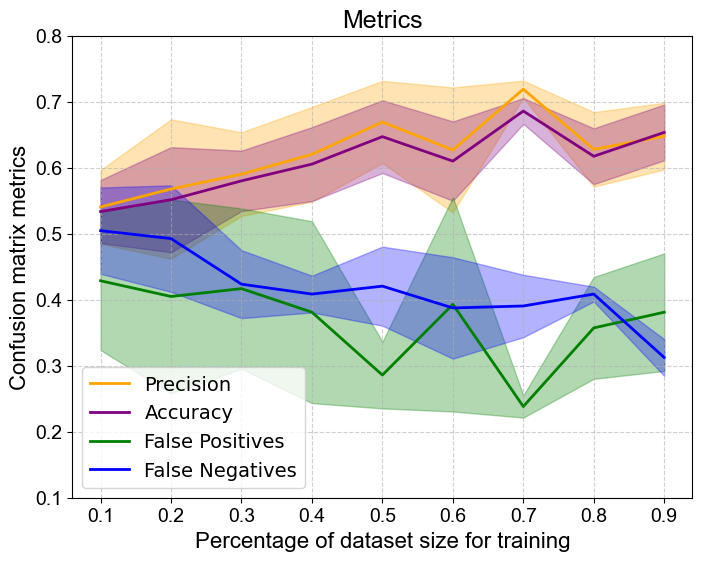

In [23]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(sizes, mean_precisions, color='orange', linewidth=2, label='Precision')
plt.fill_between(sizes, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(sizes, mean_accuracies, color='purple', linewidth=2, label='Accuracy')
plt.fill_between(sizes, mean_accuracies - std_accuracies, mean_accuracies + std_accuracies,
                 color='purple', alpha=0.3)

# False Positives (green)
plt.plot(sizes, mean_false_positives, color='green', linewidth=2, label='False Positives')
plt.fill_between(sizes, mean_false_positives - std_false_positives, mean_false_positives + std_false_positives,
                 color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(sizes, mean_false_negatives, color='blue', linewidth=2, label='False Negatives')
plt.fill_between(sizes, mean_false_negatives - std_false_negatives, mean_false_negatives + std_false_negatives,
                 color='blue', alpha=0.3)

# Formatting
plt.xlabel("Percentage of dataset size for training", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

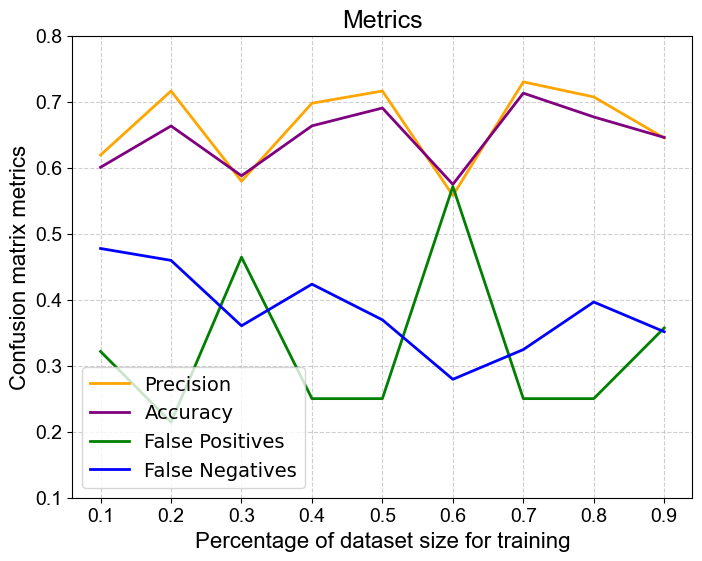

In [ ]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(sizes, mean_precisions, color='orange', linewidth=2, label='Precision')
plt.fill_between(sizes, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(sizes, mean_accuracies, color='purple', linewidth=2, label='Accuracy')
plt.fill_between(sizes, mean_accuracies - std_accuracies, mean_accuracies + std_accuracies,
                 color='purple', alpha=0.3)

# False Positives (green)
plt.plot(sizes, mean_false_positives, color='green', linewidth=2, label='False Positives')
plt.fill_between(sizes, mean_false_positives - std_false_positives, mean_false_positives + std_false_positives,
                 color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(sizes, mean_false_negatives, color='blue', linewidth=2, label='False Negatives')
plt.fill_between(sizes, mean_false_negatives - std_false_negatives, mean_false_negatives + std_false_negatives,
                 color='blue', alpha=0.3)

# Formatting
plt.xlabel("Percentage of dataset size for training", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
conf_matrix_tabular5 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/confusion_matrices_tabular.npy")
conf_matrix_tabular9 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.9/confusion_matrices_tabular.npy")

conf_matrix_tabular_seed42 = np.concatenate([conf_matrix_tabular5, conf_matrix_tabular9], axis=0)
conf_matrix_tabular_seed43 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed43_split_0.9/confusion_matrices_tabular.npy")
conf_matrix_tabular_seed44 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/seed44_split_0.9/confusion_matrices_tabular.npy")

conf_matrix_tabular = np.stack((conf_matrix_tabular_seed42, conf_matrix_tabular_seed43, conf_matrix_tabular_seed44), axis=0)

In [26]:
conf_matrix_tabular.shape

(3, 10, 2, 2)

In [27]:
# Get confusion matrices and plot precisions 

precision_tabular = np.zeros((9, 3))
accuracy_tabular = np.zeros((9, 3))
false_positives_tabular = np.zeros((9, 3))
false_negatives_tabular = np.zeros((9, 3))

for size in range(conf_matrix_tabular.shape[1]-1):
    for seed in range(conf_matrix_tabular.shape[0]):
        conf_matrix = conf_matrix_tabular[seed, size]
        precision_tabular[size, seed] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[1,0])
        accuracy_tabular[size, seed] = (conf_matrix[0,0] + conf_matrix[1,1]) / np.sum(conf_matrix)
        false_positives_tabular[size, seed] = conf_matrix[1,0] #/ np.sum(conf_matrix[1,:])
        false_negatives_tabular[size, seed] = conf_matrix[0,1] #/ np.sum(conf_matrix[0,:])

In [29]:
mean_precisions_tab = np.mean(precision_tabular, axis=1)
std_precisions_tab = np.std(precision_tabular, axis=1)

mean_accuracies_tab = np.mean(accuracy_tabular, axis=1)
std_accuracies_tab = np.std(accuracy_tabular, axis=1)

mean_false_positives_tab = np.mean(false_positives_tabular, axis=1)
std_false_positives_tab = np.std(false_positives_tabular, axis=1)

mean_false_negatives_tab = np.mean(false_negatives_tabular, axis=1)
std_false_negatives_tab = np.std(false_negatives_tabular, axis=1)

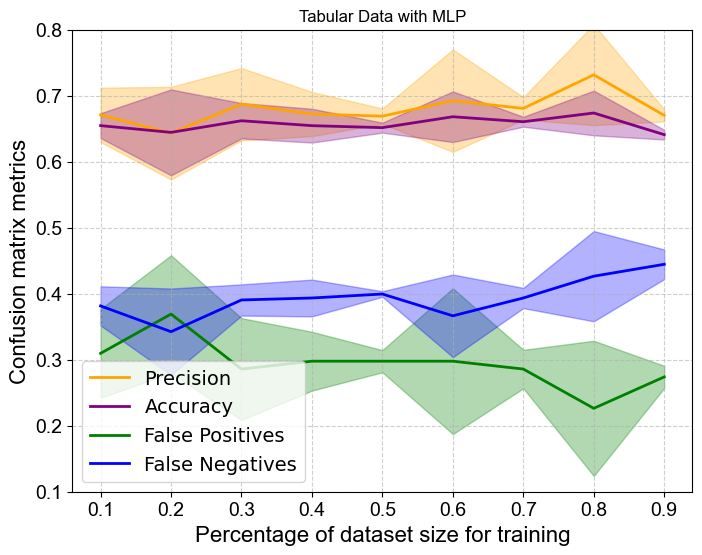

In [30]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(sizes, mean_precisions_tab, color='orange', linewidth=2, label='Precision')
plt.fill_between(sizes, mean_precisions_tab - std_precisions_tab, mean_precisions_tab + std_precisions_tab,
                 color='orange', alpha=0.3)

# Accuracy (purple)
plt.plot(sizes, mean_accuracies_tab, color='purple', linewidth=2, label='Accuracy')
plt.fill_between(sizes, mean_accuracies_tab - std_accuracies_tab, mean_accuracies_tab + std_accuracies_tab,
                 color='purple', alpha=0.3)

# False Positives (green)
plt.plot(sizes, mean_false_positives_tab, color='green', linewidth=2, label='False Positives')
plt.fill_between(sizes, mean_false_positives_tab - std_false_positives_tab, mean_false_positives_tab + std_false_positives_tab,
                 color='green', alpha=0.3)

# False Negatives (blue)
plt.plot(sizes, mean_false_negatives_tab, color='blue', linewidth=2, label='False Negatives')
plt.fill_between(sizes, mean_false_negatives_tab - std_false_negatives_tab, mean_false_negatives_tab + std_false_negatives_tab,
                 color='blue', alpha=0.3)

# Formatting
plt.xlabel("Percentage of dataset size for training", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)
plt.title("Tabular Data with MLP")
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

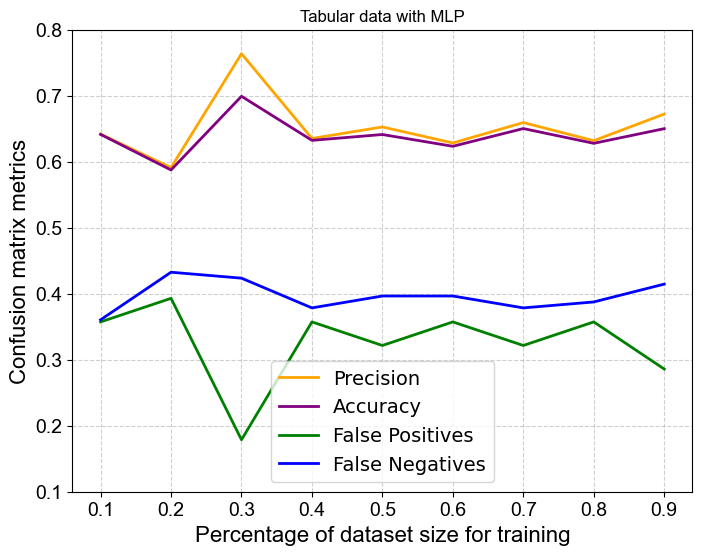

In [66]:
sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Plot
plt.figure(figsize=(8, 6))

# Precision (orange)
plt.plot(sizes, precision_tabular, color='orange', linewidth=2, label='Precision')

# Accuracy (purple)
plt.plot(sizes, accuracy_tabular, color='purple', linewidth=2, label='Accuracy')

# False Positives (green)
plt.plot(sizes, false_positives_tabular, color='green', linewidth=2, label='False Positives')

# False Negatives (blue)
plt.plot(sizes, false_negatives_tabular, color='blue', linewidth=2, label='False Negatives')

# Formatting
plt.xlabel("Percentage of dataset size for training", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix metrics", fontsize=16, fontname="Arial")
plt.title("Metrics", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.title("Tabular data with MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)
# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

## Running with other seeds to get a standard deviation

In [8]:
dataset_size = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 

def data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=44):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))
    confusion_matrices_tabular = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 
        output_dir=f"../results/data_labelling_study/seed44_split_{size}"
        os.makedirs(output_dir, exist_ok=True)

        less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[np.sort(less_indexes)]
        smaller_y_train = train_labels[np.sort(less_indexes)]
        smaller_x_train_tracks = train_tracks[np.sort(less_indexes)]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

        # TODO: add perturbations ?

        # TRACKS: train classifier

        config_tracks = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
        }
        
        train_tracks_ = smaller_x_train_tracks[:,0,4:17]
        test_tracks_ = test_tracks[:,0,4:17]
        train_labels_ = smaller_y_train
        test_labels_ = test_labels

        print("Train tracks shape: ", train_tracks_.shape)

        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_.flatten()), y=train_labels_.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_.shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_tracks['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_, test_labels_, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_, train_labels_, batch_size=config_tracks['batch_size'], epochs=config_tracks['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels_))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        confusion_matrices_tabular[dataset_size.index(size)] = conf_matrix_normalized
        np.save(f"{output_dir}/confusion_matrices_tabular.npy", confusion_matrices_tabular)

    return confusion_matrices_cellfate, confusion_matrices_tabular



X_train size:  (252, 20, 20) Y_train size:  (252,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 44, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

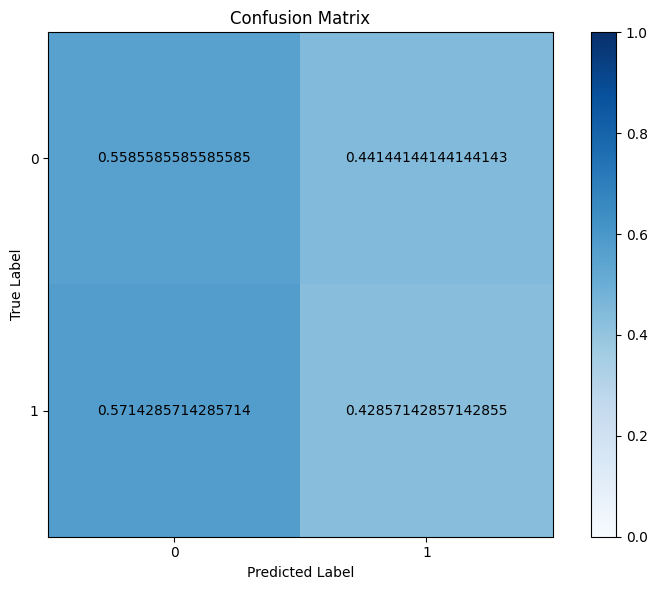

Train tracks shape:  (110, 13)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7694 - loss: 0.8267 - val_accuracy: 0.8696 - val_loss: 1.2475
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6400 - loss: 0.9231 - val_accuracy: 0.8696 - val_loss: 0.8145
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6475 - loss: 0.8236 - val_accuracy: 0.8696 - val_loss: 0.6020
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7466 - loss: 0.9260 - val_accuracy: 0.8696 - val_loss: 0.5039
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6686 - loss: 0.7007 - val_accuracy: 0.8406 - val_loss: 0.4838
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7023 - loss: 0.7119 - val_accuracy: 0.8188 - val_loss: 0.5000
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5833 - loss: 0.8626 - val_accuracy: 0.7899 - val_loss: 0.5278
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6798 - loss: 0.7166 - val_accuracy: 0.7174 - val_loss: 0.5567
Epoch 9

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2825 - loss: 0.8773 - val_accuracy: 0.4420 - val_loss: 0.7311
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3085 - loss: 0.8618 - val_accuracy: 0.4348 - val_loss: 0.7301
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3175 - loss: 0.8609 - val_accuracy: 0.4420 - val_loss: 0.7280
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2994 - loss: 0.8489 - val_accuracy: 0.4420 - val_loss: 0.7256
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3184 - loss: 0.8344 - val_accuracy: 0.4420 - val_loss: 0.7232
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2723 - loss: 0.8278 - val_accuracy: 0.4348 - val_loss: 0.7206
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2692 - loss: 0.8219 - val_accuracy: 0.4348 - val_loss: 0.7182
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3155 - loss: 0.7925 - val_accuracy: 0.4348 - val_loss:

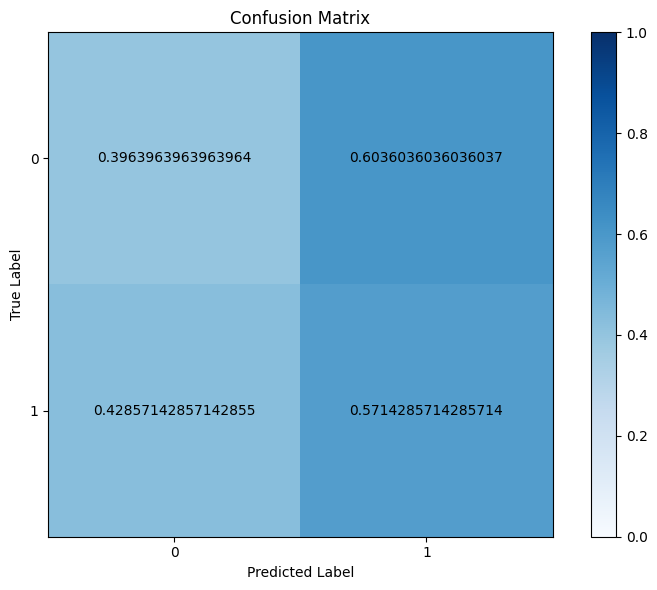

Train tracks shape:  (221, 13)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_21          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7917 - loss: 0.8568 - val_accuracy: 0.8696 - val_loss: 0.8508
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7716 - loss: 0.8707 - val_accuracy: 0.8696 - val_loss: 0.5231
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7546 - loss: 0.6905 - val_accuracy: 0.8696 - val_loss: 0.4745
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6943 - loss: 0.6667 - val_accuracy: 0.8043 - val_loss: 0.5168
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6665 - loss: 0.6871 - val_accuracy: 0.7101 - val_loss: 0.5778
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6160 - loss: 0.6469 - val_accuracy: 0.6232 - val_loss: 0.6176
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6350 - loss: 0.6091 - val_accuracy: 0.5580 - val_loss: 0.6382
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5639 - loss: 0.6604 - val_accuracy: 0.5580 - val_loss: 0.6445
Epoch 9

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4055 - loss: 0.8435 - val_accuracy: 0.3551 - val_loss: 0.8962
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4332 - loss: 0.8181 - val_accuracy: 0.3551 - val_loss: 0.8671
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.4296 - loss: 0.8137 - val_accuracy: 0.3551 - val_loss: 0.8391
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.4127 - loss: 0.7948 - val_accuracy: 0.3768 - val_loss: 0.8143
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4019 - loss: 0.7888 - val_accuracy: 0.3841 - val_loss: 0.7913
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.4377 - loss: 0.7675 - val_accuracy: 0.4130 - val_loss: 0.7705
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4177 - loss: 0.7484 - val_accuracy: 0.4275 - val_loss: 0.7534
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.4499 - loss: 0.7299 - val_accuracy: 0.4348 - v

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_25 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5517 - loss: 0.7479 - val_accuracy: 0.6667 - val_loss: 0.5916
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.5949 - loss: 0.7065 - val_accuracy: 0.6594 - val_loss: 0.5981
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5752 - loss: 0.7253 - val_accuracy: 0.6449 - val_loss: 0.6031
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.5781 - loss: 0.7164 - val_accuracy: 0.6377 - val_loss: 0.6087
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.5839 - loss: 0.6850 - val_accuracy: 0.6377 - val_loss: 0.6143
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.5481 - loss: 0.6980 - val_accuracy: 0.6232 - val_loss: 0.6190
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.6226 - loss: 0.6731 - val_accuracy: 0.6232 - val_loss: 0.6245
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.6091 - loss: 0.6649 - val_accuracy: 0.61

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_26 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5607 - loss: 1.0633 - val_accuracy: 0.4275 - val_loss: 1.2197
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.5694 - loss: 1.0507 - val_accuracy: 0.4420 - val_loss: 1.1908
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.5438 - loss: 0.9818 - val_accuracy: 0.4493 - val_loss: 1.1635
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5638 - loss: 0.9356 - val_accuracy: 0.4493 - val_loss: 1.1377
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.5780 - loss: 0.9676 - val_accuracy: 0.4493 - val_loss: 1.1141
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5613 - loss: 0.9296 - val_accuracy: 0.4638 - val_loss: 1.0907
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.5839 - loss: 0.9134 - val_accuracy: 0.4638 - val_loss: 1.0685
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.5794 - loss: 0.9638 - val_accuracy: 0.4783

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_27 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3302 - loss: 1.4599 - val_accuracy: 0.4275 - val_loss: 1.0572
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3214 - loss: 1.4456 - val_accuracy: 0.4058 - val_loss: 1.0544
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.3229 - loss: 1.4021 - val_accuracy: 0.3986 - val_loss: 1.0512
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.3687 - loss: 1.3338 - val_accuracy: 0.3986 - val_loss: 1.0478
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.3289 - loss: 1.3321 - val_accuracy: 0.3986 - val_loss: 1.0424
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.3215 - loss: 1.3137 - val_accuracy: 0.3986 - val_loss: 1.0368
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.3601 - loss: 1.2688 - val_accuracy: 0.3841 - val_loss: 1.0329
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.3599 - loss: 1.2701 - val_accuracy: 0.3768

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_28 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3659 - loss: 1.5545 - val_accuracy: 0.4348 - val_loss: 1.2759
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.3361 - loss: 1.6395 - val_accuracy: 0.4348 - val_loss: 1.2603
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3313 - loss: 1.5719 - val_accuracy: 0.4348 - val_loss: 1.2454
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.3489 - loss: 1.5086 - val_accuracy: 0.4275 - val_loss: 1.2305
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.3452 - loss: 1.4938 - val_accuracy: 0.4275 - val_loss: 1.2164
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.3500 - loss: 1.4388 - val_accuracy: 0.4275 - val_loss: 1.2027
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.3365 - loss: 1.4787 - val_accuracy: 0.4275 - val_loss: 1.1881
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.3753 - loss: 1.3718 - val_accuracy: 0.4348

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_29 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8124 - loss: 0.6245 - val_accuracy: 0.5870 - val_loss: 0.6828
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.7834 - loss: 0.6138 - val_accuracy: 0.5870 - val_loss: 0.6796
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.8054 - loss: 0.5893 - val_accuracy: 0.6087 - val_loss: 0.6766
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8254 - loss: 0.5700 - val_accuracy: 0.6087 - val_loss: 0.6740
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7703 - loss: 0.5692 - val_accuracy: 0.6087 - val_loss: 0.6717
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.5552 - val_accuracy: 0.6159 - val_loss: 0.6690
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.7881 - loss: 0.5517 - val_accuracy: 0.6232 - val_loss: 0.6673
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.7822 - loss: 0.5500 - val_accuracy: 0.6377

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_30 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6657 - loss: 0.5736 - val_accuracy: 0.4638 - val_loss: 1.0015
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.7364 - loss: 0.5207 - val_accuracy: 0.4638 - val_loss: 0.9887
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6673 - loss: 0.5414 - val_accuracy: 0.4710 - val_loss: 0.9772
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6972 - loss: 0.4998 - val_accuracy: 0.4928 - val_loss: 0.9676
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7184 - loss: 0.4933 - val_accuracy: 0.4928 - val_loss: 0.9585
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7158 - loss: 0.4950 - val_accuracy: 0.5072 - val_loss: 0.9473
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.7279 - loss: 0.4949 - val_accuracy: 0.5145 - val_loss: 0.9372
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.7365 - loss: 0.4902 - val_accuracy: 0.52

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_31 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3454 - loss: 0.9732 - val_accuracy: 0.3406 - val_loss: 0.8717
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3383 - loss: 0.9517 - val_accuracy: 0.3623 - val_loss: 0.8554
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3650 - loss: 0.9185 - val_accuracy: 0.3768 - val_loss: 0.8410
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.3758 - loss: 0.9007 - val_accuracy: 0.3913 - val_loss: 0.8279
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.3862 - loss: 0.9071 - val_accuracy: 0.3986 - val_loss: 0.8133
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.3842 - loss: 0.8808 - val_accuracy: 0.4203 - val_loss: 0.8010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.4000 - loss: 0.8511 - val_accuracy: 0.4203 - val_loss: 0.7904
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.4020 - loss: 0.8218 - val_accuracy: 0.4348 -

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6601 - loss: 0.5144 - val_accuracy: 0.4783 - val_loss: 0.8330
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6237 - loss: 0.4918 - val_accuracy: 0.4928 - val_loss: 0.8244
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6368 - loss: 0.4865 - val_accuracy: 0.4928 - val_loss: 0.8169
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6944 - loss: 0.4760 - val_accuracy: 0.4928 - val_loss: 0.8089
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.7024 - loss: 0.4817 - val_accuracy: 0.4928 - val_loss: 0.8031
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7401 - loss: 0.4716 - val_accuracy: 0.5145 - val_loss: 0.7963
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7413 - loss: 0.4873 - val_accuracy: 0.5145 - val_loss: 0.7888
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7787 - loss: 0.4516 - val_accuracy: 0.5145 -

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6664 - loss: 0.5778 - val_accuracy: 0.5145 - val_loss: 0.9833
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6485 - loss: 0.5981 - val_accuracy: 0.5217 - val_loss: 0.9765
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6426 - loss: 0.6009 - val_accuracy: 0.5217 - val_loss: 0.9712
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.6671 - loss: 0.5822 - val_accuracy: 0.5217 - val_loss: 0.9656
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6918 - loss: 0.5442 - val_accuracy: 0.5145 - val_loss: 0.9603
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6526 - loss: 0.5442 - val_accuracy: 0.5217 - val_loss: 0.9590
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6478 - loss: 0.5675 - val_accuracy: 0.5362 - val_loss: 0.9544
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7130 - loss: 0.4898 - val_accuracy: 0.5362

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_34 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2423 - loss: 1.9461 - val_accuracy: 0.4638 - val_loss: 1.0069
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2393 - loss: 1.8692 - val_accuracy: 0.4710 - val_loss: 1.0061
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.2631 - loss: 1.8011 - val_accuracy: 0.4565 - val_loss: 1.0047
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2520 - loss: 1.7472 - val_accuracy: 0.4420 - val_loss: 1.0028
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.2658 - loss: 1.7550 - val_accuracy: 0.4493 - val_loss: 1.0004
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.2461 - loss: 1.6907 - val_accuracy: 0.4493 - val_loss: 0.9981
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.2511 - loss: 1.6835 - val_accuracy: 0.4493 - val_loss: 0.9959
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.2506 - loss: 1.6313 - val_accuracy: 0.4493 -

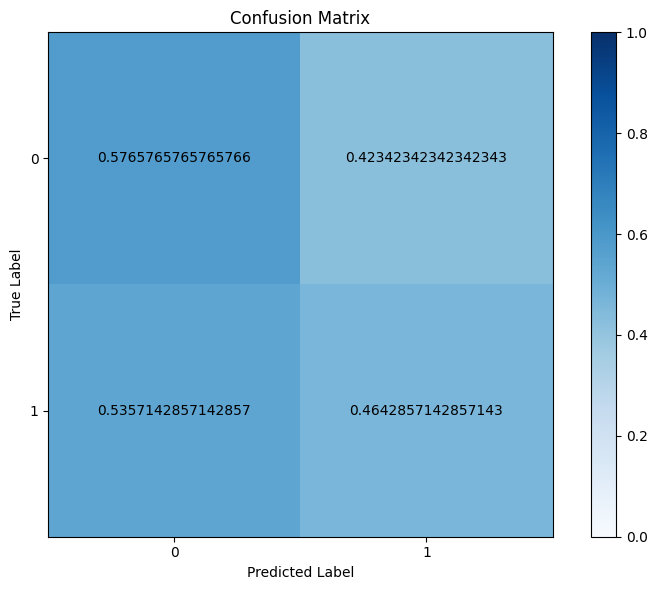

Train tracks shape:  (332, 13)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_32          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8139 - loss: 0.8103 - val_accuracy: 0.8696 - val_loss: 0.6715
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7842 - loss: 0.6510 - val_accuracy: 0.8696 - val_loss: 0.4731
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7315 - loss: 0.6271 - val_accuracy: 0.8261 - val_loss: 0.4986
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7562 - loss: 0.6768 - val_accuracy: 0.7681 - val_loss: 0.5484
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6529 - loss: 0.6663 - val_accuracy: 0.6304 - val_loss: 0.5934
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6771 - loss: 0.6267 - val_accuracy: 0.5580 - val_loss: 0.6196
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6113 - loss: 0.6209 - val_accuracy: 0.5507 - val_loss: 0.6326
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6786 - loss: 0.6577 - val_accuracy: 0.5072 - val_loss:

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_44 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3677 - loss: 0.8815 - val_accuracy: 0.4710 - val_loss: 0.8071
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.3813 - loss: 0.8470 - val_accuracy: 0.4565 - val_loss: 0.7895
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.3846 - loss: 0.8082 - val_accuracy: 0.4493 - val_loss: 0.7741
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.3771 - loss: 0.8079 - val_accuracy: 0.4420 - val_loss: 0.7581
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.3926 - loss: 0.7822 - val_accuracy: 0.4420 - val_loss: 0.7443
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.4171 - loss: 0.7488 - val_accuracy: 0.4565 - val_loss: 0.7338
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.3888 - loss: 0.7426 - val_accuracy: 0.4638 - val_loss: 0.7229
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.4239 - loss: 0.7207 - val_accuracy: 0.48

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_45 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 0.7978 - val_accuracy: 0.4493 - val_loss: 0.9517
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.6125 - loss: 0.7960 - val_accuracy: 0.4638 - val_loss: 0.9123
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.6110 - loss: 0.7690 - val_accuracy: 0.4710 - val_loss: 0.8749
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.6357 - loss: 0.7444 - val_accuracy: 0.4855 - val_loss: 0.8399
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.6182 - loss: 0.7174 - val_accuracy: 0.5072 - val_loss: 0.8111
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.6160 - loss: 0.7306 - val_accuracy: 0.5145 - val_loss: 0.7842
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.6368 - loss: 0.6932 - val_accuracy: 0.5290 - val_loss: 0.7595
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.6198 - loss: 0.7003 - val_accuracy: 0.52

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_46 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4989 - loss: 1.2226 - val_accuracy: 0.5217 - val_loss: 0.9513
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.5065 - loss: 1.1345 - val_accuracy: 0.5217 - val_loss: 0.9357
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.5330 - loss: 1.0550 - val_accuracy: 0.5290 - val_loss: 0.9220
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.5189 - loss: 1.0619 - val_accuracy: 0.5362 - val_loss: 0.9080
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.5095 - loss: 1.1117 - val_accuracy: 0.5507 - val_loss: 0.8940
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.5171 - loss: 1.0700 - val_accuracy: 0.5435 - val_loss: 0.8797
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.5710 - loss: 0.9857 - val_accuracy: 0.5435 - val_loss: 0.8678
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.5493 - loss: 0.9746 - val_accuracy: 0.55

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_47 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4102 - loss: 1.5015 - val_accuracy: 0.2754 - val_loss: 1.5506
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.4103 - loss: 1.3737 - val_accuracy: 0.2754 - val_loss: 1.5048
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.4090 - loss: 1.4108 - val_accuracy: 0.2754 - val_loss: 1.4581
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.3817 - loss: 1.4813 - val_accuracy: 0.2826 - val_loss: 1.4084
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.4078 - loss: 1.3089 - val_accuracy: 0.2826 - val_loss: 1.3648
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.4072 - loss: 1.3413 - val_accuracy: 0.2826 - val_loss: 1.3227
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.4089 - loss: 1.2901 - val_accuracy: 0.2826 - val_loss: 1.2844
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.4141 - loss: 1.2218 - val_accuracy: 0.28

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_48 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4068 - loss: 1.5259 - val_accuracy: 0.4565 - val_loss: 1.1767
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.3682 - loss: 1.5218 - val_accuracy: 0.4565 - val_loss: 1.1582
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.3630 - loss: 1.4828 - val_accuracy: 0.4565 - val_loss: 1.1392
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.3870 - loss: 1.4434 - val_accuracy: 0.4565 - val_loss: 1.1177
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.4133 - loss: 1.3530 - val_accuracy: 0.4493 - val_loss: 1.0984
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.3911 - loss: 1.3248 - val_accuracy: 0.4493 - val_loss: 1.0765
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.3741 - loss: 1.2917 - val_accuracy: 0.4493 - val_loss: 1.0567
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.3917 - loss: 1.2491 - val_accuracy: 0.44

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_49 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7057 - loss: 0.6392 - val_accuracy: 0.4928 - val_loss: 0.7021
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.7175 - loss: 0.6273 - val_accuracy: 0.5290 - val_loss: 0.6988
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7427 - loss: 0.6046 - val_accuracy: 0.5362 - val_loss: 0.6953
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7489 - loss: 0.5969 - val_accuracy: 0.5507 - val_loss: 0.6915
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.7011 - loss: 0.6039 - val_accuracy: 0.5580 - val_loss: 0.6877
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7350 - loss: 0.5833 - val_accuracy: 0.5797 - val_loss: 0.6843
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.7395 - loss: 0.5776 - val_accuracy: 0.5870 - val_loss: 0.6817
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.7464 - loss: 0.5692 - val_accuracy: 0.59

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_50 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7322 - loss: 0.5013 - val_accuracy: 0.5435 - val_loss: 0.8740
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7536 - loss: 0.4696 - val_accuracy: 0.5580 - val_loss: 0.8650
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.7223 - loss: 0.4660 - val_accuracy: 0.5580 - val_loss: 0.8563
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7536 - loss: 0.4425 - val_accuracy: 0.5580 - val_loss: 0.8484
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7520 - loss: 0.4570 - val_accuracy: 0.5652 - val_loss: 0.8396
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7279 - loss: 0.4545 - val_accuracy: 0.5725 - val_loss: 0.8321
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.7855 - loss: 0.4188 - val_accuracy: 0.5725 - val_loss: 0.8255
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.7589 - loss: 0.4206 - val_accuracy: 0.57

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_51 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2602 - loss: 0.9984 - val_accuracy: 0.2754 - val_loss: 0.8529
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.2792 - loss: 0.9749 - val_accuracy: 0.2826 - val_loss: 0.8299
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.2990 - loss: 0.9413 - val_accuracy: 0.3116 - val_loss: 0.8089
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - accuracy: 0.2697 - loss: 0.9255 - val_accuracy: 0.3333 - val_loss: 0.7887
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.2800 - loss: 0.8886 - val_accuracy: 0.3406 - val_loss: 0.7702
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.3046 - loss: 0.8566 - val_accuracy: 0.3406 - val_loss: 0.7540
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.2803 - loss: 0.8332 - val_accuracy: 0.3551 - val_loss: 0.7408
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.3479 - loss: 0.7919 - val_accuracy: 0.39

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_52 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3301 - loss: 1.2352 - val_accuracy: 0.5362 - val_loss: 0.8921
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.3204 - loss: 1.1517 - val_accuracy: 0.5435 - val_loss: 0.8758
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.3912 - loss: 1.1228 - val_accuracy: 0.5435 - val_loss: 0.8608
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.4261 - loss: 1.0656 - val_accuracy: 0.5507 - val_loss: 0.8452
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.5017 - loss: 0.9733 - val_accuracy: 0.5507 - val_loss: 0.8314
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.5492 - loss: 0.9514 - val_accuracy: 0.5725 - val_loss: 0.8173
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.5431 - loss: 0.8849 - val_accuracy: 0.5725 - val_loss: 0.8046
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.6012 - loss: 0.8637 - val_accuracy: 0.56

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_53 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3273 - loss: 1.3796 - val_accuracy: 0.4493 - val_loss: 1.0867
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.3419 - loss: 1.3469 - val_accuracy: 0.4348 - val_loss: 1.0584
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.3296 - loss: 1.3123 - val_accuracy: 0.4348 - val_loss: 1.0338
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.3262 - loss: 1.3366 - val_accuracy: 0.4348 - val_loss: 1.0095
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.3498 - loss: 1.2274 - val_accuracy: 0.4420 - val_loss: 0.9858
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.3447 - loss: 1.2182 - val_accuracy: 0.4420 - val_loss: 0.9621
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.3356 - loss: 1.1342 - val_accuracy: 0.4420 - val_loss: 0.9389
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.3603 - loss: 1.1260 - val_accuracy: 0.44

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_54 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4863 - loss: 1.4881 - val_accuracy: 0.4203 - val_loss: 1.0876
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5010 - loss: 1.3955 - val_accuracy: 0.4275 - val_loss: 1.0669
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.5015 - loss: 1.2671 - val_accuracy: 0.4348 - val_loss: 1.0484
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.5136 - loss: 1.2191 - val_accuracy: 0.4420 - val_loss: 1.0283
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.5408 - loss: 1.1638 - val_accuracy: 0.4420 - val_loss: 1.0091
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.5247 - loss: 1.1472 - val_accuracy: 0.4420 - val_loss: 0.9905
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.5766 - loss: 1.1091 - val_accuracy: 0.4783 - val_loss: 0.9733
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.5465 - loss: 1.0655 - val_accuracy: 0.49

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_55 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4515 - loss: 0.8243 - val_accuracy: 0.4928 - val_loss: 0.8803
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.4672 - loss: 0.7835 - val_accuracy: 0.5217 - val_loss: 0.8540
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.4644 - loss: 0.7594 - val_accuracy: 0.5217 - val_loss: 0.8305
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5087 - loss: 0.7419 - val_accuracy: 0.5435 - val_loss: 0.8085
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - accuracy: 0.5208 - loss: 0.6785 - val_accuracy: 0.5362 - val_loss: 0.7906
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.5823 - loss: 0.6746 - val_accuracy: 0.5652 - val_loss: 0.7708
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7111 - loss: 0.6489 - val_accuracy: 0.5725 - val_loss: 0.7539
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.7543 - loss: 0.6298 - val_accuracy: 0.59

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_56 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3436 - loss: 1.5621 - val_accuracy: 0.3116 - val_loss: 1.3993
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.3229 - loss: 1.5270 - val_accuracy: 0.3043 - val_loss: 1.3619
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.3563 - loss: 1.4191 - val_accuracy: 0.3043 - val_loss: 1.3255
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.3397 - loss: 1.5105 - val_accuracy: 0.2971 - val_loss: 1.2858
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.3256 - loss: 1.4591 - val_accuracy: 0.3043 - val_loss: 1.2505
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.3285 - loss: 1.3914 - val_accuracy: 0.3333 - val_loss: 1.2138
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.3628 - loss: 1.2925 - val_accuracy: 0.3478 - val_loss: 1.1802
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.4009 - loss: 1.2340 - val_accuracy: 0.36

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_57 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8023 - loss: 0.3804 - val_accuracy: 0.7174 - val_loss: 0.5825
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.8474 - loss: 0.3522 - val_accuracy: 0.6957 - val_loss: 0.5918
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.8529 - loss: 0.3446 - val_accuracy: 0.6957 - val_loss: 0.5999
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.8417 - loss: 0.3485 - val_accuracy: 0.6957 - val_loss: 0.6090
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.8516 - loss: 0.3386 - val_accuracy: 0.6957 - val_loss: 0.6164
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8498 - loss: 0.3270 - val_accuracy: 0.6884 - val_loss: 0.6229
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.8754 - loss: 0.3152 - val_accuracy: 0.6957 - val_loss: 0.6309
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.8635 - loss: 0.3193 - val_accuracy: 0.68

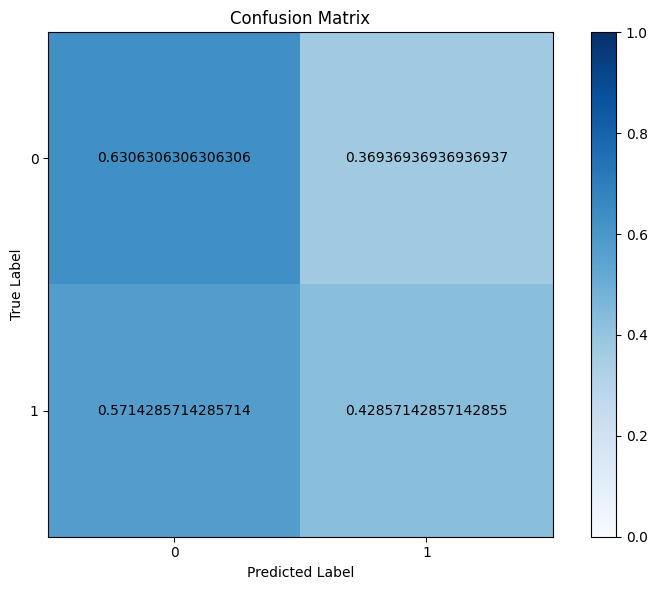

Train tracks shape:  (443, 13)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_43          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7900 - loss: 0.7840 - val_accuracy: 0.8696 - val_loss: 0.5739
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6806 - loss: 0.7132 - val_accuracy: 0.8478 - val_loss: 0.4790
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6554 - loss: 0.7095 - val_accuracy: 0.6884 - val_loss: 0.5951
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6151 - loss: 0.6504 - val_accuracy: 0.4855 - val_loss: 0.6766
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5829 - loss: 0.6626 - val_accuracy: 0.4203 - val_loss: 0.7154
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5913 - loss: 0.6232 - val_accuracy: 0.3986 - val_loss: 0.7335
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5787 - loss: 0.6111 - val_accuracy: 0.3986 - val_loss: 0.7285
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5186 - loss: 0.6570 - val_accuracy: 0.3986 - val_loss:

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_67 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4041 - loss: 0.8713 - val_accuracy: 0.2826 - val_loss: 0.9006
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.4108 - loss: 0.8229 - val_accuracy: 0.2899 - val_loss: 0.8457
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.4085 - loss: 0.7950 - val_accuracy: 0.3188 - val_loss: 0.7987
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.4118 - loss: 0.7719 - val_accuracy: 0.3913 - val_loss: 0.7580
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.4344 - loss: 0.7365 - val_accuracy: 0.4710 - val_loss: 0.7283
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.4208 - loss: 0.7267 - val_accuracy: 0.4928 - val_loss: 0.7002
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.4471 - loss: 0.7076 - val_accuracy: 0.5870 - val_loss: 0.6794
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.5279 - loss: 0.6921 - val_accuracy: 0.63

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_68 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6367 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.8414
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.6586 - loss: 0.6537 - val_accuracy: 0.4928 - val_loss: 0.8025
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.6619 - loss: 0.6582 - val_accuracy: 0.5217 - val_loss: 0.7653
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.6559 - loss: 0.6564 - val_accuracy: 0.5435 - val_loss: 0.7338
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.6492 - loss: 0.6511 - val_accuracy: 0.5507 - val_loss: 0.7079
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.6745 - loss: 0.6370 - val_accuracy: 0.5652 - val_loss: 0.6846
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6698 - loss: 0.6047 - val_accuracy: 0.5870 - val_loss: 0.6685
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.6771 - loss: 0.6155 - val_accuracy: 0.61

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_69 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078 - loss: 1.1942 - val_accuracy: 0.5507 - val_loss: 0.8404
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.4709 - loss: 1.1572 - val_accuracy: 0.5362 - val_loss: 0.8476
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.4883 - loss: 1.1296 - val_accuracy: 0.5290 - val_loss: 0.8552
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.5080 - loss: 1.0669 - val_accuracy: 0.5145 - val_loss: 0.8618
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.5010 - loss: 0.9783 - val_accuracy: 0.5072 - val_loss: 0.8682
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.5058 - loss: 1.0094 - val_accuracy: 0.5217 - val_loss: 0.8711
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.5004 - loss: 0.9571 - val_accuracy: 0.5072 - val_loss: 0.8725
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.5115 - loss: 0.9269 - val_accuracy: 0.51

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_70 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3493 - loss: 1.4921 - val_accuracy: 0.3043 - val_loss: 1.2781
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.3440 - loss: 1.4226 - val_accuracy: 0.3116 - val_loss: 1.2378
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.3311 - loss: 1.4542 - val_accuracy: 0.3188 - val_loss: 1.1936
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.3393 - loss: 1.4241 - val_accuracy: 0.3116 - val_loss: 1.1518
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.3432 - loss: 1.3314 - val_accuracy: 0.3116 - val_loss: 1.1108
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.3483 - loss: 1.3232 - val_accuracy: 0.3188 - val_loss: 1.0733
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.3664 - loss: 1.2689 - val_accuracy: 0.3261 - val_loss: 1.0422
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.3684 - loss: 1.1774 - val_accuracy: 0.32

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_71 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4145 - loss: 1.4439 - val_accuracy: 0.4348 - val_loss: 1.1166
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.3893 - loss: 1.4737 - val_accuracy: 0.4275 - val_loss: 1.0931
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.3959 - loss: 1.3843 - val_accuracy: 0.4275 - val_loss: 1.0697
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.3773 - loss: 1.3679 - val_accuracy: 0.4348 - val_loss: 1.0503
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.4041 - loss: 1.2992 - val_accuracy: 0.4275 - val_loss: 1.0312
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.4072 - loss: 1.2191 - val_accuracy: 0.4275 - val_loss: 1.0135
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.4135 - loss: 1.1687 - val_accuracy: 0.4203 - val_loss: 0.9952
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.3666 - loss: 1.1616 - val_accuracy: 0.41

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_72 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 0.6522 - val_accuracy: 0.4565 - val_loss: 0.7038
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6354 - loss: 0.6450 - val_accuracy: 0.5435 - val_loss: 0.6952
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - accuracy: 0.6334 - loss: 0.6378 - val_accuracy: 0.5652 - val_loss: 0.6879
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.6568 - loss: 0.6285 - val_accuracy: 0.5797 - val_loss: 0.6824
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.6487 - loss: 0.6281 - val_accuracy: 0.5797 - val_loss: 0.6770
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.6377 - loss: 0.6196 - val_accuracy: 0.6014 - val_loss: 0.6728
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.6890 - loss: 0.6002 - val_accuracy: 0.6159 - val_loss: 0.6693
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.6486 - loss: 0.6116 - val_accuracy: 0.62

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_73 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6995 - loss: 0.6246 - val_accuracy: 0.5652 - val_loss: 0.7777
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7106 - loss: 0.6060 - val_accuracy: 0.5870 - val_loss: 0.7510
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7033 - loss: 0.5966 - val_accuracy: 0.6014 - val_loss: 0.7292
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.6692 - loss: 0.5874 - val_accuracy: 0.6159 - val_loss: 0.7109
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6826 - loss: 0.6076 - val_accuracy: 0.6087 - val_loss: 0.6956
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.7138 - loss: 0.5725 - val_accuracy: 0.6159 - val_loss: 0.6813
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7074 - loss: 0.5629 - val_accuracy: 0.6232 - val_loss: 0.6707
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.7257 - loss: 0.5532 - val_accuracy: 0.62

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_74 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3002 - loss: 1.0516 - val_accuracy: 0.4348 - val_loss: 0.8246
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - accuracy: 0.3121 - loss: 0.9950 - val_accuracy: 0.4203 - val_loss: 0.8125
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.2913 - loss: 0.9449 - val_accuracy: 0.4058 - val_loss: 0.8011
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.2978 - loss: 0.8999 - val_accuracy: 0.3768 - val_loss: 0.7900
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.2909 - loss: 0.8527 - val_accuracy: 0.3768 - val_loss: 0.7796
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.2913 - loss: 0.8283 - val_accuracy: 0.3406 - val_loss: 0.7685
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.3025 - loss: 0.7881 - val_accuracy: 0.3043 - val_loss: 0.7576
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.2950 - loss: 0.7645 - val_accuracy: 0.24

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_75 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4437 - loss: 1.1309 - val_accuracy: 0.5725 - val_loss: 0.8489
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.4086 - loss: 1.1524 - val_accuracy: 0.5870 - val_loss: 0.8362
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.4940 - loss: 1.0723 - val_accuracy: 0.5942 - val_loss: 0.8235
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.5317 - loss: 0.9593 - val_accuracy: 0.5870 - val_loss: 0.8097
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.5602 - loss: 0.9699 - val_accuracy: 0.5870 - val_loss: 0.7955
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.5720 - loss: 0.9496 - val_accuracy: 0.5942 - val_loss: 0.7821
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.5605 - loss: 0.9118 - val_accuracy: 0.5942 - val_loss: 0.7711
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.6080 - loss: 0.8184 - val_accuracy: 0.60

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_76 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3617 - loss: 1.3750 - val_accuracy: 0.5580 - val_loss: 0.8414
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.3299 - loss: 1.3963 - val_accuracy: 0.5652 - val_loss: 0.8385
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.3520 - loss: 1.3509 - val_accuracy: 0.5580 - val_loss: 0.8337
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.3458 - loss: 1.2976 - val_accuracy: 0.5580 - val_loss: 0.8303
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.3571 - loss: 1.2174 - val_accuracy: 0.5435 - val_loss: 0.8257
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.3447 - loss: 1.1771 - val_accuracy: 0.5145 - val_loss: 0.8193
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.3713 - loss: 1.1335 - val_accuracy: 0.5145 - val_loss: 0.8133
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.4159 - loss: 1.0485 - val_accuracy: 0.50

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_77 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6258 - loss: 0.8972 - val_accuracy: 0.5362 - val_loss: 0.8906
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6276 - loss: 0.8632 - val_accuracy: 0.5507 - val_loss: 0.8587
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.6399 - loss: 0.8276 - val_accuracy: 0.5725 - val_loss: 0.8286
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.6493 - loss: 0.7570 - val_accuracy: 0.5725 - val_loss: 0.8042
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.6707 - loss: 0.7340 - val_accuracy: 0.5870 - val_loss: 0.7801
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6303 - loss: 0.7512 - val_accuracy: 0.6087 - val_loss: 0.7601
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.6574 - loss: 0.6952 - val_accuracy: 0.6159 - val_loss: 0.7408
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.6596 - loss: 0.6987 - val_accuracy: 0.62

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_78 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4114 - loss: 0.8574 - val_accuracy: 0.5797 - val_loss: 0.7422
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.4279 - loss: 0.8296 - val_accuracy: 0.5797 - val_loss: 0.7432
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.4445 - loss: 0.7900 - val_accuracy: 0.5797 - val_loss: 0.7432
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.4421 - loss: 0.7673 - val_accuracy: 0.5507 - val_loss: 0.7419
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.4849 - loss: 0.7367 - val_accuracy: 0.5435 - val_loss: 0.7389
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.6153 - loss: 0.6971 - val_accuracy: 0.5290 - val_loss: 0.7354
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.6594 - loss: 0.6792 - val_accuracy: 0.5290 - val_loss: 0.7319
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.6900 - loss: 0.6480 - val_accuracy: 0.54

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_79 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3302 - loss: 1.4652 - val_accuracy: 0.5072 - val_loss: 0.8548
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.3416 - loss: 1.4199 - val_accuracy: 0.5072 - val_loss: 0.8520
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.3360 - loss: 1.4412 - val_accuracy: 0.5072 - val_loss: 0.8483
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.3289 - loss: 1.3634 - val_accuracy: 0.5000 - val_loss: 0.8446
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.3448 - loss: 1.2952 - val_accuracy: 0.5000 - val_loss: 0.8403
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.3525 - loss: 1.2235 - val_accuracy: 0.4855 - val_loss: 0.8371
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.3478 - loss: 1.1753 - val_accuracy: 0.4710 - val_loss: 0.8327
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.3400 - loss: 1.1950 - val_accuracy: 0.47

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_80 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7322 - loss: 0.5572 - val_accuracy: 0.5362 - val_loss: 0.8135
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7287 - loss: 0.5529 - val_accuracy: 0.5435 - val_loss: 0.7998
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7230 - loss: 0.5451 - val_accuracy: 0.5435 - val_loss: 0.7849
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.7167 - loss: 0.5525 - val_accuracy: 0.5507 - val_loss: 0.7756
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.7505 - loss: 0.5252 - val_accuracy: 0.5652 - val_loss: 0.7646
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.7621 - loss: 0.5090 - val_accuracy: 0.5652 - val_loss: 0.7539
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.7609 - loss: 0.4925 - val_accuracy: 0.5797 - val_loss: 0.7473
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.7702 - loss: 0.4726 - val_accuracy: 0.58

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_81 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7492 - loss: 0.5128 - val_accuracy: 0.5507 - val_loss: 0.7422
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.7539 - loss: 0.4909 - val_accuracy: 0.5507 - val_loss: 0.7391
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7550 - loss: 0.4918 - val_accuracy: 0.5580 - val_loss: 0.7375
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7652 - loss: 0.4727 - val_accuracy: 0.5797 - val_loss: 0.7347
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.7665 - loss: 0.4713 - val_accuracy: 0.5870 - val_loss: 0.7314
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.7454 - loss: 0.4648 - val_accuracy: 0.5942 - val_loss: 0.7314
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.7473 - loss: 0.4707 - val_accuracy: 0.6014 - val_loss: 0.7319
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.7695 - loss: 0.4319 - val_accuracy: 0.61

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_82 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7564 - loss: 0.5173 - val_accuracy: 0.4928 - val_loss: 0.7914
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.7725 - loss: 0.4957 - val_accuracy: 0.5290 - val_loss: 0.7709
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7795 - loss: 0.4772 - val_accuracy: 0.5290 - val_loss: 0.7541
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.8114 - loss: 0.4574 - val_accuracy: 0.5652 - val_loss: 0.7398
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.8039 - loss: 0.4490 - val_accuracy: 0.5870 - val_loss: 0.7289
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8041 - loss: 0.4424 - val_accuracy: 0.5870 - val_loss: 0.7214
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.7928 - loss: 0.4594 - val_accuracy: 0.5942 - val_loss: 0.7158
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.8172 - loss: 0.4451 - val_accuracy: 0.58

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_83 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3529 - loss: 1.4010 - val_accuracy: 0.4493 - val_loss: 1.0403
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.4373 - loss: 1.3065 - val_accuracy: 0.4565 - val_loss: 1.0163
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.4688 - loss: 1.1660 - val_accuracy: 0.4493 - val_loss: 0.9942
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.4610 - loss: 1.1782 - val_accuracy: 0.4420 - val_loss: 0.9708
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.4882 - loss: 1.0791 - val_accuracy: 0.4565 - val_loss: 0.9461
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.4685 - loss: 1.0497 - val_accuracy: 0.4275 - val_loss: 0.9226
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.5110 - loss: 0.9452 - val_accuracy: 0.4130 - val_loss: 0.9004
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.5317 - loss: 0.8700 - val_accuracy: 0.42

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_84 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5152 - loss: 1.0214 - val_accuracy: 0.4130 - val_loss: 1.0565
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.4853 - loss: 1.0394 - val_accuracy: 0.4203 - val_loss: 0.9957
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.5099 - loss: 0.9166 - val_accuracy: 0.4348 - val_loss: 0.9441
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.5115 - loss: 0.8996 - val_accuracy: 0.4348 - val_loss: 0.8986
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.5018 - loss: 0.8994 - val_accuracy: 0.4420 - val_loss: 0.8507
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.5584 - loss: 0.8140 - val_accuracy: 0.4493 - val_loss: 0.8146
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.5536 - loss: 0.8037 - val_accuracy: 0.4928 - val_loss: 0.7832
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.5621 - loss: 0.7461 - val_accuracy: 0.52

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_85 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4991 - loss: 0.8437 - val_accuracy: 0.3841 - val_loss: 0.8965
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.5083 - loss: 0.8083 - val_accuracy: 0.4058 - val_loss: 0.8657
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.5353 - loss: 0.7680 - val_accuracy: 0.4058 - val_loss: 0.8398
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.5418 - loss: 0.7219 - val_accuracy: 0.4275 - val_loss: 0.8148
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.5725 - loss: 0.6979 - val_accuracy: 0.4493 - val_loss: 0.7944
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.5862 - loss: 0.6662 - val_accuracy: 0.4565 - val_loss: 0.7759
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.5902 - loss: 0.6456 - val_accuracy: 0.4783 - val_loss: 0.7625
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.6283 - loss: 0.6089 - val_accuracy: 0.50

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_86 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3507 - loss: 1.0521 - val_accuracy: 0.3986 - val_loss: 0.8617
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.3889 - loss: 0.9877 - val_accuracy: 0.4275 - val_loss: 0.8327
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.3923 - loss: 0.9496 - val_accuracy: 0.4710 - val_loss: 0.8056
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.4137 - loss: 0.9121 - val_accuracy: 0.5000 - val_loss: 0.7814
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.4238 - loss: 0.8506 - val_accuracy: 0.4855 - val_loss: 0.7595
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.4299 - loss: 0.8245 - val_accuracy: 0.4855 - val_loss: 0.7386
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.4365 - loss: 0.7954 - val_accuracy: 0.4928 - val_loss: 0.7207
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.5017 - loss: 0.7550 - val_accuracy: 0.49

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_87 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3320 - loss: 1.5219 - val_accuracy: 0.4565 - val_loss: 1.0406
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.3545 - loss: 1.4352 - val_accuracy: 0.4493 - val_loss: 1.0178
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.3545 - loss: 1.3864 - val_accuracy: 0.4420 - val_loss: 0.9955
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.3552 - loss: 1.3417 - val_accuracy: 0.4420 - val_loss: 0.9739
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.3527 - loss: 1.3057 - val_accuracy: 0.4420 - val_loss: 0.9552
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.3911 - loss: 1.1978 - val_accuracy: 0.4493 - val_loss: 0.9370
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.3990 - loss: 1.1899 - val_accuracy: 0.4493 - val_loss: 0.9189
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.3966 - loss: 1.1258 - val_accuracy: 0.46

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_88 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2732 - loss: 2.1586 - val_accuracy: 0.3696 - val_loss: 1.4614
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.3072 - loss: 2.0595 - val_accuracy: 0.3696 - val_loss: 1.4166
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.3020 - loss: 2.0386 - val_accuracy: 0.3696 - val_loss: 1.3758
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.2949 - loss: 2.0629 - val_accuracy: 0.3478 - val_loss: 1.3391
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.3024 - loss: 1.8842 - val_accuracy: 0.3478 - val_loss: 1.3019
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.3097 - loss: 1.8740 - val_accuracy: 0.3478 - val_loss: 1.2667
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.3153 - loss: 1.7784 - val_accuracy: 0.3551 - val_loss: 1.2309
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.3094 - loss: 1.7401 - val_accuracy: 0.36

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_89 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.6567 - val_accuracy: 0.6594 - val_loss: 0.6232
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.6542 - loss: 0.6235 - val_accuracy: 0.6739 - val_loss: 0.6273
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.6573 - loss: 0.5973 - val_accuracy: 0.6667 - val_loss: 0.6306
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.6713 - loss: 0.5693 - val_accuracy: 0.6522 - val_loss: 0.6333
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.7023 - loss: 0.5454 - val_accuracy: 0.6522 - val_loss: 0.6371
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.6906 - loss: 0.5394 - val_accuracy: 0.6522 - val_loss: 0.6395
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.7313 - loss: 0.5127 - val_accuracy: 0.6159 - val_loss: 0.6427
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.7333 - loss: 0.5108 - val_accuracy: 0.61

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_90 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1795 - loss: 0.9443 - val_accuracy: 0.4493 - val_loss: 0.7196
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.1685 - loss: 0.9038 - val_accuracy: 0.4203 - val_loss: 0.7216
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.2278 - loss: 0.8443 - val_accuracy: 0.3986 - val_loss: 0.7225
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.2690 - loss: 0.7966 - val_accuracy: 0.3406 - val_loss: 0.7219
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.3089 - loss: 0.7542 - val_accuracy: 0.3478 - val_loss: 0.7206
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.3942 - loss: 0.7171 - val_accuracy: 0.3261 - val_loss: 0.7180
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.4747 - loss: 0.6863 - val_accuracy: 0.3696 - val_loss: 0.7150
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.6179 - loss: 0.6554 - val_accuracy: 0.39

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_91 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4975 - loss: 0.6788 - val_accuracy: 0.4275 - val_loss: 0.7458
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.5414 - loss: 0.6634 - val_accuracy: 0.4493 - val_loss: 0.7235
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.6866 - loss: 0.6368 - val_accuracy: 0.5000 - val_loss: 0.7046
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.7291 - loss: 0.5914 - val_accuracy: 0.5217 - val_loss: 0.6910
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.7517 - loss: 0.5724 - val_accuracy: 0.5797 - val_loss: 0.6800
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.7811 - loss: 0.5490 - val_accuracy: 0.6377 - val_loss: 0.6695
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - accuracy: 0.7751 - loss: 0.5365 - val_accuracy: 0.6522 - val_loss: 0.6607
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.7952 - loss: 0.5046 - val_accuracy: 0.66

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_92 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7451 - loss: 0.5696 - val_accuracy: 0.5217 - val_loss: 0.7237
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.7693 - loss: 0.5480 - val_accuracy: 0.5507 - val_loss: 0.6982
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.7942 - loss: 0.5309 - val_accuracy: 0.5725 - val_loss: 0.6792
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7879 - loss: 0.5194 - val_accuracy: 0.6087 - val_loss: 0.6648
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.8228 - loss: 0.5054 - val_accuracy: 0.6159 - val_loss: 0.6526
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.8104 - loss: 0.4968 - val_accuracy: 0.6304 - val_loss: 0.6474
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.8369 - loss: 0.4637 - val_accuracy: 0.6304 - val_loss: 0.6414
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.8264 - loss: 0.4619 - val_accuracy: 0.63

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_93 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1779 - loss: 1.6693 - val_accuracy: 0.3188 - val_loss: 1.0971
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.1916 - loss: 1.5785 - val_accuracy: 0.3261 - val_loss: 1.0675
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.1839 - loss: 1.5769 - val_accuracy: 0.3261 - val_loss: 1.0376
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.1990 - loss: 1.4535 - val_accuracy: 0.3406 - val_loss: 1.0104
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.1967 - loss: 1.4240 - val_accuracy: 0.3406 - val_loss: 0.9858
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.1815 - loss: 1.3993 - val_accuracy: 0.3551 - val_loss: 0.9619
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.1801 - loss: 1.3770 - val_accuracy: 0.3551 - val_loss: 0.9404
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.1855 - loss: 1.2927 - val_accuracy: 0.35

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_94 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2033 - loss: 0.8017 - val_accuracy: 0.4928 - val_loss: 0.7015
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 0.2167 - loss: 0.7635 - val_accuracy: 0.4710 - val_loss: 0.7000
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.2235 - loss: 0.7286 - val_accuracy: 0.4420 - val_loss: 0.6982
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.4608 - loss: 0.6950 - val_accuracy: 0.4928 - val_loss: 0.6953
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.7685 - loss: 0.6658 - val_accuracy: 0.5145 - val_loss: 0.6918
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.8010 - loss: 0.6391 - val_accuracy: 0.5362 - val_loss: 0.6881
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.7918 - loss: 0.6174 - val_accuracy: 0.5435 - val_loss: 0.6849
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.8050 - loss: 0.5916 - val_accuracy: 0.54

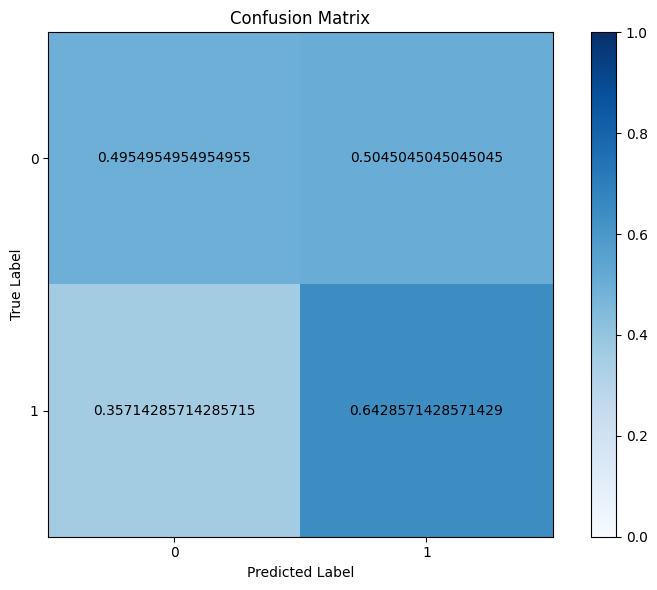

Train tracks shape:  (554, 13)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_54          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7873 - loss: 0.7446 - val_accuracy: 0.8696 - val_loss: 0.5094
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7214 - loss: 0.7822 - val_accuracy: 0.7464 - val_loss: 0.5460
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6579 - loss: 0.6234 - val_accuracy: 0.5217 - val_loss: 0.6575
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 0.6312 - val_accuracy: 0.4493 - val_loss: 0.7043
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5800 - loss: 0.6541 - val_accuracy: 0.4275 - val_loss: 0.7077
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5499 - loss: 0.6312 - val_accuracy: 0.3986 - val_loss: 0.7156
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5530 - loss: 0.6836 - val_accuracy: 0.4058 - val_loss: 0.7219
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4848 - loss: 0.6882 - val_accuracy: 0.3696 - val_loss:

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_104 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5040 - loss: 0.7913 - val_accuracy: 0.3406 - val_loss: 0.8732
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.4797 - loss: 0.7699 - val_accuracy: 0.3841 - val_loss: 0.8107
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.4780 - loss: 0.7539 - val_accuracy: 0.4203 - val_loss: 0.7612
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.4757 - loss: 0.7324 - val_accuracy: 0.4638 - val_loss: 0.7255
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.4602 - loss: 0.7182 - val_accuracy: 0.5000 - val_loss: 0.7014
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.4737 - loss: 0.7068 - val_accuracy: 0.5652 - val_loss: 0.6833
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.4950 - loss: 0.6985 - val_accuracy: 0.6232 - val_loss: 0.6709
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.5460 - loss: 0.6879 - val_accuracy: 0.69

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_105 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6163 - loss: 0.6942 - val_accuracy: 0.7391 - val_loss: 0.5289
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.6310 - loss: 0.6610 - val_accuracy: 0.7391 - val_loss: 0.5382
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.6446 - loss: 0.6687 - val_accuracy: 0.7536 - val_loss: 0.5471
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6143 - loss: 0.6750 - val_accuracy: 0.7536 - val_loss: 0.5534
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.6336 - loss: 0.6444 - val_accuracy: 0.7536 - val_loss: 0.5575
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6297 - loss: 0.6651 - val_accuracy: 0.7464 - val_loss: 0.5622
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.6394 - loss: 0.6423 - val_accuracy: 0.7464 - val_loss: 0.5676
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.6479 - loss: 0.6323 - val_accuracy: 0.75

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_106 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4682 - loss: 1.3528 - val_accuracy: 0.4710 - val_loss: 1.1379
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.4558 - loss: 1.3131 - val_accuracy: 0.4710 - val_loss: 1.0922
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.4943 - loss: 1.1943 - val_accuracy: 0.4783 - val_loss: 1.0480
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.4997 - loss: 1.1228 - val_accuracy: 0.4855 - val_loss: 1.0036
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.5183 - loss: 1.0997 - val_accuracy: 0.5072 - val_loss: 0.9642
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.5201 - loss: 1.0182 - val_accuracy: 0.5145 - val_loss: 0.9326
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.5391 - loss: 0.9904 - val_accuracy: 0.5362 - val_loss: 0.9018
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.5330 - loss: 0.9756 - val_accuracy: 0.52

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_107 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3955 - loss: 1.5521 - val_accuracy: 0.4565 - val_loss: 1.2070
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.3702 - loss: 1.5320 - val_accuracy: 0.4348 - val_loss: 1.1842
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.3721 - loss: 1.4995 - val_accuracy: 0.4275 - val_loss: 1.1629
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.3959 - loss: 1.3929 - val_accuracy: 0.4203 - val_loss: 1.1415
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.3958 - loss: 1.3460 - val_accuracy: 0.4203 - val_loss: 1.1196
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.3812 - loss: 1.3160 - val_accuracy: 0.4130 - val_loss: 1.0984
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.3816 - loss: 1.2292 - val_accuracy: 0.4130 - val_loss: 1.0765
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.3824 - loss: 1.1927 - val_accuracy: 0.40

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_108 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4344 - loss: 1.1484 - val_accuracy: 0.4275 - val_loss: 1.0346
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.4090 - loss: 1.1276 - val_accuracy: 0.4420 - val_loss: 0.9968
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.4442 - loss: 1.0438 - val_accuracy: 0.4493 - val_loss: 0.9610
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.4183 - loss: 1.0698 - val_accuracy: 0.4493 - val_loss: 0.9300
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.4414 - loss: 1.0355 - val_accuracy: 0.4638 - val_loss: 0.9003
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.4522 - loss: 0.9958 - val_accuracy: 0.4638 - val_loss: 0.8708
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.4491 - loss: 0.9697 - val_accuracy: 0.4710 - val_loss: 0.8441
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.4426 - loss: 0.9307 - val_accuracy: 0.47

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_109 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.6277 - val_accuracy: 0.5652 - val_loss: 0.6852
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7651 - loss: 0.6078 - val_accuracy: 0.5652 - val_loss: 0.6755
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7189 - loss: 0.6033 - val_accuracy: 0.6014 - val_loss: 0.6674
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7162 - loss: 0.5847 - val_accuracy: 0.6087 - val_loss: 0.6597
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.7379 - loss: 0.5812 - val_accuracy: 0.6087 - val_loss: 0.6521
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.7255 - loss: 0.5688 - val_accuracy: 0.6159 - val_loss: 0.6474
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.7489 - loss: 0.5616 - val_accuracy: 0.6377 - val_loss: 0.6428
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.7344 - loss: 0.5605 - val_accuracy: 0.63

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_110 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6175 - loss: 0.7412 - val_accuracy: 0.4783 - val_loss: 0.8989
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.6275 - loss: 0.7000 - val_accuracy: 0.4928 - val_loss: 0.8519
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.6525 - loss: 0.6576 - val_accuracy: 0.5000 - val_loss: 0.8126
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.6476 - loss: 0.6366 - val_accuracy: 0.5145 - val_loss: 0.7790
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.6509 - loss: 0.6304 - val_accuracy: 0.5362 - val_loss: 0.7462
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.6538 - loss: 0.6054 - val_accuracy: 0.5580 - val_loss: 0.7189
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.6669 - loss: 0.5907 - val_accuracy: 0.5797 - val_loss: 0.6995
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.6683 - loss: 0.5854 - val_accuracy: 0.57

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_111 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3349 - loss: 0.9756 - val_accuracy: 0.5145 - val_loss: 0.7734
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.3487 - loss: 0.9169 - val_accuracy: 0.4710 - val_loss: 0.7708
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.3591 - loss: 0.8796 - val_accuracy: 0.4420 - val_loss: 0.7675
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.3490 - loss: 0.8536 - val_accuracy: 0.4348 - val_loss: 0.7631
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.3364 - loss: 0.8118 - val_accuracy: 0.4130 - val_loss: 0.7569
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.3452 - loss: 0.7752 - val_accuracy: 0.3841 - val_loss: 0.7496
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.3442 - loss: 0.7535 - val_accuracy: 0.3696 - val_loss: 0.7408
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.4178 - loss: 0.7209 - val_accuracy: 0.31

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_112 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3530 - loss: 1.3925 - val_accuracy: 0.5145 - val_loss: 0.8817
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.3616 - loss: 1.3183 - val_accuracy: 0.5290 - val_loss: 0.8710
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.4318 - loss: 1.2337 - val_accuracy: 0.5435 - val_loss: 0.8595
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.4820 - loss: 1.1372 - val_accuracy: 0.5507 - val_loss: 0.8480
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.4802 - loss: 1.1287 - val_accuracy: 0.5362 - val_loss: 0.8386
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.4990 - loss: 1.0565 - val_accuracy: 0.5290 - val_loss: 0.8279
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.5280 - loss: 1.0249 - val_accuracy: 0.5145 - val_loss: 0.8164
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.5591 - loss: 0.9195 - val_accuracy: 0.53

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_113 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2828 - loss: 1.4759 - val_accuracy: 0.3261 - val_loss: 1.1631
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.2719 - loss: 1.4198 - val_accuracy: 0.3261 - val_loss: 1.1090
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.2837 - loss: 1.3558 - val_accuracy: 0.3188 - val_loss: 1.0589
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.3122 - loss: 1.2949 - val_accuracy: 0.3261 - val_loss: 1.0142
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.2915 - loss: 1.2179 - val_accuracy: 0.3333 - val_loss: 0.9705
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - accuracy: 0.2877 - loss: 1.1821 - val_accuracy: 0.3623 - val_loss: 0.9296
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.2873 - loss: 1.1477 - val_accuracy: 0.3841 - val_loss: 0.8928
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.2860 - loss: 1.1036 - val_accuracy: 0.41

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_114 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6251 - loss: 0.9992 - val_accuracy: 0.4058 - val_loss: 1.1154
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.6252 - loss: 0.9674 - val_accuracy: 0.4058 - val_loss: 1.0621
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.6574 - loss: 0.8719 - val_accuracy: 0.4130 - val_loss: 1.0155
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.6530 - loss: 0.8738 - val_accuracy: 0.4203 - val_loss: 0.9724
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.6815 - loss: 0.7900 - val_accuracy: 0.4420 - val_loss: 0.9319
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.6989 - loss: 0.7053 - val_accuracy: 0.4638 - val_loss: 0.8914
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.7096 - loss: 0.7028 - val_accuracy: 0.4928 - val_loss: 0.8579
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.7082 - loss: 0.6799 - val_accuracy: 0.52

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_115 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3502 - loss: 1.0622 - val_accuracy: 0.4348 - val_loss: 0.8624
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.3896 - loss: 0.9633 - val_accuracy: 0.4203 - val_loss: 0.8409
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.3922 - loss: 0.9378 - val_accuracy: 0.4420 - val_loss: 0.8172
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.4022 - loss: 0.8745 - val_accuracy: 0.4638 - val_loss: 0.7926
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.5352 - loss: 0.8058 - val_accuracy: 0.4855 - val_loss: 0.7726
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.5802 - loss: 0.7895 - val_accuracy: 0.5217 - val_loss: 0.7510
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.6001 - loss: 0.7422 - val_accuracy: 0.5217 - val_loss: 0.7320
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.6068 - loss: 0.7032 - val_accuracy: 0.51

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_116 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3067 - loss: 1.9917 - val_accuracy: 0.3913 - val_loss: 1.4790
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.3012 - loss: 1.9928 - val_accuracy: 0.3913 - val_loss: 1.4105
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.2641 - loss: 1.9309 - val_accuracy: 0.3913 - val_loss: 1.3465
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.2746 - loss: 1.8480 - val_accuracy: 0.3913 - val_loss: 1.2841
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - accuracy: 0.2895 - loss: 1.7224 - val_accuracy: 0.3986 - val_loss: 1.2248
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.2871 - loss: 1.6424 - val_accuracy: 0.3986 - val_loss: 1.1671
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.2761 - loss: 1.5540 - val_accuracy: 0.4058 - val_loss: 1.1108
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.2939 - loss: 1.4624 - val_accuracy: 0.40

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_117 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6593 - loss: 0.7310 - val_accuracy: 0.5870 - val_loss: 0.7486
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.6687 - loss: 0.6693 - val_accuracy: 0.6014 - val_loss: 0.7150
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.6820 - loss: 0.6447 - val_accuracy: 0.6087 - val_loss: 0.6853
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.6644 - loss: 0.6620 - val_accuracy: 0.6232 - val_loss: 0.6617
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.6814 - loss: 0.5988 - val_accuracy: 0.6377 - val_loss: 0.6456
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.6883 - loss: 0.5971 - val_accuracy: 0.6449 - val_loss: 0.6306
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7007 - loss: 0.5446 - val_accuracy: 0.6522 - val_loss: 0.6219
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.6983 - loss: 0.5489 - val_accuracy: 0.65

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_118 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7567 - loss: 0.4857 - val_accuracy: 0.6812 - val_loss: 0.5986
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.7756 - loss: 0.4523 - val_accuracy: 0.6957 - val_loss: 0.5976
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.7624 - loss: 0.4632 - val_accuracy: 0.6884 - val_loss: 0.5951
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.7784 - loss: 0.4534 - val_accuracy: 0.6957 - val_loss: 0.5928
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.7861 - loss: 0.4299 - val_accuracy: 0.7029 - val_loss: 0.5945
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.7883 - loss: 0.4481 - val_accuracy: 0.7101 - val_loss: 0.5956
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.8037 - loss: 0.4166 - val_accuracy: 0.6957 - val_loss: 0.5971
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.7997 - loss: 0.4216 - val_accuracy: 0.68

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_119 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 0.6596 - val_accuracy: 0.6812 - val_loss: 0.6095
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.6531 - loss: 0.6285 - val_accuracy: 0.6667 - val_loss: 0.6127
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.6820 - loss: 0.5960 - val_accuracy: 0.6739 - val_loss: 0.6129
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6450 - loss: 0.6040 - val_accuracy: 0.6739 - val_loss: 0.6134
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7050 - loss: 0.5583 - val_accuracy: 0.6594 - val_loss: 0.6138
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.7079 - loss: 0.5478 - val_accuracy: 0.6594 - val_loss: 0.6129
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.6950 - loss: 0.5366 - val_accuracy: 0.6594 - val_loss: 0.6128
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.7375 - loss: 0.5206 - val_accuracy: 0.65

Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_120 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6251 - loss: 0.6527 - val_accuracy: 0.4565 - val_loss: 0.8108
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7119 - loss: 0.6125 - val_accuracy: 0.4855 - val_loss: 0.7711
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.7009 - loss: 0.5986 - val_accuracy: 0.5290 - val_loss: 0.7408
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.7454 - loss: 0.5581 - val_accuracy: 0.5725 - val_loss: 0.7172
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.7460 - loss: 0.5405 - val_accuracy: 0.6014 - val_loss: 0.6952
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.7505 - loss: 0.5313 - val_accuracy: 0.6014 - val_loss: 0.6778
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7776 - loss: 0.5177 - val_accuracy: 0.6159 - val_loss: 0.6642
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.7931 - loss: 0.4993 - val_accuracy: 0.65

Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_121 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7628 - loss: 0.4835 - val_accuracy: 0.7101 - val_loss: 0.5627
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.7892 - loss: 0.4704 - val_accuracy: 0.7101 - val_loss: 0.5614
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.7770 - loss: 0.4577 - val_accuracy: 0.7174 - val_loss: 0.5589
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.7803 - loss: 0.4597 - val_accuracy: 0.7174 - val_loss: 0.5563
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.8165 - loss: 0.4274 - val_accuracy: 0.7174 - val_loss: 0.5554
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.8047 - loss: 0.4276 - val_accuracy: 0.7029 - val_loss: 0.5550
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.7968 - loss: 0.4328 - val_accuracy: 0.7101 - val_loss: 0.5531
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.8139 - loss: 0.4292 - val_accuracy: 0.70

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_122 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6781 - loss: 0.6129 - val_accuracy: 0.6087 - val_loss: 0.6522
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.7493 - loss: 0.5622 - val_accuracy: 0.6014 - val_loss: 0.6346
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.7600 - loss: 0.5379 - val_accuracy: 0.6014 - val_loss: 0.6227
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.7953 - loss: 0.5132 - val_accuracy: 0.6159 - val_loss: 0.6158
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.7941 - loss: 0.5039 - val_accuracy: 0.6377 - val_loss: 0.6079
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.7635 - loss: 0.5139 - val_accuracy: 0.6594 - val_loss: 0.6039
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - accuracy: 0.7982 - loss: 0.4884 - val_accuracy: 0.6449 - val_loss: 0.6043
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7857 - loss: 0.4903 - val_accuracy: 0.64

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_123 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3181 - loss: 1.0858 - val_accuracy: 0.4493 - val_loss: 0.7823
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.3439 - loss: 0.9905 - val_accuracy: 0.4275 - val_loss: 0.7876
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.3241 - loss: 0.9728 - val_accuracy: 0.4493 - val_loss: 0.7912
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.3407 - loss: 0.9218 - val_accuracy: 0.4130 - val_loss: 0.7918
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.3357 - loss: 0.8725 - val_accuracy: 0.3913 - val_loss: 0.7903
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.3450 - loss: 0.8494 - val_accuracy: 0.3623 - val_loss: 0.7844
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.3945 - loss: 0.7931 - val_accuracy: 0.3696 - val_loss: 0.7763
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.4121 - loss: 0.7699 - val_accuracy: 0.37

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_124 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7257 - loss: 0.6038 - val_accuracy: 0.5652 - val_loss: 0.8713
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.7582 - loss: 0.5206 - val_accuracy: 0.5725 - val_loss: 0.8302
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.7540 - loss: 0.5310 - val_accuracy: 0.5870 - val_loss: 0.7905
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.7558 - loss: 0.4993 - val_accuracy: 0.5942 - val_loss: 0.7572
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.7635 - loss: 0.4833 - val_accuracy: 0.6159 - val_loss: 0.7303
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.7586 - loss: 0.4700 - val_accuracy: 0.6087 - val_loss: 0.7089
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.7666 - loss: 0.4499 - val_accuracy: 0.6087 - val_loss: 0.6929
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.7698 - loss: 0.4679 - val_accuracy: 0.61

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_125 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7011 - loss: 0.7427 - val_accuracy: 0.5217 - val_loss: 1.0138
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.6821 - loss: 0.6958 - val_accuracy: 0.5290 - val_loss: 0.9539
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.7250 - loss: 0.6459 - val_accuracy: 0.5652 - val_loss: 0.9004
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.7268 - loss: 0.6446 - val_accuracy: 0.5580 - val_loss: 0.8499
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.7379 - loss: 0.5803 - val_accuracy: 0.5652 - val_loss: 0.8028
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.7569 - loss: 0.5501 - val_accuracy: 0.5870 - val_loss: 0.7655
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.7130 - loss: 0.5953 - val_accuracy: 0.6014 - val_loss: 0.7316
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.7603 - loss: 0.5217 - val_accuracy: 0.62

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_126 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1563 - loss: 1.0235 - val_accuracy: 0.3406 - val_loss: 0.7747
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.1644 - loss: 0.9557 - val_accuracy: 0.3261 - val_loss: 0.7604
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.1675 - loss: 0.8841 - val_accuracy: 0.3043 - val_loss: 0.7454
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.1394 - loss: 0.8206 - val_accuracy: 0.3116 - val_loss: 0.7300
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.1501 - loss: 0.7641 - val_accuracy: 0.2754 - val_loss: 0.7155
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.2893 - loss: 0.7132 - val_accuracy: 0.2826 - val_loss: 0.7024
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.7127 - loss: 0.6692 - val_accuracy: 0.5290 - val_loss: 0.6907
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.8277 - loss: 0.6346 - val_accuracy: 0.62

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_127 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5313 - loss: 0.6427 - val_accuracy: 0.6812 - val_loss: 0.6299
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6169 - loss: 0.6002 - val_accuracy: 0.6304 - val_loss: 0.6371
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6544 - loss: 0.5820 - val_accuracy: 0.6159 - val_loss: 0.6432
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.7140 - loss: 0.5449 - val_accuracy: 0.6159 - val_loss: 0.6483
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.7305 - loss: 0.5245 - val_accuracy: 0.6159 - val_loss: 0.6528
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.7564 - loss: 0.5080 - val_accuracy: 0.6087 - val_loss: 0.6570
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.8003 - loss: 0.4734 - val_accuracy: 0.6087 - val_loss: 0.6609
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.7980 - loss: 0.4722 - val_accuracy: 0.60

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_128 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.5313 - val_accuracy: 0.6304 - val_loss: 0.6447
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.7890 - loss: 0.5170 - val_accuracy: 0.6377 - val_loss: 0.6346
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.7915 - loss: 0.4968 - val_accuracy: 0.6667 - val_loss: 0.6255
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.8101 - loss: 0.4728 - val_accuracy: 0.6812 - val_loss: 0.6175
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.8349 - loss: 0.4288 - val_accuracy: 0.6812 - val_loss: 0.6138
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.8102 - loss: 0.4442 - val_accuracy: 0.7174 - val_loss: 0.6096
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.8258 - loss: 0.4246 - val_accuracy: 0.7246 - val_loss: 0.6056
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.8326 - loss: 0.4145 - val_accuracy: 0.72

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_129 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2032 - loss: 0.9053 - val_accuracy: 0.2971 - val_loss: 0.7912
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.2044 - loss: 0.8548 - val_accuracy: 0.3043 - val_loss: 0.7603
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.2171 - loss: 0.8023 - val_accuracy: 0.3116 - val_loss: 0.7328
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.2560 - loss: 0.7587 - val_accuracy: 0.4348 - val_loss: 0.7100
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.3498 - loss: 0.7198 - val_accuracy: 0.5507 - val_loss: 0.6909
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6311 - loss: 0.6800 - val_accuracy: 0.6449 - val_loss: 0.6759
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.7516 - loss: 0.6484 - val_accuracy: 0.6594 - val_loss: 0.6633
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.7803 - loss: 0.6225 - val_accuracy: 0.70

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_130 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8149 - loss: 0.3280 - val_accuracy: 0.7101 - val_loss: 0.6215
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.8123 - loss: 0.3404 - val_accuracy: 0.7101 - val_loss: 0.6280
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.8459 - loss: 0.3182 - val_accuracy: 0.7029 - val_loss: 0.6368
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.8204 - loss: 0.3359 - val_accuracy: 0.7029 - val_loss: 0.6434
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8228 - loss: 0.3316 - val_accuracy: 0.6957 - val_loss: 0.6475
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.8275 - loss: 0.3335 - val_accuracy: 0.6957 - val_loss: 0.6535
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8543 - loss: 0.2999 - val_accuracy: 0.6884 - val_loss: 0.6625
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8490 - loss: 0.3214 - val_accuracy: 0.68

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_131 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7220 - loss: 0.6072 - val_accuracy: 0.6377 - val_loss: 0.6475
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.8022 - loss: 0.5590 - val_accuracy: 0.6739 - val_loss: 0.6369
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.8118 - loss: 0.5316 - val_accuracy: 0.6812 - val_loss: 0.6292
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.8139 - loss: 0.5087 - val_accuracy: 0.6884 - val_loss: 0.6227
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8314 - loss: 0.4950 - val_accuracy: 0.6884 - val_loss: 0.6169
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.8101 - loss: 0.4749 - val_accuracy: 0.6884 - val_loss: 0.6137
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8508 - loss: 0.4433 - val_accuracy: 0.6884 - val_loss: 0.6118
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.7994 - loss: 0.4553 - val_accuracy: 0.68

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_132 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1715 - loss: 1.9790 - val_accuracy: 0.3841 - val_loss: 1.1673
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.1915 - loss: 1.8360 - val_accuracy: 0.3841 - val_loss: 1.1286
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.1767 - loss: 1.7862 - val_accuracy: 0.3841 - val_loss: 1.0918
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.1866 - loss: 1.7015 - val_accuracy: 0.3841 - val_loss: 1.0525
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.1966 - loss: 1.5757 - val_accuracy: 0.3768 - val_loss: 1.0180
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.1924 - loss: 1.5333 - val_accuracy: 0.3768 - val_loss: 0.9850
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.1703 - loss: 1.4714 - val_accuracy: 0.3696 - val_loss: 0.9509
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.1645 - loss: 1.3756 - val_accuracy: 0.37

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_133 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.4825 - val_accuracy: 0.7174 - val_loss: 0.5591
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.7720 - loss: 0.4680 - val_accuracy: 0.7174 - val_loss: 0.5646
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.7384 - loss: 0.4795 - val_accuracy: 0.7029 - val_loss: 0.5683
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.7750 - loss: 0.4603 - val_accuracy: 0.7029 - val_loss: 0.5710
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.7752 - loss: 0.4530 - val_accuracy: 0.7029 - val_loss: 0.5724
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - accuracy: 0.7797 - loss: 0.4333 - val_accuracy: 0.7029 - val_loss: 0.5715
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.7822 - loss: 0.4269 - val_accuracy: 0.7029 - val_loss: 0.5767
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.7714 - loss: 0.4287 - val_accuracy: 0.70

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_134 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2373 - loss: 1.6172 - val_accuracy: 0.2971 - val_loss: 1.3439
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 0.2177 - loss: 1.5740 - val_accuracy: 0.3043 - val_loss: 1.2713
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.2009 - loss: 1.5331 - val_accuracy: 0.3043 - val_loss: 1.2011
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.2076 - loss: 1.4433 - val_accuracy: 0.3043 - val_loss: 1.1390
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - accuracy: 0.2371 - loss: 1.3594 - val_accuracy: 0.3116 - val_loss: 1.0814
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.2029 - loss: 1.3125 - val_accuracy: 0.3116 - val_loss: 1.0254
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.2035 - loss: 1.2393 - val_accuracy: 0.3188 - val_loss: 0.9740
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.2039 - loss: 1.1884 - val_accuracy: 0.31

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_135 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7419 - loss: 0.5278 - val_accuracy: 0.6449 - val_loss: 0.6383
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.7713 - loss: 0.4839 - val_accuracy: 0.6232 - val_loss: 0.6539
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.7735 - loss: 0.4768 - val_accuracy: 0.6087 - val_loss: 0.6636
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7861 - loss: 0.4563 - val_accuracy: 0.5870 - val_loss: 0.6739
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.7956 - loss: 0.4393 - val_accuracy: 0.5942 - val_loss: 0.6844
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.7993 - loss: 0.4188 - val_accuracy: 0.5725 - val_loss: 0.6919
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.7704 - loss: 0.4213 - val_accuracy: 0.5725 - val_loss: 0.7009
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.7680 - loss: 0.4265 - val_accuracy: 0.56

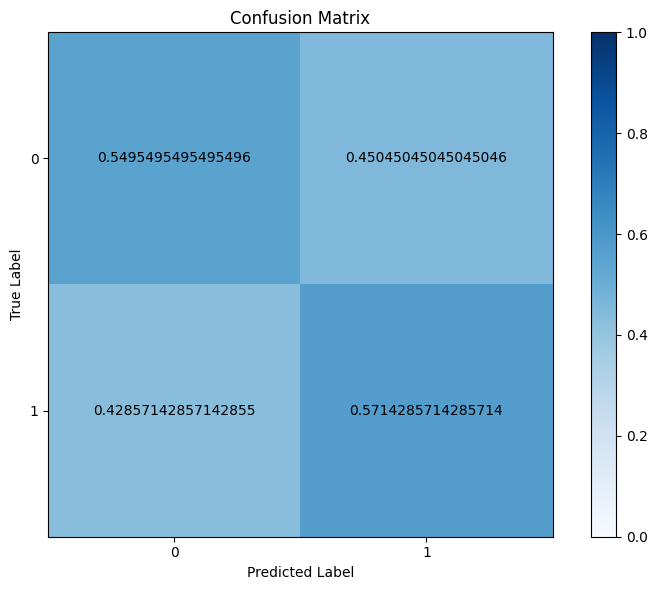

Train tracks shape:  (664, 13)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_65          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_137 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7782 - loss: 0.7199 - val_accuracy: 0.8696 - val_loss: 0.4743
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7025 - loss: 0.6690 - val_accuracy: 0.6957 - val_loss: 0.5891
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6243 - loss: 0.6387 - val_accuracy: 0.4565 - val_loss: 0.7102
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5766 - loss: 0.6249 - val_accuracy: 0.4130 - val_loss: 0.7430
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.5152 - loss: 0.6686 - val_accuracy: 0.3913 - val_loss: 0.7331
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5201 - loss: 0.6503 - val_accuracy: 0.4058 - val_loss: 0.7261
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.5319 - loss: 0.6409 - val_accuracy: 0.4130 - val_loss: 0.7153
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5323 - loss: 0.6446 - val_accuracy: 0.4275 - val_l

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_145 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4233 - loss: 0.8091 - val_accuracy: 0.3913 - val_loss: 0.7922
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.4393 - loss: 0.7662 - val_accuracy: 0.4203 - val_loss: 0.7540
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.4715 - loss: 0.7406 - val_accuracy: 0.4275 - val_loss: 0.7234
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.4765 - loss: 0.7187 - val_accuracy: 0.4783 - val_loss: 0.7006
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.5164 - loss: 0.6968 - val_accuracy: 0.5290 - val_loss: 0.6805
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.5834 - loss: 0.6797 - val_accuracy: 0.5942 - val_loss: 0.6669
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.6099 - loss: 0.6604 - val_accuracy: 0.6159 - val_loss: 0.6555
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.5986 - loss: 0.6584 - val_accuracy: 0.65

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_146 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6193 - loss: 0.6854 - val_accuracy: 0.5725 - val_loss: 0.6974
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.6115 - loss: 0.6824 - val_accuracy: 0.5942 - val_loss: 0.6863
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.6138 - loss: 0.6859 - val_accuracy: 0.6014 - val_loss: 0.6759
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6373 - loss: 0.6577 - val_accuracy: 0.6377 - val_loss: 0.6693
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6019 - loss: 0.6758 - val_accuracy: 0.6522 - val_loss: 0.6617
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6284 - loss: 0.6616 - val_accuracy: 0.6594 - val_loss: 0.6561
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.6532 - loss: 0.6372 - val_accuracy: 0.6594 - val_loss: 0.6499
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.6318 - loss: 0.6459 - val_accuracy: 0.66

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_147 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5236 - loss: 1.3707 - val_accuracy: 0.5942 - val_loss: 0.8855
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.5165 - loss: 1.3211 - val_accuracy: 0.5870 - val_loss: 0.8867
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.5158 - loss: 1.1812 - val_accuracy: 0.5797 - val_loss: 0.8880
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.5110 - loss: 1.1446 - val_accuracy: 0.5797 - val_loss: 0.8863
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.5180 - loss: 1.1499 - val_accuracy: 0.5580 - val_loss: 0.8826
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5453 - loss: 1.0627 - val_accuracy: 0.5580 - val_loss: 0.8760
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.5375 - loss: 1.0432 - val_accuracy: 0.5580 - val_loss: 0.8688
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.5522 - loss: 0.9508 - val_accuracy: 0.54

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_148 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3544 - loss: 1.2401 - val_accuracy: 0.3333 - val_loss: 1.0294
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.3388 - loss: 1.1968 - val_accuracy: 0.3333 - val_loss: 1.0044
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.3481 - loss: 1.1726 - val_accuracy: 0.3188 - val_loss: 0.9778
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.3338 - loss: 1.1192 - val_accuracy: 0.3188 - val_loss: 0.9566
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.3197 - loss: 1.0951 - val_accuracy: 0.3188 - val_loss: 0.9334
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.3487 - loss: 1.0715 - val_accuracy: 0.3188 - val_loss: 0.9157
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.3243 - loss: 1.0249 - val_accuracy: 0.3188 - val_loss: 0.8969
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.3352 - loss: 0.9921 - val_accuracy: 0.31

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_149 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4024 - loss: 1.3679 - val_accuracy: 0.4638 - val_loss: 0.9180
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.3772 - loss: 1.3250 - val_accuracy: 0.4420 - val_loss: 0.9123
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.3879 - loss: 1.1975 - val_accuracy: 0.4058 - val_loss: 0.9087
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.3652 - loss: 1.2001 - val_accuracy: 0.3986 - val_loss: 0.9037
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.3712 - loss: 1.1343 - val_accuracy: 0.4058 - val_loss: 0.8954
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.3744 - loss: 1.1059 - val_accuracy: 0.3986 - val_loss: 0.8864
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.3671 - loss: 1.0599 - val_accuracy: 0.3913 - val_loss: 0.8746
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.3733 - loss: 1.0225 - val_accuracy: 0.36

Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_150 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7224 - loss: 0.6473 - val_accuracy: 0.7029 - val_loss: 0.6494
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.7146 - loss: 0.6269 - val_accuracy: 0.7029 - val_loss: 0.6377
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7146 - loss: 0.6112 - val_accuracy: 0.6957 - val_loss: 0.6296
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.7320 - loss: 0.5994 - val_accuracy: 0.7029 - val_loss: 0.6241
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6856 - loss: 0.6125 - val_accuracy: 0.7029 - val_loss: 0.6198
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.7171 - loss: 0.5983 - val_accuracy: 0.7101 - val_loss: 0.6170
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.6973 - loss: 0.5949 - val_accuracy: 0.7101 - val_loss: 0.6162
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.7119 - loss: 0.5777 - val_accuracy: 0.70

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_151 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6338 - loss: 0.7385 - val_accuracy: 0.4783 - val_loss: 0.8866
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.6081 - loss: 0.7258 - val_accuracy: 0.4855 - val_loss: 0.8468
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.6209 - loss: 0.7213 - val_accuracy: 0.4855 - val_loss: 0.8095
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6215 - loss: 0.6875 - val_accuracy: 0.5217 - val_loss: 0.7819
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.6326 - loss: 0.6699 - val_accuracy: 0.5217 - val_loss: 0.7581
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6436 - loss: 0.6429 - val_accuracy: 0.5217 - val_loss: 0.7365
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6315 - loss: 0.6516 - val_accuracy: 0.5290 - val_loss: 0.7180
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6439 - loss: 0.6386 - val_accuracy: 0.53

Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_152 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3919 - loss: 0.9093 - val_accuracy: 0.5507 - val_loss: 0.7225
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.3892 - loss: 0.8496 - val_accuracy: 0.5290 - val_loss: 0.7310
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.3884 - loss: 0.8136 - val_accuracy: 0.5072 - val_loss: 0.7382
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.4094 - loss: 0.7793 - val_accuracy: 0.4565 - val_loss: 0.7407
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.3953 - loss: 0.7615 - val_accuracy: 0.3913 - val_loss: 0.7397
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.4282 - loss: 0.7381 - val_accuracy: 0.3841 - val_loss: 0.7359
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.4433 - loss: 0.7162 - val_accuracy: 0.3696 - val_loss: 0.7287
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.5140 - loss: 0.6983 - val_accuracy: 0.38

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_153 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3543 - loss: 1.3428 - val_accuracy: 0.3261 - val_loss: 1.2708
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.3561 - loss: 1.2467 - val_accuracy: 0.3478 - val_loss: 1.1739
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.4020 - loss: 1.1908 - val_accuracy: 0.3623 - val_loss: 1.0897
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.4233 - loss: 1.1247 - val_accuracy: 0.3841 - val_loss: 1.0143
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.4468 - loss: 1.0210 - val_accuracy: 0.3986 - val_loss: 0.9463
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.4499 - loss: 1.0150 - val_accuracy: 0.3986 - val_loss: 0.8904
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.4852 - loss: 0.9333 - val_accuracy: 0.4130 - val_loss: 0.8426
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.4640 - loss: 0.9065 - val_accuracy: 0.44

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_154 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3712 - loss: 1.5145 - val_accuracy: 0.6522 - val_loss: 0.7445
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.3874 - loss: 1.4782 - val_accuracy: 0.6377 - val_loss: 0.7510
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.3716 - loss: 1.3831 - val_accuracy: 0.6304 - val_loss: 0.7591
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.3659 - loss: 1.2869 - val_accuracy: 0.6304 - val_loss: 0.7678
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.3780 - loss: 1.2224 - val_accuracy: 0.6159 - val_loss: 0.7766
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.3983 - loss: 1.1301 - val_accuracy: 0.5870 - val_loss: 0.7834
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.4021 - loss: 1.0873 - val_accuracy: 0.5870 - val_loss: 0.7908
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.4164 - loss: 1.0383 - val_accuracy: 0.57

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_155 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6591 - loss: 0.7872 - val_accuracy: 0.3913 - val_loss: 1.1186
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.6657 - loss: 0.7237 - val_accuracy: 0.4348 - val_loss: 1.0483
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.6421 - loss: 0.7356 - val_accuracy: 0.4565 - val_loss: 0.9799
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.6722 - loss: 0.6793 - val_accuracy: 0.4783 - val_loss: 0.9229
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6675 - loss: 0.6723 - val_accuracy: 0.5217 - val_loss: 0.8767
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.6915 - loss: 0.6164 - val_accuracy: 0.5362 - val_loss: 0.8402
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7064 - loss: 0.6074 - val_accuracy: 0.5362 - val_loss: 0.8079
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7109 - loss: 0.6005 - val_accuracy: 0.52

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_156 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2428 - loss: 1.1249 - val_accuracy: 0.4058 - val_loss: 0.7947
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.2746 - loss: 1.0298 - val_accuracy: 0.4058 - val_loss: 0.7845
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.3080 - loss: 0.9674 - val_accuracy: 0.3913 - val_loss: 0.7739
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.3524 - loss: 0.9214 - val_accuracy: 0.4058 - val_loss: 0.7616
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.3754 - loss: 0.8656 - val_accuracy: 0.4275 - val_loss: 0.7500
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.4010 - loss: 0.8248 - val_accuracy: 0.4348 - val_loss: 0.7372
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.4491 - loss: 0.7884 - val_accuracy: 0.4638 - val_loss: 0.7246
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.4738 - loss: 0.7618 - val_accuracy: 0.49

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_157 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2800 - loss: 1.8543 - val_accuracy: 0.4855 - val_loss: 1.1208
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.2801 - loss: 1.7406 - val_accuracy: 0.4710 - val_loss: 1.0973
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.2727 - loss: 1.6949 - val_accuracy: 0.4710 - val_loss: 1.0726
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.2672 - loss: 1.5440 - val_accuracy: 0.4493 - val_loss: 1.0492
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.2680 - loss: 1.4846 - val_accuracy: 0.4348 - val_loss: 1.0249
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.2886 - loss: 1.3850 - val_accuracy: 0.4275 - val_loss: 1.0012
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.2724 - loss: 1.3459 - val_accuracy: 0.4058 - val_loss: 0.9764
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.2925 - loss: 1.2311 - val_accuracy: 0.40

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_158 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5794 - loss: 0.8783 - val_accuracy: 0.4493 - val_loss: 1.0334
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.5950 - loss: 0.8004 - val_accuracy: 0.4420 - val_loss: 0.9760
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.5988 - loss: 0.8102 - val_accuracy: 0.4710 - val_loss: 0.9229
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6376 - loss: 0.7327 - val_accuracy: 0.4710 - val_loss: 0.8740
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.6279 - loss: 0.7022 - val_accuracy: 0.4928 - val_loss: 0.8336
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.6469 - loss: 0.6744 - val_accuracy: 0.5145 - val_loss: 0.7968
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6633 - loss: 0.6347 - val_accuracy: 0.5507 - val_loss: 0.7695
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6383 - loss: 0.6419 - val_accuracy: 0.58

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_159 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.5247 - val_accuracy: 0.6159 - val_loss: 0.6609
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.7607 - loss: 0.5208 - val_accuracy: 0.6087 - val_loss: 0.6513
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.7507 - loss: 0.5061 - val_accuracy: 0.6159 - val_loss: 0.6456
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7556 - loss: 0.5174 - val_accuracy: 0.6232 - val_loss: 0.6402
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.7674 - loss: 0.4986 - val_accuracy: 0.6304 - val_loss: 0.6371
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7691 - loss: 0.4885 - val_accuracy: 0.6304 - val_loss: 0.6374
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.7788 - loss: 0.4751 - val_accuracy: 0.6304 - val_loss: 0.6341
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.7311 - loss: 0.5343 - val_accuracy: 0.62

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_160 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5403 - loss: 0.7330 - val_accuracy: 0.6449 - val_loss: 0.6114
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.5975 - loss: 0.6919 - val_accuracy: 0.6377 - val_loss: 0.6089
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.6168 - loss: 0.6362 - val_accuracy: 0.6232 - val_loss: 0.6067
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.6364 - loss: 0.6102 - val_accuracy: 0.6232 - val_loss: 0.6050
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6371 - loss: 0.5953 - val_accuracy: 0.6304 - val_loss: 0.6029
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6766 - loss: 0.5792 - val_accuracy: 0.6449 - val_loss: 0.6011
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.7077 - loss: 0.5478 - val_accuracy: 0.6522 - val_loss: 0.5985
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.7367 - loss: 0.5251 - val_accuracy: 0.65

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_161 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6543 - loss: 0.6946 - val_accuracy: 0.5217 - val_loss: 0.8973
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.6820 - loss: 0.6726 - val_accuracy: 0.5362 - val_loss: 0.8373
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7008 - loss: 0.6371 - val_accuracy: 0.5870 - val_loss: 0.7872
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.7109 - loss: 0.5742 - val_accuracy: 0.6014 - val_loss: 0.7466
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7479 - loss: 0.5343 - val_accuracy: 0.6087 - val_loss: 0.7136
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7350 - loss: 0.5347 - val_accuracy: 0.6377 - val_loss: 0.6910
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7427 - loss: 0.5354 - val_accuracy: 0.6594 - val_loss: 0.6734
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.7798 - loss: 0.5106 - val_accuracy: 0.65

Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_162 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7886 - loss: 0.4529 - val_accuracy: 0.6159 - val_loss: 0.6779
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.7925 - loss: 0.4686 - val_accuracy: 0.6159 - val_loss: 0.6799
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7870 - loss: 0.4668 - val_accuracy: 0.6159 - val_loss: 0.6807
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.8047 - loss: 0.4498 - val_accuracy: 0.6159 - val_loss: 0.6784
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.7910 - loss: 0.4360 - val_accuracy: 0.6304 - val_loss: 0.6776
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.7891 - loss: 0.4496 - val_accuracy: 0.6304 - val_loss: 0.6771
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7933 - loss: 0.4617 - val_accuracy: 0.6304 - val_loss: 0.6808
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.8140 - loss: 0.4261 - val_accuracy: 0.63

Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_163 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8109 - loss: 0.5086 - val_accuracy: 0.6739 - val_loss: 0.6023
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.8265 - loss: 0.4638 - val_accuracy: 0.6884 - val_loss: 0.5986
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.8347 - loss: 0.4437 - val_accuracy: 0.6739 - val_loss: 0.5998
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.8201 - loss: 0.4535 - val_accuracy: 0.6812 - val_loss: 0.5995
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.8449 - loss: 0.4408 - val_accuracy: 0.6884 - val_loss: 0.6001
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.8443 - loss: 0.4323 - val_accuracy: 0.6884 - val_loss: 0.6006
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.8145 - loss: 0.4462 - val_accuracy: 0.6884 - val_loss: 0.6017
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8307 - loss: 0.4241 - val_accuracy: 0.68

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_164 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3238 - loss: 0.9369 - val_accuracy: 0.3623 - val_loss: 0.8185
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.4366 - loss: 0.8660 - val_accuracy: 0.3768 - val_loss: 0.7933
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.4336 - loss: 0.8314 - val_accuracy: 0.3841 - val_loss: 0.7692
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.4656 - loss: 0.7851 - val_accuracy: 0.3913 - val_loss: 0.7510
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.5100 - loss: 0.7306 - val_accuracy: 0.3913 - val_loss: 0.7360
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.5459 - loss: 0.6901 - val_accuracy: 0.4420 - val_loss: 0.7213
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.5562 - loss: 0.6725 - val_accuracy: 0.4855 - val_loss: 0.7105
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.5768 - loss: 0.6423 - val_accuracy: 0.47

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_165 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8145 - loss: 0.4414 - val_accuracy: 0.6667 - val_loss: 0.6820
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.8276 - loss: 0.4245 - val_accuracy: 0.6739 - val_loss: 0.6846
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8255 - loss: 0.4257 - val_accuracy: 0.6812 - val_loss: 0.6839
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8384 - loss: 0.4003 - val_accuracy: 0.6884 - val_loss: 0.6863
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.8375 - loss: 0.4073 - val_accuracy: 0.6884 - val_loss: 0.6843
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.8358 - loss: 0.4078 - val_accuracy: 0.6884 - val_loss: 0.6840
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.8362 - loss: 0.4003 - val_accuracy: 0.6812 - val_loss: 0.6862
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8357 - loss: 0.3809 - val_accuracy: 0.68

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_166 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7201 - loss: 0.6923 - val_accuracy: 0.5725 - val_loss: 0.8347
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.7314 - loss: 0.6348 - val_accuracy: 0.5725 - val_loss: 0.8288
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.7239 - loss: 0.6298 - val_accuracy: 0.5797 - val_loss: 0.8225
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7319 - loss: 0.6020 - val_accuracy: 0.5942 - val_loss: 0.8134
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.7364 - loss: 0.5713 - val_accuracy: 0.6014 - val_loss: 0.8008
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.7401 - loss: 0.5427 - val_accuracy: 0.6232 - val_loss: 0.7900
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.7667 - loss: 0.4969 - val_accuracy: 0.6232 - val_loss: 0.7816
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.7708 - loss: 0.4963 - val_accuracy: 0.61

Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_167 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1929 - loss: 0.9851 - val_accuracy: 0.3261 - val_loss: 0.8179
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.1995 - loss: 0.9055 - val_accuracy: 0.3333 - val_loss: 0.7778
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.1882 - loss: 0.8432 - val_accuracy: 0.3333 - val_loss: 0.7427
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.2163 - loss: 0.7789 - val_accuracy: 0.3261 - val_loss: 0.7138
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.2641 - loss: 0.7273 - val_accuracy: 0.6304 - val_loss: 0.6903
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.6386 - loss: 0.6838 - val_accuracy: 0.7029 - val_loss: 0.6704
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.7858 - loss: 0.6467 - val_accuracy: 0.6957 - val_loss: 0.6548
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.8103 - loss: 0.6113 - val_accuracy: 0.68

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_168 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5697 - loss: 0.6648 - val_accuracy: 0.3986 - val_loss: 0.7634
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.6210 - loss: 0.6281 - val_accuracy: 0.4420 - val_loss: 0.7344
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.6971 - loss: 0.5914 - val_accuracy: 0.5145 - val_loss: 0.7140
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6946 - loss: 0.5737 - val_accuracy: 0.5435 - val_loss: 0.6995
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7303 - loss: 0.5506 - val_accuracy: 0.5870 - val_loss: 0.6845
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7393 - loss: 0.5475 - val_accuracy: 0.6232 - val_loss: 0.6738
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.7802 - loss: 0.5150 - val_accuracy: 0.6304 - val_loss: 0.6690
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.8003 - loss: 0.4903 - val_accuracy: 0.64

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_169 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7975 - loss: 0.5282 - val_accuracy: 0.6449 - val_loss: 0.6564
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.8156 - loss: 0.4914 - val_accuracy: 0.6377 - val_loss: 0.6549
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.8271 - loss: 0.4701 - val_accuracy: 0.6594 - val_loss: 0.6546
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.8309 - loss: 0.4511 - val_accuracy: 0.6594 - val_loss: 0.6556
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.8307 - loss: 0.4510 - val_accuracy: 0.6594 - val_loss: 0.6544
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.8269 - loss: 0.4297 - val_accuracy: 0.6667 - val_loss: 0.6542
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8275 - loss: 0.4228 - val_accuracy: 0.6522 - val_loss: 0.6591
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.8146 - loss: 0.4267 - val_accuracy: 0.65

Model: "sequential_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_170 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1909 - loss: 0.9819 - val_accuracy: 0.4638 - val_loss: 0.7339
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.1968 - loss: 0.9023 - val_accuracy: 0.4348 - val_loss: 0.7321
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.1572 - loss: 0.8409 - val_accuracy: 0.3623 - val_loss: 0.7289
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.1870 - loss: 0.7641 - val_accuracy: 0.2246 - val_loss: 0.7233
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.3187 - loss: 0.7154 - val_accuracy: 0.2029 - val_loss: 0.7161
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6342 - loss: 0.6698 - val_accuracy: 0.4493 - val_loss: 0.7077
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7788 - loss: 0.6309 - val_accuracy: 0.5217 - val_loss: 0.6992
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.8114 - loss: 0.6018 - val_accuracy: 0.55

Model: "sequential_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_171 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5649 - loss: 0.7957 - val_accuracy: 0.4855 - val_loss: 0.9576
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.6593 - loss: 0.7233 - val_accuracy: 0.5072 - val_loss: 0.8987
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6895 - loss: 0.6921 - val_accuracy: 0.5290 - val_loss: 0.8499
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7238 - loss: 0.6546 - val_accuracy: 0.5580 - val_loss: 0.8068
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.7263 - loss: 0.6076 - val_accuracy: 0.5652 - val_loss: 0.7702
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.7242 - loss: 0.5803 - val_accuracy: 0.5725 - val_loss: 0.7377
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.7502 - loss: 0.5359 - val_accuracy: 0.5942 - val_loss: 0.7139
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.7599 - loss: 0.5234 - val_accuracy: 0.59

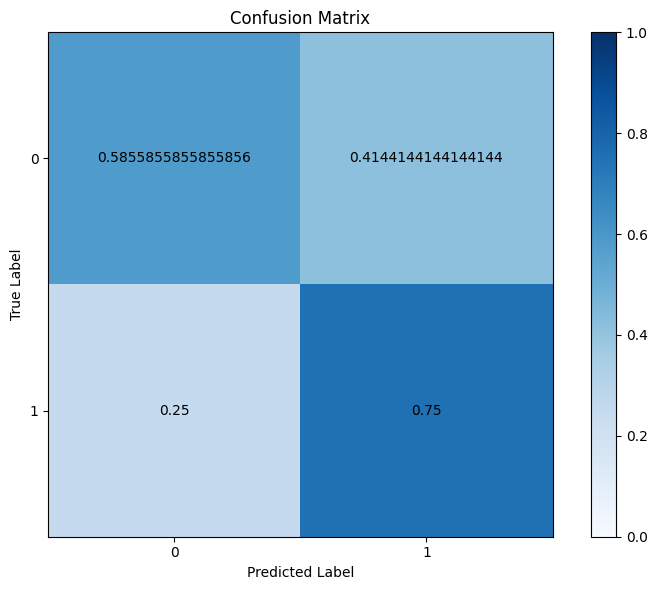

Train tracks shape:  (775, 13)


Model: "sequential_133"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_76          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_173 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_174 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7293 - loss: 0.8719 - val_accuracy: 0.8406 - val_loss: 0.4894
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6884 - loss: 0.7573 - val_accuracy: 0.4275 - val_loss: 0.7087
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6161 - loss: 0.6929 - val_accuracy: 0.3696 - val_loss: 0.7422
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5767 - loss: 0.7007 - val_accuracy: 0.3333 - val_loss: 0.7366
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.5589 - loss: 0.6920 - val_accuracy: 0.3696 - val_loss: 0.7259
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.5466 - loss: 0.6994 - val_accuracy: 0.4130 - val_loss: 0.7231
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5604 - loss: 0.6872 - val_accuracy: 0.4275 - val_loss: 0.7132
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5305 - loss: 0.6825 - val_accuracy: 0.4638 - v

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_135"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_181 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3997 - loss: 0.8255 - val_accuracy: 0.4710 - val_loss: 0.7214
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.4007 - loss: 0.7886 - val_accuracy: 0.5290 - val_loss: 0.6983
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4427 - loss: 0.7444 - val_accuracy: 0.5870 - val_loss: 0.6797
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.4805 - loss: 0.7134 - val_accuracy: 0.6014 - val_loss: 0.6617
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.4906 - loss: 0.7024 - val_accuracy: 0.6449 - val_loss: 0.6525
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5304 - loss: 0.6888 - val_accuracy: 0.6377 - val_loss: 0.6429
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5887 - loss: 0.6759 - val_accuracy: 0.7101 - val_loss: 0.6390
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6154 - loss: 0.6648 - val_accuracy: 0.71

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_182 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6038 - loss: 0.7475 - val_accuracy: 0.5870 - val_loss: 0.7309
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6040 - loss: 0.7314 - val_accuracy: 0.6087 - val_loss: 0.6886
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5772 - loss: 0.7238 - val_accuracy: 0.6159 - val_loss: 0.6581
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6038 - loss: 0.6906 - val_accuracy: 0.6159 - val_loss: 0.6389
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5911 - loss: 0.6896 - val_accuracy: 0.6449 - val_loss: 0.6249
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5993 - loss: 0.6692 - val_accuracy: 0.6449 - val_loss: 0.6170
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5941 - loss: 0.6581 - val_accuracy: 0.6522 - val_loss: 0.6088
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6093 - loss: 0.6554 - val_accuracy: 0.65

Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_183 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5930 - loss: 0.8633 - val_accuracy: 0.6014 - val_loss: 0.7577
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6014 - loss: 0.8466 - val_accuracy: 0.6449 - val_loss: 0.7457
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5808 - loss: 0.8283 - val_accuracy: 0.6449 - val_loss: 0.7345
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.5914 - loss: 0.7854 - val_accuracy: 0.6594 - val_loss: 0.7246
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5890 - loss: 0.7757 - val_accuracy: 0.6522 - val_loss: 0.7177
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6161 - loss: 0.7449 - val_accuracy: 0.6377 - val_loss: 0.7133
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6395 - loss: 0.7302 - val_accuracy: 0.6304 - val_loss: 0.7065
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5931 - loss: 0.7442 - val_accuracy: 0.63

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_184 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3681 - loss: 1.5942 - val_accuracy: 0.5725 - val_loss: 0.9362
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.3611 - loss: 1.4867 - val_accuracy: 0.5507 - val_loss: 0.9374
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.3591 - loss: 1.3905 - val_accuracy: 0.5000 - val_loss: 0.9396
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3499 - loss: 1.3376 - val_accuracy: 0.4710 - val_loss: 0.9427
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3473 - loss: 1.2523 - val_accuracy: 0.4275 - val_loss: 0.9482
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3441 - loss: 1.1982 - val_accuracy: 0.4058 - val_loss: 0.9511
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3468 - loss: 1.1161 - val_accuracy: 0.3768 - val_loss: 0.9519
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3760 - loss: 1.0532 - val_accuracy: 0.34

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_185 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4040 - loss: 1.2532 - val_accuracy: 0.4058 - val_loss: 1.1557
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.4276 - loss: 1.1908 - val_accuracy: 0.4058 - val_loss: 1.0989
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4121 - loss: 1.1393 - val_accuracy: 0.4130 - val_loss: 1.0468
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3870 - loss: 1.1044 - val_accuracy: 0.4203 - val_loss: 1.0007
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4205 - loss: 1.0199 - val_accuracy: 0.4203 - val_loss: 0.9596
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4075 - loss: 1.0029 - val_accuracy: 0.4275 - val_loss: 0.9171
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4184 - loss: 0.9613 - val_accuracy: 0.4348 - val_loss: 0.8770
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4434 - loss: 0.8889 - val_accuracy: 0.43

Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_186 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.6587 - val_accuracy: 0.6014 - val_loss: 0.6644
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6400 - loss: 0.6456 - val_accuracy: 0.5942 - val_loss: 0.6580
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6435 - loss: 0.6407 - val_accuracy: 0.6014 - val_loss: 0.6534
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6443 - loss: 0.6367 - val_accuracy: 0.6014 - val_loss: 0.6481
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6300 - loss: 0.6348 - val_accuracy: 0.6014 - val_loss: 0.6452
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6151 - loss: 0.6387 - val_accuracy: 0.6014 - val_loss: 0.6433
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6588 - loss: 0.6239 - val_accuracy: 0.6014 - val_loss: 0.6411
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6306 - loss: 0.6310 - val_accuracy: 0.59

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_187 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6774 - loss: 0.7169 - val_accuracy: 0.5217 - val_loss: 0.9386
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6727 - loss: 0.7133 - val_accuracy: 0.5290 - val_loss: 0.8675
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6807 - loss: 0.6483 - val_accuracy: 0.5580 - val_loss: 0.8107
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6740 - loss: 0.6475 - val_accuracy: 0.5870 - val_loss: 0.7602
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6756 - loss: 0.6537 - val_accuracy: 0.5797 - val_loss: 0.7234
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6686 - loss: 0.6309 - val_accuracy: 0.6014 - val_loss: 0.6913
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6532 - loss: 0.6461 - val_accuracy: 0.6159 - val_loss: 0.6671
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6714 - loss: 0.6287 - val_accuracy: 0.61

Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_188 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3325 - loss: 0.9963 - val_accuracy: 0.4855 - val_loss: 0.7608
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.3056 - loss: 0.9334 - val_accuracy: 0.4348 - val_loss: 0.7651
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.3331 - loss: 0.8459 - val_accuracy: 0.3841 - val_loss: 0.7662
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.3331 - loss: 0.7990 - val_accuracy: 0.2754 - val_loss: 0.7648
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.3439 - loss: 0.7651 - val_accuracy: 0.2319 - val_loss: 0.7602
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.3736 - loss: 0.7330 - val_accuracy: 0.1957 - val_loss: 0.7516
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.4151 - loss: 0.7100 - val_accuracy: 0.1667 - val_loss: 0.7413
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5153 - loss: 0.6922 - val_accuracy: 0.28

Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_189 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 0.6928 - val_accuracy: 0.6304 - val_loss: 0.6194
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.6336 - loss: 0.6498 - val_accuracy: 0.6522 - val_loss: 0.6091
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6367 - loss: 0.6462 - val_accuracy: 0.6594 - val_loss: 0.6012
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.6446 - loss: 0.6542 - val_accuracy: 0.6812 - val_loss: 0.5957
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6592 - loss: 0.6574 - val_accuracy: 0.6957 - val_loss: 0.5919
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6552 - loss: 0.6371 - val_accuracy: 0.6884 - val_loss: 0.5920
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6545 - loss: 0.6367 - val_accuracy: 0.6739 - val_loss: 0.5933
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.6542 - loss: 0.6351 - val_accuracy: 0.68

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_190 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5060 - loss: 1.0508 - val_accuracy: 0.5435 - val_loss: 0.8703
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.4936 - loss: 1.0110 - val_accuracy: 0.5217 - val_loss: 0.8533
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4991 - loss: 0.9375 - val_accuracy: 0.5362 - val_loss: 0.8337
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.5172 - loss: 0.8813 - val_accuracy: 0.5290 - val_loss: 0.8153
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5296 - loss: 0.8518 - val_accuracy: 0.5507 - val_loss: 0.7976
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.5201 - loss: 0.7847 - val_accuracy: 0.5652 - val_loss: 0.7803
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.5434 - loss: 0.7684 - val_accuracy: 0.5507 - val_loss: 0.7583
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.5460 - loss: 0.7306 - val_accuracy: 0.55

Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_191 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5573 - loss: 0.9826 - val_accuracy: 0.5580 - val_loss: 0.8266
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.5711 - loss: 0.9338 - val_accuracy: 0.5797 - val_loss: 0.8046
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.5761 - loss: 0.8677 - val_accuracy: 0.6014 - val_loss: 0.7841
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.5746 - loss: 0.8554 - val_accuracy: 0.5942 - val_loss: 0.7630
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.5829 - loss: 0.8193 - val_accuracy: 0.6014 - val_loss: 0.7436
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6149 - loss: 0.7916 - val_accuracy: 0.6014 - val_loss: 0.7252
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6088 - loss: 0.7660 - val_accuracy: 0.6014 - val_loss: 0.7083
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6067 - loss: 0.7258 - val_accuracy: 0.62

Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_192 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4198 - loss: 0.8963 - val_accuracy: 0.4203 - val_loss: 0.7684
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.3971 - loss: 0.8663 - val_accuracy: 0.4420 - val_loss: 0.7578
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.4656 - loss: 0.7939 - val_accuracy: 0.4348 - val_loss: 0.7456
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.5212 - loss: 0.7516 - val_accuracy: 0.4638 - val_loss: 0.7330
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5797 - loss: 0.7203 - val_accuracy: 0.4855 - val_loss: 0.7192
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6054 - loss: 0.6879 - val_accuracy: 0.5072 - val_loss: 0.7059
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.6369 - loss: 0.6685 - val_accuracy: 0.5217 - val_loss: 0.6938
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6648 - loss: 0.6481 - val_accuracy: 0.58

Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_193 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3624 - loss: 1.4649 - val_accuracy: 0.3551 - val_loss: 1.1791
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.3577 - loss: 1.4115 - val_accuracy: 0.3623 - val_loss: 1.1227
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.3373 - loss: 1.3808 - val_accuracy: 0.3696 - val_loss: 1.0704
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.3575 - loss: 1.2197 - val_accuracy: 0.3768 - val_loss: 1.0254
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.3371 - loss: 1.2283 - val_accuracy: 0.3768 - val_loss: 0.9806
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3365 - loss: 1.1491 - val_accuracy: 0.3768 - val_loss: 0.9393
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.3452 - loss: 1.0870 - val_accuracy: 0.3841 - val_loss: 0.9013
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.3496 - loss: 1.0007 - val_accuracy: 0.38

Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_194 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6940 - loss: 0.6703 - val_accuracy: 0.5072 - val_loss: 0.8523
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.7004 - loss: 0.6341 - val_accuracy: 0.5435 - val_loss: 0.7958
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.6879 - loss: 0.6232 - val_accuracy: 0.5652 - val_loss: 0.7557
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7268 - loss: 0.5670 - val_accuracy: 0.6014 - val_loss: 0.7211
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7163 - loss: 0.5897 - val_accuracy: 0.5942 - val_loss: 0.6932
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.7132 - loss: 0.5840 - val_accuracy: 0.6087 - val_loss: 0.6749
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.7134 - loss: 0.5851 - val_accuracy: 0.6304 - val_loss: 0.6580
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.7077 - loss: 0.5672 - val_accuracy: 0.63

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_195 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7197 - loss: 0.5564 - val_accuracy: 0.5942 - val_loss: 0.7107
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.7324 - loss: 0.5498 - val_accuracy: 0.6087 - val_loss: 0.6969
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.7437 - loss: 0.5283 - val_accuracy: 0.6087 - val_loss: 0.6886
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7476 - loss: 0.5399 - val_accuracy: 0.6087 - val_loss: 0.6826
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7225 - loss: 0.5478 - val_accuracy: 0.6159 - val_loss: 0.6772
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.7499 - loss: 0.5284 - val_accuracy: 0.6159 - val_loss: 0.6741
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.7299 - loss: 0.5505 - val_accuracy: 0.6087 - val_loss: 0.6720
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.7215 - loss: 0.5403 - val_accuracy: 0.60

Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_196 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6184 - loss: 0.6602 - val_accuracy: 0.6594 - val_loss: 0.6224
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6843 - loss: 0.6215 - val_accuracy: 0.6449 - val_loss: 0.6356
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6694 - loss: 0.5932 - val_accuracy: 0.6377 - val_loss: 0.6468
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7033 - loss: 0.5721 - val_accuracy: 0.6304 - val_loss: 0.6520
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6952 - loss: 0.5650 - val_accuracy: 0.6304 - val_loss: 0.6558
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.7049 - loss: 0.5507 - val_accuracy: 0.6304 - val_loss: 0.6595
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.6895 - loss: 0.5717 - val_accuracy: 0.6304 - val_loss: 0.6570
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7164 - loss: 0.5376 - val_accuracy: 0.65

Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_197 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 0.7390 - val_accuracy: 0.6522 - val_loss: 0.6642
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.6679 - loss: 0.6610 - val_accuracy: 0.6522 - val_loss: 0.6675
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6758 - loss: 0.6517 - val_accuracy: 0.6522 - val_loss: 0.6698
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.7066 - loss: 0.6069 - val_accuracy: 0.6159 - val_loss: 0.6700
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.7044 - loss: 0.5995 - val_accuracy: 0.6232 - val_loss: 0.6687
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7137 - loss: 0.5832 - val_accuracy: 0.6087 - val_loss: 0.6670
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7261 - loss: 0.5774 - val_accuracy: 0.5942 - val_loss: 0.6668
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.7324 - loss: 0.5637 - val_accuracy: 0.58

Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_198 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5990 - loss: 0.8496 - val_accuracy: 0.3913 - val_loss: 0.9458
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.6030 - loss: 0.7841 - val_accuracy: 0.4203 - val_loss: 0.8761
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6027 - loss: 0.7598 - val_accuracy: 0.4638 - val_loss: 0.8180
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.6224 - loss: 0.6983 - val_accuracy: 0.5507 - val_loss: 0.7686
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6448 - loss: 0.6520 - val_accuracy: 0.6087 - val_loss: 0.7350
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6648 - loss: 0.6140 - val_accuracy: 0.6304 - val_loss: 0.7069
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6833 - loss: 0.6055 - val_accuracy: 0.6594 - val_loss: 0.6852
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.7084 - loss: 0.5658 - val_accuracy: 0.67

Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_199 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5561 - loss: 0.7761 - val_accuracy: 0.5000 - val_loss: 0.7487
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.5597 - loss: 0.7500 - val_accuracy: 0.4855 - val_loss: 0.7413
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.5708 - loss: 0.6915 - val_accuracy: 0.4783 - val_loss: 0.7330
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6057 - loss: 0.6473 - val_accuracy: 0.5362 - val_loss: 0.7257
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6460 - loss: 0.6214 - val_accuracy: 0.5942 - val_loss: 0.7180
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6784 - loss: 0.5716 - val_accuracy: 0.5797 - val_loss: 0.7111
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6863 - loss: 0.5671 - val_accuracy: 0.5942 - val_loss: 0.7038
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.7038 - loss: 0.5508 - val_accuracy: 0.59

Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_200 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2813 - loss: 0.9174 - val_accuracy: 0.3696 - val_loss: 0.7627
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.3018 - loss: 0.8615 - val_accuracy: 0.3913 - val_loss: 0.7356
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.3333 - loss: 0.8221 - val_accuracy: 0.4420 - val_loss: 0.7162
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.3830 - loss: 0.7875 - val_accuracy: 0.5362 - val_loss: 0.6994
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.4071 - loss: 0.7537 - val_accuracy: 0.5507 - val_loss: 0.6875
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4554 - loss: 0.7238 - val_accuracy: 0.6014 - val_loss: 0.6776
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.4966 - loss: 0.6943 - val_accuracy: 0.5797 - val_loss: 0.6671
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5748 - loss: 0.6689 - val_accuracy: 0.62

Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_201 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4291 - loss: 1.1498 - val_accuracy: 0.4420 - val_loss: 0.8652
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.4441 - loss: 1.0756 - val_accuracy: 0.4203 - val_loss: 0.8609
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.4382 - loss: 1.0175 - val_accuracy: 0.4058 - val_loss: 0.8557
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.4369 - loss: 0.9783 - val_accuracy: 0.4203 - val_loss: 0.8493
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.4712 - loss: 0.8945 - val_accuracy: 0.3986 - val_loss: 0.8402
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.4847 - loss: 0.8659 - val_accuracy: 0.4058 - val_loss: 0.8299
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.4976 - loss: 0.8144 - val_accuracy: 0.4203 - val_loss: 0.8177
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.5217 - loss: 0.7742 - val_accuracy: 0.39

Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_202 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3353 - loss: 1.7077 - val_accuracy: 0.4058 - val_loss: 1.3776
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.3386 - loss: 1.6716 - val_accuracy: 0.3986 - val_loss: 1.3408
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.3359 - loss: 1.5782 - val_accuracy: 0.3986 - val_loss: 1.3041
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.3555 - loss: 1.5283 - val_accuracy: 0.3986 - val_loss: 1.2665
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.3633 - loss: 1.4672 - val_accuracy: 0.3986 - val_loss: 1.2308
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.3594 - loss: 1.3670 - val_accuracy: 0.3768 - val_loss: 1.1961
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.3571 - loss: 1.3212 - val_accuracy: 0.3696 - val_loss: 1.1625
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3677 - loss: 1.2630 - val_accuracy: 0.37

Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_203 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5777 - loss: 0.6902 - val_accuracy: 0.7101 - val_loss: 0.6154
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6103 - loss: 0.6396 - val_accuracy: 0.7246 - val_loss: 0.6038
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6494 - loss: 0.5914 - val_accuracy: 0.7319 - val_loss: 0.5969
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6471 - loss: 0.5926 - val_accuracy: 0.7101 - val_loss: 0.5935
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6998 - loss: 0.5554 - val_accuracy: 0.6957 - val_loss: 0.5938
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7152 - loss: 0.5556 - val_accuracy: 0.6884 - val_loss: 0.5945
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.7484 - loss: 0.5361 - val_accuracy: 0.6884 - val_loss: 0.5969
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.7512 - loss: 0.5196 - val_accuracy: 0.68

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_204 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2830 - loss: 0.9189 - val_accuracy: 0.3116 - val_loss: 0.8227
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.3013 - loss: 0.8409 - val_accuracy: 0.3406 - val_loss: 0.7663
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3201 - loss: 0.7842 - val_accuracy: 0.3841 - val_loss: 0.7258
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.3584 - loss: 0.7367 - val_accuracy: 0.5217 - val_loss: 0.6959
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.4490 - loss: 0.6985 - val_accuracy: 0.6377 - val_loss: 0.6724
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6725 - loss: 0.6627 - val_accuracy: 0.6667 - val_loss: 0.6563
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6934 - loss: 0.6426 - val_accuracy: 0.6884 - val_loss: 0.6450
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7220 - loss: 0.6085 - val_accuracy: 0.66

Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_205 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5839 - loss: 0.6351 - val_accuracy: 0.5870 - val_loss: 0.6892
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.7340 - loss: 0.5979 - val_accuracy: 0.6449 - val_loss: 0.6682
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.7455 - loss: 0.5712 - val_accuracy: 0.6594 - val_loss: 0.6565
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.8021 - loss: 0.5344 - val_accuracy: 0.6957 - val_loss: 0.6482
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.7885 - loss: 0.5155 - val_accuracy: 0.7029 - val_loss: 0.6446
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7823 - loss: 0.5131 - val_accuracy: 0.7101 - val_loss: 0.6420
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7896 - loss: 0.5048 - val_accuracy: 0.7174 - val_loss: 0.6400
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.7990 - loss: 0.4851 - val_accuracy: 0.72

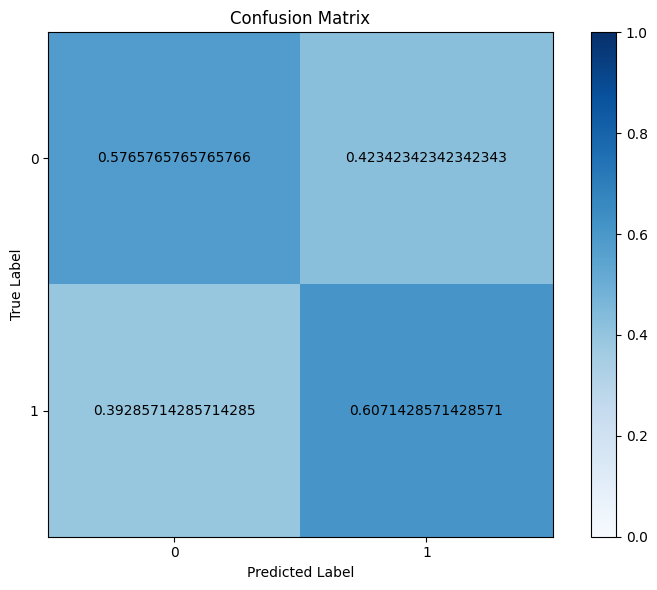

Train tracks shape:  (886, 13)


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_87          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_208 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_209 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7338 - loss: 0.8219 - val_accuracy: 0.6957 - val_loss: 0.5873
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6384 - loss: 0.7248 - val_accuracy: 0.2826 - val_loss: 0.7712
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5659 - loss: 0.6896 - val_accuracy: 0.2391 - val_loss: 0.7761
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.5856 - loss: 0.6577 - val_accuracy: 0.2536 - val_loss: 0.7664
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5320 - loss: 0.6815 - val_accuracy: 0.2464 - val_loss: 0.7601
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5119 - loss: 0.6776 - val_accuracy: 0.3116 - val_loss: 0.7459
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5086 - loss: 0.6852 - val_accuracy: 0.3623 - val_loss: 0.7308
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.4775 - loss: 0.6670 - val_accuracy: 0.3768 -

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3784, Adversarial loss: 0.7635, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8037, Adversarial loss: 0.7309, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7664, Adversarial loss: 0.7170, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7403, Adversarial loss: 0.7058, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7372, Adversarial loss: 0.7007, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7407, Adversarial loss: 0.7095, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7188, Adversarial loss: 0.7045, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7354, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7330, Adversarial loss: 0.6967, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_215 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3479 - loss: 0.9180 - val_accuracy: 0.3261 - val_loss: 0.8472
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.3470 - loss: 0.8358 - val_accuracy: 0.3261 - val_loss: 0.7786
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3453 - loss: 0.7736 - val_accuracy: 0.3841 - val_loss: 0.7283
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.3395 - loss: 0.7302 - val_accuracy: 0.5435 - val_loss: 0.6918
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4641 - loss: 0.6940 - val_accuracy: 0.7174 - val_loss: 0.6667
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6348 - loss: 0.6678 - val_accuracy: 0.6884 - val_loss: 0.6473
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6528 - loss: 0.6502 - val_accuracy: 0.6884 - val_loss: 0.6350
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6566 - loss: 0.6352 - val_accuracy: 0.68

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_216 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 0.8148 - val_accuracy: 0.6159 - val_loss: 0.7533
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.5759 - loss: 0.7806 - val_accuracy: 0.6159 - val_loss: 0.7193
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5694 - loss: 0.7579 - val_accuracy: 0.6232 - val_loss: 0.6925
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5851 - loss: 0.7191 - val_accuracy: 0.6232 - val_loss: 0.6746
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5968 - loss: 0.6795 - val_accuracy: 0.6232 - val_loss: 0.6593
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.5913 - loss: 0.6701 - val_accuracy: 0.6449 - val_loss: 0.6468
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6142 - loss: 0.6692 - val_accuracy: 0.6667 - val_loss: 0.6374
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6104 - loss: 0.6436 - val_accuracy: 0.65

Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_217 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6051 - loss: 1.0548 - val_accuracy: 0.4855 - val_loss: 1.2458
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6057 - loss: 1.0129 - val_accuracy: 0.5072 - val_loss: 1.1652
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5857 - loss: 1.0070 - val_accuracy: 0.5145 - val_loss: 1.0876
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6152 - loss: 0.8953 - val_accuracy: 0.5145 - val_loss: 1.0255
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6092 - loss: 0.8871 - val_accuracy: 0.5362 - val_loss: 0.9659
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6188 - loss: 0.8493 - val_accuracy: 0.5362 - val_loss: 0.9108
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6129 - loss: 0.8322 - val_accuracy: 0.5362 - val_loss: 0.8619
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6033 - loss: 0.8097 - val_accuracy: 0.52

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_218 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3495 - loss: 1.5402 - val_accuracy: 0.4638 - val_loss: 1.1215
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.3699 - loss: 1.4524 - val_accuracy: 0.4565 - val_loss: 1.0891
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3646 - loss: 1.3525 - val_accuracy: 0.4420 - val_loss: 1.0610
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.3505 - loss: 1.3015 - val_accuracy: 0.4275 - val_loss: 1.0290
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3823 - loss: 1.1870 - val_accuracy: 0.3986 - val_loss: 1.0020
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3814 - loss: 1.1372 - val_accuracy: 0.3986 - val_loss: 0.9745
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3877 - loss: 1.0552 - val_accuracy: 0.3841 - val_loss: 0.9481
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3872 - loss: 1.0051 - val_accuracy: 0.38

Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_219 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3553 - loss: 1.7245 - val_accuracy: 0.3986 - val_loss: 1.4439
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.3493 - loss: 1.5906 - val_accuracy: 0.3913 - val_loss: 1.3648
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.3617 - loss: 1.4753 - val_accuracy: 0.3913 - val_loss: 1.2893
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.3734 - loss: 1.3554 - val_accuracy: 0.3913 - val_loss: 1.2140
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.3669 - loss: 1.2668 - val_accuracy: 0.3913 - val_loss: 1.1420
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.3524 - loss: 1.1981 - val_accuracy: 0.3841 - val_loss: 1.0728
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.3816 - loss: 1.0757 - val_accuracy: 0.3841 - val_loss: 1.0082
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.3782 - loss: 1.0242 - val_accuracy: 0.37

Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_220 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6534 - loss: 0.6613 - val_accuracy: 0.6739 - val_loss: 0.6650
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6521 - loss: 0.6472 - val_accuracy: 0.6884 - val_loss: 0.6543
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6445 - loss: 0.6415 - val_accuracy: 0.7029 - val_loss: 0.6463
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6337 - loss: 0.6399 - val_accuracy: 0.7101 - val_loss: 0.6410
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.6529 - loss: 0.6292 - val_accuracy: 0.7174 - val_loss: 0.6369
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6473 - loss: 0.6342 - val_accuracy: 0.7174 - val_loss: 0.6339
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6476 - loss: 0.6189 - val_accuracy: 0.7174 - val_loss: 0.6320
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.6585 - loss: 0.6246 - val_accuracy: 0.71

Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_221 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 0.6938 - val_accuracy: 0.5725 - val_loss: 0.8060
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.6452 - loss: 0.6786 - val_accuracy: 0.6014 - val_loss: 0.7519
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6586 - loss: 0.6759 - val_accuracy: 0.6232 - val_loss: 0.7106
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6474 - loss: 0.6484 - val_accuracy: 0.6304 - val_loss: 0.6831
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6425 - loss: 0.6613 - val_accuracy: 0.6449 - val_loss: 0.6595
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6340 - loss: 0.6462 - val_accuracy: 0.6449 - val_loss: 0.6442
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6578 - loss: 0.6306 - val_accuracy: 0.6449 - val_loss: 0.6334
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6426 - loss: 0.6338 - val_accuracy: 0.64

Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_222 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3602 - loss: 0.9318 - val_accuracy: 0.4130 - val_loss: 0.8048
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.3629 - loss: 0.8786 - val_accuracy: 0.3768 - val_loss: 0.7858
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.3476 - loss: 0.8219 - val_accuracy: 0.3478 - val_loss: 0.7681
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3688 - loss: 0.7761 - val_accuracy: 0.3333 - val_loss: 0.7506
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3668 - loss: 0.7430 - val_accuracy: 0.2971 - val_loss: 0.7319
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.3853 - loss: 0.7166 - val_accuracy: 0.2536 - val_loss: 0.7163
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.4974 - loss: 0.6946 - val_accuracy: 0.4565 - val_loss: 0.6997
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6533 - loss: 0.6770 - val_accuracy: 0.57

Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_223 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4874 - loss: 1.0972 - val_accuracy: 0.5942 - val_loss: 0.7604
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.5083 - loss: 1.0251 - val_accuracy: 0.5797 - val_loss: 0.7632
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.5421 - loss: 0.9439 - val_accuracy: 0.5725 - val_loss: 0.7685
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5555 - loss: 0.8850 - val_accuracy: 0.5290 - val_loss: 0.7717
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5536 - loss: 0.8401 - val_accuracy: 0.5435 - val_loss: 0.7723
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.5558 - loss: 0.7930 - val_accuracy: 0.5145 - val_loss: 0.7693
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5845 - loss: 0.7560 - val_accuracy: 0.5145 - val_loss: 0.7665
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5900 - loss: 0.7297 - val_accuracy: 0.51

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_224 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4520 - loss: 1.3586 - val_accuracy: 0.3623 - val_loss: 1.5049
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.4561 - loss: 1.2741 - val_accuracy: 0.3696 - val_loss: 1.3856
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.4788 - loss: 1.1792 - val_accuracy: 0.3841 - val_loss: 1.2762
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4474 - loss: 1.1284 - val_accuracy: 0.3768 - val_loss: 1.1748
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.4836 - loss: 1.0064 - val_accuracy: 0.3913 - val_loss: 1.0820
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4642 - loss: 0.9785 - val_accuracy: 0.3986 - val_loss: 0.9920
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.5448 - loss: 0.8652 - val_accuracy: 0.4493 - val_loss: 0.9186
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5464 - loss: 0.8272 - val_accuracy: 0.46

Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_225 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4934 - loss: 1.2710 - val_accuracy: 0.5797 - val_loss: 0.8278
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.4959 - loss: 1.1658 - val_accuracy: 0.5870 - val_loss: 0.7890
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5026 - loss: 1.0965 - val_accuracy: 0.5942 - val_loss: 0.7515
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5040 - loss: 1.0388 - val_accuracy: 0.6087 - val_loss: 0.7210
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5536 - loss: 0.9493 - val_accuracy: 0.6159 - val_loss: 0.6947
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.5459 - loss: 0.9113 - val_accuracy: 0.6232 - val_loss: 0.6714
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.5540 - loss: 0.8819 - val_accuracy: 0.6087 - val_loss: 0.6553
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5391 - loss: 0.8412 - val_accuracy: 0.60

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_226 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4213 - loss: 1.0026 - val_accuracy: 0.4420 - val_loss: 0.8953
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.4131 - loss: 0.9194 - val_accuracy: 0.4275 - val_loss: 0.8667
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4417 - loss: 0.8625 - val_accuracy: 0.4203 - val_loss: 0.8392
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5318 - loss: 0.8102 - val_accuracy: 0.4275 - val_loss: 0.8100
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5335 - loss: 0.7740 - val_accuracy: 0.4493 - val_loss: 0.7834
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.5445 - loss: 0.7310 - val_accuracy: 0.4783 - val_loss: 0.7607
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5717 - loss: 0.7006 - val_accuracy: 0.4928 - val_loss: 0.7390
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5822 - loss: 0.6798 - val_accuracy: 0.49

Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_227 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3420 - loss: 1.7643 - val_accuracy: 0.3623 - val_loss: 1.4390
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.3327 - loss: 1.7154 - val_accuracy: 0.3551 - val_loss: 1.3676
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.3296 - loss: 1.5882 - val_accuracy: 0.3261 - val_loss: 1.2987
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3285 - loss: 1.4740 - val_accuracy: 0.3116 - val_loss: 1.2316
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.3439 - loss: 1.3270 - val_accuracy: 0.3116 - val_loss: 1.1659
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.3364 - loss: 1.2686 - val_accuracy: 0.3116 - val_loss: 1.1015
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3288 - loss: 1.1633 - val_accuracy: 0.3116 - val_loss: 1.0419
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.3438 - loss: 1.0505 - val_accuracy: 0.31

Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_228 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5471 - loss: 0.8438 - val_accuracy: 0.6087 - val_loss: 0.7039
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.5711 - loss: 0.7878 - val_accuracy: 0.6159 - val_loss: 0.6800
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.5779 - loss: 0.7419 - val_accuracy: 0.6087 - val_loss: 0.6630
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.5846 - loss: 0.7394 - val_accuracy: 0.6087 - val_loss: 0.6490
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5963 - loss: 0.7123 - val_accuracy: 0.6377 - val_loss: 0.6357
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5870 - loss: 0.6930 - val_accuracy: 0.6739 - val_loss: 0.6271
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.5996 - loss: 0.6702 - val_accuracy: 0.6812 - val_loss: 0.6221
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6059 - loss: 0.6597 - val_accuracy: 0.67

Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_229 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6794 - loss: 0.6112 - val_accuracy: 0.6522 - val_loss: 0.6427
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.7011 - loss: 0.6058 - val_accuracy: 0.6667 - val_loss: 0.6393
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6826 - loss: 0.6166 - val_accuracy: 0.6667 - val_loss: 0.6383
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6850 - loss: 0.6140 - val_accuracy: 0.6739 - val_loss: 0.6328
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.6864 - loss: 0.6169 - val_accuracy: 0.6739 - val_loss: 0.6292
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6896 - loss: 0.6071 - val_accuracy: 0.6739 - val_loss: 0.6266
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6718 - loss: 0.6033 - val_accuracy: 0.6739 - val_loss: 0.6258
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6841 - loss: 0.5988 - val_accuracy: 0.67

Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_230 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6466 - loss: 0.6303 - val_accuracy: 0.6377 - val_loss: 0.6594
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.6865 - loss: 0.6146 - val_accuracy: 0.6667 - val_loss: 0.6406
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6787 - loss: 0.6209 - val_accuracy: 0.6739 - val_loss: 0.6289
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6436 - loss: 0.6175 - val_accuracy: 0.6667 - val_loss: 0.6225
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6551 - loss: 0.6186 - val_accuracy: 0.6594 - val_loss: 0.6220
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6598 - loss: 0.6126 - val_accuracy: 0.6739 - val_loss: 0.6170
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6760 - loss: 0.6000 - val_accuracy: 0.6812 - val_loss: 0.6184
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6661 - loss: 0.6041 - val_accuracy: 0.68

Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_231 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6084 - loss: 0.7077 - val_accuracy: 0.5362 - val_loss: 0.8642
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6594 - loss: 0.6607 - val_accuracy: 0.5652 - val_loss: 0.8141
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6547 - loss: 0.6456 - val_accuracy: 0.5580 - val_loss: 0.7711
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6753 - loss: 0.6135 - val_accuracy: 0.5725 - val_loss: 0.7371
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6721 - loss: 0.6160 - val_accuracy: 0.5870 - val_loss: 0.7064
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6944 - loss: 0.5922 - val_accuracy: 0.5942 - val_loss: 0.6850
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7107 - loss: 0.5684 - val_accuracy: 0.6014 - val_loss: 0.6685
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.7032 - loss: 0.5821 - val_accuracy: 0.61

Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_232 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7039 - loss: 0.5800 - val_accuracy: 0.6594 - val_loss: 0.6410
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.7031 - loss: 0.5669 - val_accuracy: 0.6594 - val_loss: 0.6341
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7022 - loss: 0.5848 - val_accuracy: 0.6667 - val_loss: 0.6293
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.7140 - loss: 0.5640 - val_accuracy: 0.6739 - val_loss: 0.6258
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6804 - loss: 0.6038 - val_accuracy: 0.6739 - val_loss: 0.6197
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6729 - loss: 0.5875 - val_accuracy: 0.6739 - val_loss: 0.6200
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6980 - loss: 0.5717 - val_accuracy: 0.6594 - val_loss: 0.6196
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6759 - loss: 0.5922 - val_accuracy: 0.66

Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_233 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7406 - loss: 0.5554 - val_accuracy: 0.6304 - val_loss: 0.6820
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7330 - loss: 0.5510 - val_accuracy: 0.6449 - val_loss: 0.6657
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.7429 - loss: 0.5323 - val_accuracy: 0.6594 - val_loss: 0.6542
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.7115 - loss: 0.5656 - val_accuracy: 0.6594 - val_loss: 0.6438
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7311 - loss: 0.5450 - val_accuracy: 0.6594 - val_loss: 0.6361
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.7321 - loss: 0.5486 - val_accuracy: 0.6739 - val_loss: 0.6318
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.7414 - loss: 0.5316 - val_accuracy: 0.6739 - val_loss: 0.6319
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.7283 - loss: 0.5368 - val_accuracy: 0.67

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_234 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2908 - loss: 1.0407 - val_accuracy: 0.4493 - val_loss: 0.7841
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.3432 - loss: 0.9649 - val_accuracy: 0.4420 - val_loss: 0.7654
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.3707 - loss: 0.8776 - val_accuracy: 0.4638 - val_loss: 0.7513
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.3821 - loss: 0.8246 - val_accuracy: 0.4420 - val_loss: 0.7407
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.4154 - loss: 0.7712 - val_accuracy: 0.4565 - val_loss: 0.7308
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.4775 - loss: 0.7290 - val_accuracy: 0.4855 - val_loss: 0.7214
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5212 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.7143
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5919 - loss: 0.6667 - val_accuracy: 0.51

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_235 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5864 - loss: 0.8505 - val_accuracy: 0.3188 - val_loss: 1.1338
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.5831 - loss: 0.7957 - val_accuracy: 0.3623 - val_loss: 1.0234
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6033 - loss: 0.7409 - val_accuracy: 0.4058 - val_loss: 0.9336
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6182 - loss: 0.6899 - val_accuracy: 0.4203 - val_loss: 0.8620
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6285 - loss: 0.6618 - val_accuracy: 0.4130 - val_loss: 0.8075
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6264 - loss: 0.6373 - val_accuracy: 0.4710 - val_loss: 0.7645
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6348 - loss: 0.6419 - val_accuracy: 0.4855 - val_loss: 0.7333
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6626 - loss: 0.6084 - val_accuracy: 0.48

Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_236 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5941 - loss: 1.2024 - val_accuracy: 0.7246 - val_loss: 0.6731
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.5897 - loss: 1.1789 - val_accuracy: 0.7174 - val_loss: 0.6726
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6043 - loss: 1.0508 - val_accuracy: 0.7029 - val_loss: 0.6736
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6087 - loss: 1.0179 - val_accuracy: 0.7029 - val_loss: 0.6746
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6035 - loss: 0.9631 - val_accuracy: 0.6884 - val_loss: 0.6787
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5989 - loss: 0.8982 - val_accuracy: 0.6739 - val_loss: 0.6813
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.5772 - loss: 0.9155 - val_accuracy: 0.6449 - val_loss: 0.6856
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6083 - loss: 0.8576 - val_accuracy: 0.63

Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_237 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2861 - loss: 0.8767 - val_accuracy: 0.5072 - val_loss: 0.6977
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.3064 - loss: 0.8065 - val_accuracy: 0.4783 - val_loss: 0.7074
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.2987 - loss: 0.7671 - val_accuracy: 0.3841 - val_loss: 0.7140
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3827 - loss: 0.7197 - val_accuracy: 0.2899 - val_loss: 0.7147
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5316 - loss: 0.6895 - val_accuracy: 0.3551 - val_loss: 0.7128
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6716 - loss: 0.6623 - val_accuracy: 0.4275 - val_loss: 0.7092
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.7097 - loss: 0.6379 - val_accuracy: 0.4710 - val_loss: 0.7048
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7126 - loss: 0.6257 - val_accuracy: 0.52

Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_238 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4878 - loss: 0.7127 - val_accuracy: 0.4275 - val_loss: 0.7248
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5394 - loss: 0.6806 - val_accuracy: 0.4710 - val_loss: 0.6974
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6524 - loss: 0.6528 - val_accuracy: 0.5797 - val_loss: 0.6781
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6848 - loss: 0.6319 - val_accuracy: 0.6014 - val_loss: 0.6647
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.7144 - loss: 0.6118 - val_accuracy: 0.5942 - val_loss: 0.6558
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.7287 - loss: 0.5923 - val_accuracy: 0.6014 - val_loss: 0.6493
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.7082 - loss: 0.5894 - val_accuracy: 0.5942 - val_loss: 0.6453
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7290 - loss: 0.5763 - val_accuracy: 0.60

Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_239 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7417 - loss: 0.5730 - val_accuracy: 0.6304 - val_loss: 0.6652
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.7496 - loss: 0.5564 - val_accuracy: 0.6232 - val_loss: 0.6626
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.7508 - loss: 0.5297 - val_accuracy: 0.6304 - val_loss: 0.6639
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.7389 - loss: 0.5321 - val_accuracy: 0.6304 - val_loss: 0.6681
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.7512 - loss: 0.5225 - val_accuracy: 0.6304 - val_loss: 0.6715
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.7533 - loss: 0.5224 - val_accuracy: 0.6377 - val_loss: 0.6725
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.7584 - loss: 0.5204 - val_accuracy: 0.6377 - val_loss: 0.6759
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7436 - loss: 0.5231 - val_accuracy: 0.63

Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_240 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2853 - loss: 0.8965 - val_accuracy: 0.4855 - val_loss: 0.7218
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.2840 - loss: 0.8201 - val_accuracy: 0.4203 - val_loss: 0.7244
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.2521 - loss: 0.7677 - val_accuracy: 0.3768 - val_loss: 0.7225
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3288 - loss: 0.7204 - val_accuracy: 0.1304 - val_loss: 0.7182
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5622 - loss: 0.6827 - val_accuracy: 0.3841 - val_loss: 0.7119
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6900 - loss: 0.6547 - val_accuracy: 0.4565 - val_loss: 0.7053
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6842 - loss: 0.6333 - val_accuracy: 0.4783 - val_loss: 0.6977
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7121 - loss: 0.6135 - val_accuracy: 0.53

Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_241 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5216 - loss: 0.8740 - val_accuracy: 0.4783 - val_loss: 1.0094
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6314 - loss: 0.8043 - val_accuracy: 0.4710 - val_loss: 0.9540
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6120 - loss: 0.7741 - val_accuracy: 0.4855 - val_loss: 0.9035
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6273 - loss: 0.7278 - val_accuracy: 0.5145 - val_loss: 0.8593
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6642 - loss: 0.6696 - val_accuracy: 0.5217 - val_loss: 0.8223
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6527 - loss: 0.6542 - val_accuracy: 0.5435 - val_loss: 0.7904
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6870 - loss: 0.6234 - val_accuracy: 0.5580 - val_loss: 0.7611
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6694 - loss: 0.6185 - val_accuracy: 0.57

Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_242 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4255 - loss: 0.7108 - val_accuracy: 0.4855 - val_loss: 0.7120
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - accuracy: 0.5938 - loss: 0.6778 - val_accuracy: 0.5435 - val_loss: 0.7037
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6771 - loss: 0.6504 - val_accuracy: 0.6014 - val_loss: 0.6973
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6848 - loss: 0.6270 - val_accuracy: 0.6087 - val_loss: 0.6897
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.7227 - loss: 0.6065 - val_accuracy: 0.6087 - val_loss: 0.6818
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.7184 - loss: 0.5900 - val_accuracy: 0.6159 - val_loss: 0.6745
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.7299 - loss: 0.5729 - val_accuracy: 0.6232 - val_loss: 0.6699
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7208 - loss: 0.5794 - val_accuracy: 0.63

Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_243 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 0.8575 - val_accuracy: 0.5290 - val_loss: 0.9116
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6674 - loss: 0.7863 - val_accuracy: 0.5652 - val_loss: 0.8490
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6668 - loss: 0.7502 - val_accuracy: 0.5942 - val_loss: 0.8008
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6634 - loss: 0.7297 - val_accuracy: 0.6232 - val_loss: 0.7594
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6600 - loss: 0.6913 - val_accuracy: 0.6304 - val_loss: 0.7280
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6654 - loss: 0.6484 - val_accuracy: 0.6739 - val_loss: 0.7050
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6933 - loss: 0.6014 - val_accuracy: 0.6812 - val_loss: 0.6852
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6697 - loss: 0.6237 - val_accuracy: 0.69

Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_244 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4421 - loss: 0.8523 - val_accuracy: 0.6014 - val_loss: 0.6687
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.5349 - loss: 0.7752 - val_accuracy: 0.6449 - val_loss: 0.6524
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5668 - loss: 0.7221 - val_accuracy: 0.6594 - val_loss: 0.6425
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5917 - loss: 0.6744 - val_accuracy: 0.6884 - val_loss: 0.6345
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6342 - loss: 0.6346 - val_accuracy: 0.6667 - val_loss: 0.6297
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6438 - loss: 0.6060 - val_accuracy: 0.6667 - val_loss: 0.6260
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6957 - loss: 0.5745 - val_accuracy: 0.6739 - val_loss: 0.6249
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6980 - loss: 0.5669 - val_accuracy: 0.67

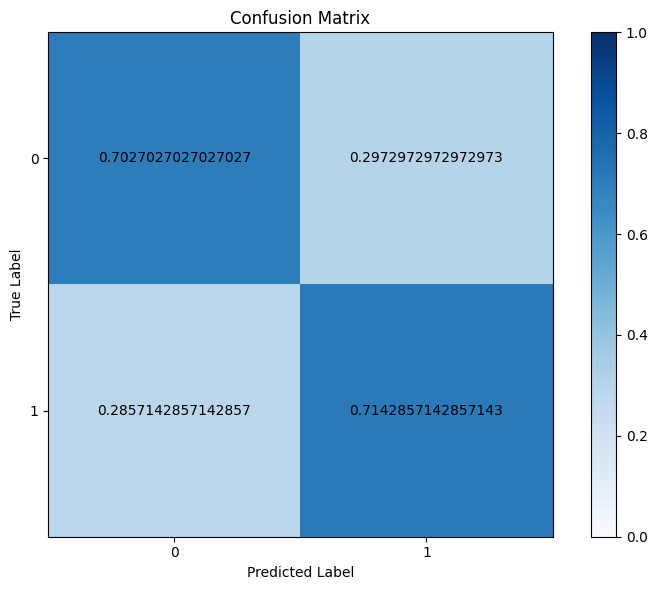

Train tracks shape:  (997, 13)


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_98          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_246 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_247 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_248 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7168 - loss: 0.7962 - val_accuracy: 0.6884 - val_loss: 0.5784
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.5977 - loss: 0.7286 - val_accuracy: 0.4058 - val_loss: 0.7209
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.5502 - loss: 0.7033 - val_accuracy: 0.3551 - val_loss: 0.7401
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5537 - loss: 0.6807 - val_accuracy: 0.3406 - val_loss: 0.7388
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.5277 - loss: 0.6730 - val_accuracy: 0.4058 - val_loss: 0.7253
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.5172 - loss: 0.7110 - val_accuracy: 0.4203 - val_loss: 0.7058
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.5337 - loss: 0.6801 - val_accuracy: 0.4348 - val_loss: 0.6996
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.5008 - loss: 0.6872 - val_accuracy: 0.47

: 

In [9]:
conf_matrix_cellfate, conf_matrix_tabular = data_size_study(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=44)

# Taking cumulative set of data

In [60]:
train_images[:int(train_images.shape[0]*0.9)].shape

(997, 1080, 20, 20)

In [3]:
dataset_size = [1.0]  #0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 

def data_size_study_cummulative(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=43):

    np.random.seed(seed)
    confusion_matrices_cellfate = np.zeros((len(dataset_size), 2, 2))
    confusion_matrices_tabular = np.zeros((len(dataset_size), 2, 2))

    for size in dataset_size:
        
        # Create new output directory folder with the size 
        output_dir=f"../results/data_labelling_study/cumulative_split_seed43_{size}"
        os.makedirs(output_dir, exist_ok=True)

        #less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

        # Get less training data
        smaller_x_train_images = train_images[:int(train_images.shape[0]*size)]
        smaller_y_train = train_labels[:int(train_images.shape[0]*size)]
        smaller_x_train_tracks = train_tracks[:int(train_images.shape[0]*size)]

        # Augment image data
        smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

        # Stretch intensities of new images (train and test)
        stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

        # Pick only frame zero
        x_train = stretched_x_train_smaller[:,0,:,:]
        y_train = smaller_train_labels_augmented
        x_test = stretched_x_test[:,0,:,:]
        y_test = test_labels

        print("X_train size: ", x_train.shape, "Y_train size: ", y_train.shape, "X_test size: ", x_test.shape, "Y_test size: ", y_test.shape)

        # IMAGES: Train autoencoder only
        
        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }

        results_autoencoder = train_autoencoder(config_ae, x_train_full)
        encoder = results_autoencoder['encoder']
        decoder = results_autoencoder['decoder']
        discriminator = results_autoencoder['discriminator']

        # IMAGES: Train AIcellfate with smaller dataset

        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']
        discriminator = results_cellfate['discriminator']

        save_model_weights_to_disk(encoder, decoder, discriminator, output_dir=output_dir)
        
        evaluator = Evaluation(output_dir)

        # Evaluate the model (and saving everything)
        z_imgs = encoder.predict(x_train)
        recon_imgs = decoder.predict(z_imgs)
        evaluator.reconstruction_images(x_train, recon_imgs[:,:,:,0], epoch=0)
        evaluator.visualize_latent_space(z_imgs, y_train, epoch=0)
        cov_matrix = cov_loss_terms(z_imgs)[0]
        evaluator.plot_cov_matrix(cov_matrix, epoch=0) # the epoch is a placeholder, it doesnt mean anything (TODO: change these functions)

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)
        num_classes = len(np.unique(y_test_))

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums
        
        confusion_matrices_cellfate[dataset_size.index(size)] = conf_matrix_normalized

        # Save confusion matrix
        plot_confusion_matrix(y_test_, y_pred, num_classes)
        np.save(f"{output_dir}/confusion_matrices_cellfate.npy", confusion_matrices_cellfate)

        # TODO: add perturbations ?

        # TRACKS: train classifier

        config_tracks = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': 42,
        }
        
        train_tracks_ = smaller_x_train_tracks[:,0,4:17]
        test_tracks_ = test_tracks[:,0,4:17]
        train_labels_ = smaller_y_train
        test_labels_ = test_labels

        print("Train tracks shape: ", train_tracks_.shape)

        class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_.flatten()), y=train_labels_.flatten())
        class_weights = dict(enumerate(class_weights))

        tf.keras.utils.set_random_seed(seed)

        classifier = complex_mlp_classifier(latent_dim=train_tracks_.shape[1]) #[:, [3, 8]] 
        #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

        # Train the classifier
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_tracks['learning_rate']), metrics=['accuracy'])
        classifier.summary()

        x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_, test_labels_, test_size=0.5, random_state=42) # 42 random state

        history = classifier.fit(train_tracks_, train_labels_, batch_size=config_tracks['batch_size'], epochs=config_tracks['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

        y_pred = classifier.predict(x_test_tracks)

        num_classes = len(np.unique(train_labels_))
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_tracks, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        print(conf_matrix_normalized)

        confusion_matrices_tabular[dataset_size.index(size)] = conf_matrix_normalized
        np.save(f"{output_dir}/confusion_matrices_tabular.npy", confusion_matrices_tabular)

    return confusion_matrices_cellfate, confusion_matrices_tabular



X_train size:  (2184, 20, 20) Y_train size:  (2184,) X_test size:  (277, 20, 20) Y_test size:  (277,)
Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 43, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.3084, Adversarial loss: 0.7611, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7899, Adversarial loss: 0.7317, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7731, Adversarial loss: 0.7214, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7688, Adversarial loss: 0.7100, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7335, Adversarial loss: 0.7051, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7432, Adversarial loss: 0.6976, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7405, Adversarial loss: 0.7011, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7117, Adversarial loss: 0.6965, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7207, Adversarial loss: 0.6985, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Training with batch size: 30, epochs: 100, learning rate: 0.001, seed: 43, latent dim: 2
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
kl_divergence[0]: 0.20164563389659856 kl_divergence[1]: 0.1396291548162274
Epoch 1/100: Reconstruction loss: 0.9032, Adversarial loss: 2.8177, Contrastive loss: 5.4938, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
kl_divergence[0]: 0.17014914286824231 kl_divergence[1]: 0.6999924740997261
Epoch 2/100: Reconstruction loss: 0.9670, Adversarial loss: 2.8112, Contrastive loss: 5.2909, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
kl_divergence[0]: 0.38069771332969027 kl_divergence[1]: 0.07764056476120922
Epoch 3/100: Reconstruction loss: 1.0295, Advers

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6247 - loss: 0.6913 - val_accuracy: 0.6449 - val_loss: 0.6411
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6297 - loss: 0.6684 - val_accuracy: 0.6159 - val_loss: 0.6490
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6546 - loss: 0.6377 - val_accuracy: 0.6232 - val_loss: 0.6530
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6340 - loss: 0.6405 - val_accuracy: 0.5942 - val_loss: 0.6532
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6360 - loss: 0.6449 - val_accuracy: 0.5652 - val_loss: 0.6545
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6316 - loss: 0.6403 - val_accuracy: 0.5725 - val_loss: 0.6518
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.6412 - loss: 0.6305 - val_accuracy: 0.5725 - val_loss: 0.6508
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6371 - loss: 0.6358 - val_accuracy: 0.5652

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4982 - loss: 0.8145 - val_accuracy: 0.5870 - val_loss: 0.6575
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5080 - loss: 0.7480 - val_accuracy: 0.6014 - val_loss: 0.6610
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5271 - loss: 0.7312 - val_accuracy: 0.5942 - val_loss: 0.6625
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5381 - loss: 0.6988 - val_accuracy: 0.5870 - val_loss: 0.6617
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5705 - loss: 0.6709 - val_accuracy: 0.5725 - val_loss: 0.6585
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5957 - loss: 0.6597 - val_accuracy: 0.5797 - val_loss: 0.6567
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6391 - loss: 0.6483 - val_accuracy: 0.5725 - val_loss: 0.6536
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6537 - loss: 0.6375 - val_accuracy: 0.5797

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 - loss: 1.0225 - val_accuracy: 0.7609 - val_loss: 0.5621
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.6403 - loss: 0.9299 - val_accuracy: 0.7609 - val_loss: 0.5623
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6246 - loss: 0.8883 - val_accuracy: 0.7536 - val_loss: 0.5642
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6394 - loss: 0.8195 - val_accuracy: 0.7536 - val_loss: 0.5690
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6389 - loss: 0.7738 - val_accuracy: 0.7681 - val_loss: 0.5745
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6320 - loss: 0.8092 - val_accuracy: 0.7681 - val_loss: 0.5801
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6528 - loss: 0.7590 - val_accuracy: 0.7464 - val_loss: 0.5870
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6498 - loss: 0.7186 - val_accuracy: 0.76

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6130 - loss: 0.6695 - val_accuracy: 0.6014 - val_loss: 0.6521
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6209 - loss: 0.6608 - val_accuracy: 0.5942 - val_loss: 0.6452
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6232 - loss: 0.6465 - val_accuracy: 0.6087 - val_loss: 0.6403
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6235 - loss: 0.6456 - val_accuracy: 0.6087 - val_loss: 0.6354
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.6366 - loss: 0.6330 - val_accuracy: 0.6232 - val_loss: 0.6332
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6125 - loss: 0.6418 - val_accuracy: 0.6304 - val_loss: 0.6329
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6006 - loss: 0.6506 - val_accuracy: 0.6232 - val_loss: 0.6326
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6112 - loss: 0.6438 - val_accuracy: 0.6232

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5678 - loss: 0.8062 - val_accuracy: 0.5000 - val_loss: 0.8654
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - accuracy: 0.5935 - loss: 0.7523 - val_accuracy: 0.5145 - val_loss: 0.8093
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - accuracy: 0.5826 - loss: 0.7441 - val_accuracy: 0.5217 - val_loss: 0.7652
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.5952 - loss: 0.7131 - val_accuracy: 0.5362 - val_loss: 0.7298
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6161 - loss: 0.6807 - val_accuracy: 0.5580 - val_loss: 0.7027
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.5939 - loss: 0.6857 - val_accuracy: 0.5652 - val_loss: 0.6782
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6046 - loss: 0.6744 - val_accuracy: 0.6014 - val_loss: 0.6595
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6144 - loss: 0.6570 - val_accuracy: 0.63

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4839 - loss: 1.1819 - val_accuracy: 0.4203 - val_loss: 1.1111
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4447 - loss: 1.0950 - val_accuracy: 0.4275 - val_loss: 1.0566
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.4552 - loss: 1.0690 - val_accuracy: 0.4348 - val_loss: 1.0038
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4702 - loss: 1.0374 - val_accuracy: 0.4348 - val_loss: 0.9528
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4898 - loss: 0.9489 - val_accuracy: 0.4348 - val_loss: 0.9104
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4682 - loss: 0.9180 - val_accuracy: 0.4420 - val_loss: 0.8712
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.4848 - loss: 0.8851 - val_accuracy: 0.4565 - val_loss: 0.8346
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.4851 - loss: 0.8485 - val_accuracy: 0.4783

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5535 - loss: 0.7190 - val_accuracy: 0.6812 - val_loss: 0.6016
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5688 - loss: 0.6988 - val_accuracy: 0.6739 - val_loss: 0.6030
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.5620 - loss: 0.6850 - val_accuracy: 0.6812 - val_loss: 0.6034
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.5856 - loss: 0.6711 - val_accuracy: 0.6884 - val_loss: 0.6069
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5796 - loss: 0.6614 - val_accuracy: 0.6884 - val_loss: 0.6075
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.6108 - loss: 0.6470 - val_accuracy: 0.6812 - val_loss: 0.6048
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6144 - loss: 0.6410 - val_accuracy: 0.6812 - val_loss: 0.6055
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6056 - loss: 0.6438 - val_accuracy: 0.6812

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3711 - loss: 1.6416 - val_accuracy: 0.5145 - val_loss: 0.9979
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3758 - loss: 1.5204 - val_accuracy: 0.5000 - val_loss: 0.9775
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3739 - loss: 1.3962 - val_accuracy: 0.5000 - val_loss: 0.9583
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.3768 - loss: 1.3601 - val_accuracy: 0.4710 - val_loss: 0.9384
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3704 - loss: 1.2309 - val_accuracy: 0.4710 - val_loss: 0.9210
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3883 - loss: 1.1494 - val_accuracy: 0.4493 - val_loss: 0.9023
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3849 - loss: 1.0806 - val_accuracy: 0.4275 - val_loss: 0.8821
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.3892 - loss: 0.9698 - val_accuracy: 0.4130

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5506 - loss: 1.1448 - val_accuracy: 0.5435 - val_loss: 0.8219
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5629 - loss: 1.0261 - val_accuracy: 0.5435 - val_loss: 0.8244
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5564 - loss: 0.9786 - val_accuracy: 0.5362 - val_loss: 0.8248
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.5675 - loss: 0.9320 - val_accuracy: 0.5217 - val_loss: 0.8219
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5782 - loss: 0.8806 - val_accuracy: 0.5290 - val_loss: 0.8139
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5847 - loss: 0.8248 - val_accuracy: 0.5362 - val_loss: 0.8069
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5964 - loss: 0.8181 - val_accuracy: 0.5290 - val_loss: 0.7934
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.5937 - loss: 0.7789 - val_accuracy: 0.52

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6764 - loss: 0.6431 - val_accuracy: 0.7246 - val_loss: 0.6402
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6610 - loss: 0.6279 - val_accuracy: 0.7319 - val_loss: 0.6252
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6502 - loss: 0.6250 - val_accuracy: 0.7319 - val_loss: 0.6164
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6587 - loss: 0.6172 - val_accuracy: 0.7319 - val_loss: 0.6092
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6809 - loss: 0.6128 - val_accuracy: 0.7391 - val_loss: 0.6039
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6739 - loss: 0.6029 - val_accuracy: 0.7391 - val_loss: 0.6004
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6788 - loss: 0.6054 - val_accuracy: 0.7391 - val_loss: 0.5991
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6688 - loss: 0.6074 - val_accuracy: 0.7391

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4078 - loss: 1.2121 - val_accuracy: 0.4710 - val_loss: 0.9749
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4132 - loss: 1.1024 - val_accuracy: 0.4855 - val_loss: 0.8828
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.4149 - loss: 0.9914 - val_accuracy: 0.5000 - val_loss: 0.8031
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.5140 - loss: 0.9090 - val_accuracy: 0.5072 - val_loss: 0.7414
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.5303 - loss: 0.8345 - val_accuracy: 0.5507 - val_loss: 0.6918
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5445 - loss: 0.7744 - val_accuracy: 0.5942 - val_loss: 0.6543
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.5572 - loss: 0.7303 - val_accuracy: 0.6377 - val_loss: 0.6297
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6072 - loss: 0.6944 - val_accuracy: 0.7029

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3927 - loss: 0.7824 - val_accuracy: 0.4348 - val_loss: 0.7352
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4074 - loss: 0.7379 - val_accuracy: 0.4275 - val_loss: 0.7213
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5153 - loss: 0.7027 - val_accuracy: 0.4493 - val_loss: 0.7078
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6189 - loss: 0.6738 - val_accuracy: 0.5145 - val_loss: 0.6951
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6324 - loss: 0.6574 - val_accuracy: 0.5797 - val_loss: 0.6841
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6522 - loss: 0.6402 - val_accuracy: 0.6159 - val_loss: 0.6733
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6474 - loss: 0.6386 - val_accuracy: 0.6377 - val_loss: 0.6642
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6500 - loss: 0.6318 - val_accuracy: 0.6522

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3381 - loss: 1.1075 - val_accuracy: 0.2971 - val_loss: 0.9765
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.3368 - loss: 1.0294 - val_accuracy: 0.3116 - val_loss: 0.9200
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.3154 - loss: 0.9821 - val_accuracy: 0.3261 - val_loss: 0.8675
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3369 - loss: 0.9151 - val_accuracy: 0.3261 - val_loss: 0.8246
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3562 - loss: 0.8400 - val_accuracy: 0.3478 - val_loss: 0.7877
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3530 - loss: 0.8147 - val_accuracy: 0.3913 - val_loss: 0.7552
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3825 - loss: 0.7711 - val_accuracy: 0.4275 - val_loss: 0.7306
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3973 - loss: 0.7381 - val_accuracy: 0.52

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.7037
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6297 - loss: 0.6490 - val_accuracy: 0.5870 - val_loss: 0.6812
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6421 - loss: 0.6341 - val_accuracy: 0.6232 - val_loss: 0.6658
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6573 - loss: 0.6173 - val_accuracy: 0.6304 - val_loss: 0.6543
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6616 - loss: 0.6074 - val_accuracy: 0.6449 - val_loss: 0.6485
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6685 - loss: 0.5942 - val_accuracy: 0.6522 - val_loss: 0.6446
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6735 - loss: 0.6020 - val_accuracy: 0.6594 - val_loss: 0.6380
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6631 - loss: 0.5998 - val_accuracy: 0.65

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3140 - loss: 1.4444 - val_accuracy: 0.3986 - val_loss: 0.9636
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3162 - loss: 1.3211 - val_accuracy: 0.3768 - val_loss: 0.9280
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.3238 - loss: 1.2377 - val_accuracy: 0.3696 - val_loss: 0.8935
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3249 - loss: 1.1033 - val_accuracy: 0.3478 - val_loss: 0.8631
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.3105 - loss: 1.0276 - val_accuracy: 0.3551 - val_loss: 0.8308
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.3570 - loss: 0.9086 - val_accuracy: 0.3623 - val_loss: 0.8032
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.3814 - loss: 0.8389 - val_accuracy: 0.3696 - val_loss: 0.7762
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.4228 - loss: 0.7796 - val_accuracy: 0.40

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5089 - loss: 0.8641 - val_accuracy: 0.6014 - val_loss: 0.7146
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5581 - loss: 0.8022 - val_accuracy: 0.5942 - val_loss: 0.6821
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.5785 - loss: 0.7572 - val_accuracy: 0.6449 - val_loss: 0.6582
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6288 - loss: 0.7266 - val_accuracy: 0.6449 - val_loss: 0.6426
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6379 - loss: 0.7121 - val_accuracy: 0.6522 - val_loss: 0.6331
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6255 - loss: 0.6828 - val_accuracy: 0.6377 - val_loss: 0.6253
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6570 - loss: 0.6606 - val_accuracy: 0.6449 - val_loss: 0.6208
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6565 - loss: 0.6396 - val_accuracy: 0.65

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4277 - loss: 1.9302 - val_accuracy: 0.3043 - val_loss: 1.9886
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4238 - loss: 1.8720 - val_accuracy: 0.3043 - val_loss: 1.8135
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.4161 - loss: 1.7671 - val_accuracy: 0.3261 - val_loss: 1.6481
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4143 - loss: 1.5867 - val_accuracy: 0.3406 - val_loss: 1.4952
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4189 - loss: 1.4220 - val_accuracy: 0.3478 - val_loss: 1.3533
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4324 - loss: 1.3230 - val_accuracy: 0.3623 - val_loss: 1.2222
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4208 - loss: 1.1910 - val_accuracy: 0.3768 - val_loss: 1.1031
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4280 - loss: 1.1072 - val_accuracy: 0.3913

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3515 - loss: 1.0908 - val_accuracy: 0.4058 - val_loss: 0.8101
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.3737 - loss: 0.9961 - val_accuracy: 0.3696 - val_loss: 0.8129
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.3623 - loss: 0.9555 - val_accuracy: 0.3333 - val_loss: 0.8127
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3610 - loss: 0.9024 - val_accuracy: 0.3116 - val_loss: 0.8097
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3567 - loss: 0.8571 - val_accuracy: 0.2681 - val_loss: 0.8038
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3631 - loss: 0.8217 - val_accuracy: 0.2536 - val_loss: 0.7940
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3537 - loss: 0.7908 - val_accuracy: 0.2319 - val_loss: 0.7819
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3874 - loss: 0.7564 - val_accuracy: 0.21

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6153 - loss: 0.8450 - val_accuracy: 0.5942 - val_loss: 0.7856
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6327 - loss: 0.7576 - val_accuracy: 0.6087 - val_loss: 0.7549
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6218 - loss: 0.7531 - val_accuracy: 0.6014 - val_loss: 0.7290
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6429 - loss: 0.7179 - val_accuracy: 0.6087 - val_loss: 0.7054
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6303 - loss: 0.7001 - val_accuracy: 0.6304 - val_loss: 0.6822
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6493 - loss: 0.6660 - val_accuracy: 0.6377 - val_loss: 0.6621
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6418 - loss: 0.6615 - val_accuracy: 0.6449 - val_loss: 0.6442
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6446 - loss: 0.6304 - val_accuracy: 0.66

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3191 - loss: 1.1357 - val_accuracy: 0.3406 - val_loss: 0.9923
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.3281 - loss: 1.0660 - val_accuracy: 0.3551 - val_loss: 0.9475
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3297 - loss: 0.9947 - val_accuracy: 0.3478 - val_loss: 0.9102
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.2999 - loss: 0.9765 - val_accuracy: 0.3406 - val_loss: 0.8737
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3201 - loss: 0.9111 - val_accuracy: 0.3261 - val_loss: 0.8420
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3084 - loss: 0.8739 - val_accuracy: 0.3261 - val_loss: 0.8144
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2928 - loss: 0.8467 - val_accuracy: 0.2971 - val_loss: 0.7881
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3301 - loss: 0.7952 - val_accuracy: 0.2971

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_25 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.6786 - val_accuracy: 0.5652 - val_loss: 0.7914
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.6320 - loss: 0.6535 - val_accuracy: 0.5870 - val_loss: 0.7481
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.6710 - loss: 0.6225 - val_accuracy: 0.5942 - val_loss: 0.7114
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6578 - loss: 0.6219 - val_accuracy: 0.6087 - val_loss: 0.6798
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6597 - loss: 0.6013 - val_accuracy: 0.6159 - val_loss: 0.6609
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.6512 - loss: 0.6156 - val_accuracy: 0.6159 - val_loss: 0.6432
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6086 - val_accuracy: 0.6232 - val_loss: 0.6324
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6730 - loss: 0.5897 - val_accuracy: 0.6159 -

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_26 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6856 - loss: 0.5938 - val_accuracy: 0.6159 - val_loss: 0.6577
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6906 - loss: 0.5931 - val_accuracy: 0.6232 - val_loss: 0.6359
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6846 - loss: 0.5760 - val_accuracy: 0.6377 - val_loss: 0.6251
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.7052 - loss: 0.5754 - val_accuracy: 0.6522 - val_loss: 0.6143
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6976 - loss: 0.5680 - val_accuracy: 0.6667 - val_loss: 0.6085
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.6772 - loss: 0.5675 - val_accuracy: 0.6667 - val_loss: 0.6087
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.6910 - loss: 0.5620 - val_accuracy: 0.6667 - val_loss: 0.6083
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.6877 - loss: 0.5745 - val_accuracy: 0.67

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_27 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4848 - loss: 1.0489 - val_accuracy: 0.6522 - val_loss: 0.7027
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5533 - loss: 0.9705 - val_accuracy: 0.6739 - val_loss: 0.6798
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5828 - loss: 0.9164 - val_accuracy: 0.6667 - val_loss: 0.6625
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6097 - loss: 0.8686 - val_accuracy: 0.6594 - val_loss: 0.6465
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6056 - loss: 0.7930 - val_accuracy: 0.6522 - val_loss: 0.6337
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6052 - loss: 0.7696 - val_accuracy: 0.6667 - val_loss: 0.6256
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6167 - loss: 0.7307 - val_accuracy: 0.6957 - val_loss: 0.6181
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6338 - loss: 0.6966 - val_accuracy: 0.7029

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_28 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6510 - loss: 0.6213 - val_accuracy: 0.5942 - val_loss: 0.7400
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.6675 - loss: 0.6000 - val_accuracy: 0.6522 - val_loss: 0.7045
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6862 - loss: 0.5840 - val_accuracy: 0.6449 - val_loss: 0.6799
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6731 - loss: 0.5918 - val_accuracy: 0.6449 - val_loss: 0.6601
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6797 - loss: 0.5895 - val_accuracy: 0.6739 - val_loss: 0.6494
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6679 - loss: 0.5913 - val_accuracy: 0.6957 - val_loss: 0.6401
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6722 - loss: 0.5834 - val_accuracy: 0.7101 - val_loss: 0.6367
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6809 - loss: 0.5866 - val_accuracy: 0.71

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_29 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3069 - loss: 1.2893 - val_accuracy: 0.2971 - val_loss: 1.0177
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.3128 - loss: 1.2193 - val_accuracy: 0.2681 - val_loss: 0.9920
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.3296 - loss: 1.1084 - val_accuracy: 0.2681 - val_loss: 0.9629
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3231 - loss: 1.0503 - val_accuracy: 0.2681 - val_loss: 0.9328
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.3164 - loss: 1.0070 - val_accuracy: 0.2826 - val_loss: 0.9013
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3347 - loss: 0.9331 - val_accuracy: 0.2609 - val_loss: 0.8711
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3334 - loss: 0.8957 - val_accuracy: 0.2536 - val_loss: 0.8411
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.3522 - loss: 0.8438 - val_accuracy: 0.26

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_30 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4400 - loss: 0.7877 - val_accuracy: 0.4058 - val_loss: 0.8201
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5468 - loss: 0.7104 - val_accuracy: 0.4275 - val_loss: 0.7676
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6109 - loss: 0.6773 - val_accuracy: 0.5072 - val_loss: 0.7257
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6862 - loss: 0.6241 - val_accuracy: 0.5942 - val_loss: 0.6986
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6823 - loss: 0.6206 - val_accuracy: 0.6377 - val_loss: 0.6745
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6921 - loss: 0.6035 - val_accuracy: 0.6739 - val_loss: 0.6589
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6900 - loss: 0.5926 - val_accuracy: 0.6667 - val_loss: 0.6481
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6907 - loss: 0.5839 - val_accuracy: 0.6667

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_31 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3463 - loss: 1.3545 - val_accuracy: 0.4058 - val_loss: 1.0165
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3424 - loss: 1.3149 - val_accuracy: 0.4130 - val_loss: 0.9839
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.3454 - loss: 1.2029 - val_accuracy: 0.4130 - val_loss: 0.9483
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3514 - loss: 1.1365 - val_accuracy: 0.4058 - val_loss: 0.9172
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3564 - loss: 1.0702 - val_accuracy: 0.3913 - val_loss: 0.8863
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3437 - loss: 1.0214 - val_accuracy: 0.3768 - val_loss: 0.8554
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3408 - loss: 0.9545 - val_accuracy: 0.3841 - val_loss: 0.8298
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3328 - loss: 0.9081 - val_accuracy: 0.38

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3215 - loss: 1.1329 - val_accuracy: 0.2681 - val_loss: 1.0108
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3260 - loss: 1.0333 - val_accuracy: 0.2681 - val_loss: 0.9204
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.3009 - loss: 0.9469 - val_accuracy: 0.2971 - val_loss: 0.8454
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3171 - loss: 0.8695 - val_accuracy: 0.3261 - val_loss: 0.7834
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3044 - loss: 0.8075 - val_accuracy: 0.3406 - val_loss: 0.7356
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.2880 - loss: 0.7600 - val_accuracy: 0.4638 - val_loss: 0.6980
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.3517 - loss: 0.7129 - val_accuracy: 0.7826 - val_loss: 0.6726
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.5745 - loss: 0.6826 - val_accuracy: 0.7754

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6474 - loss: 0.7215 - val_accuracy: 0.7464 - val_loss: 0.5703
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6599 - loss: 0.6931 - val_accuracy: 0.7246 - val_loss: 0.5760
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6633 - loss: 0.6579 - val_accuracy: 0.7246 - val_loss: 0.5795
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6797 - loss: 0.6375 - val_accuracy: 0.6957 - val_loss: 0.5845
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6845 - loss: 0.6240 - val_accuracy: 0.7029 - val_loss: 0.5866
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6984 - loss: 0.5865 - val_accuracy: 0.6957 - val_loss: 0.5877
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.7060 - loss: 0.5909 - val_accuracy: 0.7101 - val_loss: 0.5873
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.6972 - loss: 0.5965 - val_accuracy: 0.7029

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_34 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3322 - loss: 1.7945 - val_accuracy: 0.4420 - val_loss: 1.0704
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3278 - loss: 1.6810 - val_accuracy: 0.4348 - val_loss: 1.0575
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3342 - loss: 1.5677 - val_accuracy: 0.4203 - val_loss: 1.0432
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3191 - loss: 1.4865 - val_accuracy: 0.4058 - val_loss: 1.0255
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.2943 - loss: 1.4520 - val_accuracy: 0.3841 - val_loss: 1.0051
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3182 - loss: 1.2907 - val_accuracy: 0.3551 - val_loss: 0.9854
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.3192 - loss: 1.2516 - val_accuracy: 0.3551 - val_loss: 0.9658
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3072 - loss: 1.1697 - val_accuracy: 0.3551

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_35 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6682 - loss: 0.6665 - val_accuracy: 0.5797 - val_loss: 0.7893
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.6451 - val_accuracy: 0.6159 - val_loss: 0.7565
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6968 - loss: 0.6132 - val_accuracy: 0.6232 - val_loss: 0.7319
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6926 - loss: 0.6014 - val_accuracy: 0.6304 - val_loss: 0.7108
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6897 - loss: 0.5893 - val_accuracy: 0.6377 - val_loss: 0.6932
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6781 - loss: 0.6035 - val_accuracy: 0.6377 - val_loss: 0.6787
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.7037 - loss: 0.5700 - val_accuracy: 0.6377 - val_loss: 0.6670
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6876 - loss: 0.5814 - val_accuracy: 0.6449

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


kl_divergence[0]: 0.09026975113072298 kl_divergence[1]: 0.25644225055946746
Epoch 100/100: Reconstruction loss: 1.0936, Adversarial loss: 2.8504, Contrastive loss: 3.8823, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Reconstruction images saved to ../results/data_labelling_study/cumulative_split_seed43_1.0/reconstruction_images.png
Top correlated features: 1, 0
Latent space visualization saved to ../results/data_labelling_study/cumulative_split_seed43_1.0/latent_space.png
Covariance matrix saved to ../results/data_labelling_study/cumulative_split_seed43_1.0/cov_matrix.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7074 - loss: 0.5677 - val_accuracy: 0.5942 - val_loss: 0.6942
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.7139 - los

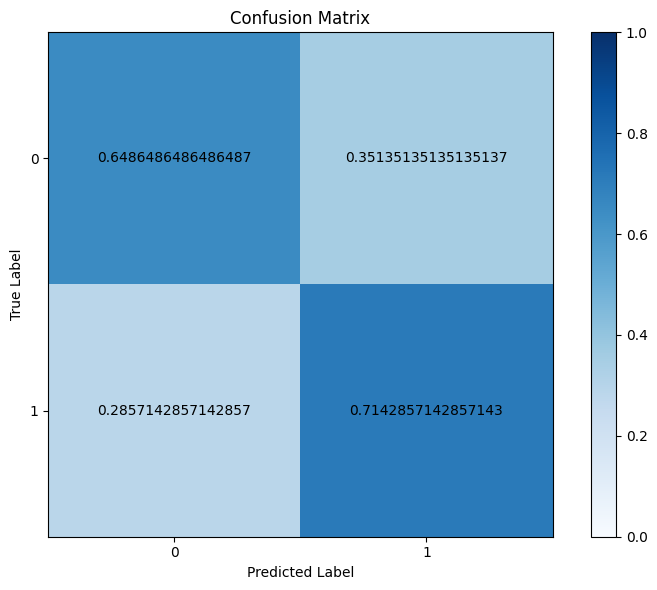

Train tracks shape:  (1108, 13)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5363 - loss: 0.7002 - val_accuracy: 0.2246 - val_loss: 0.8477
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6131 - loss: 0.6519 - val_accuracy: 0.2899 - val_loss: 0.8388
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6155 - loss: 0.6501 - val_accuracy: 0.3551 - val_loss: 0.8077
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.6157 - loss: 0.6709 - val_accuracy: 0.4275 - val_loss: 0.7589
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.6614 - loss: 0.6352 - val_accuracy: 0.4420 - val_loss: 0.7244
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.6810 - loss: 0.6374 - val_accuracy: 0.4420 - val_loss: 0.7057
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.6423 - loss: 0.6290 - val_accuracy: 0.5000 - val_loss: 0.6802
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6284 - loss: 0.6290 - val_accuracy: 0.5217 -

In [4]:
conf_matrix_cellfate, conf_matrix_tabular = data_size_study_cummulative(dataset_size, train_images, train_labels, train_tracks, test_images, test_labels, test_tracks, x_train_full, seed=43)

In [37]:
cumulative_cellfate_seed42_09 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_0.9/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed42_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_1.0/confusion_matrices_cellfate.npy")

cumulative_cellfate_seed42 = np.concatenate([cumulative_cellfate_seed42_09[:9], cumulative_cellfate_seed42_1], axis=0)

cumulative_cellfate_seed43_09 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed43_0.9/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed43_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed43_1.0/confusion_matrices_cellfate.npy")

cumulative_cellfate_seed43 = np.concatenate([cumulative_cellfate_seed43_09[:9], cumulative_cellfate_seed43_1], axis=0)

cumulative_cellfate_seed44_06 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.6/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_07 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.7/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_08 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.8/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_09 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_0.9/confusion_matrices_cellfate.npy")
cumulative_cellfate_seed44_1 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/cumulative_split_seed44_1.0/confusion_matrices_cellfate.npy")

cumulative_cellfate_seed44 = np.concatenate([cumulative_cellfate_seed44_06[:6], cumulative_cellfate_seed44_07[0].reshape(1,2,2), cumulative_cellfate_seed44_08[0].reshape(1,2,2), cumulative_cellfate_seed44_09[0].reshape(1,2,2), cumulative_cellfate_seed44_1], axis=0)

# Visualising Latent Spaces

In [41]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

size = 0.5
np.random.seed(config['seed'])
less_indexes = np.random.choice(np.arange(len(train_labels)), int(size * len(train_labels)), replace=False)

smaller_x_train_images = train_images[less_indexes]
smaller_y_train = train_labels[less_indexes]
smaller_x_train_tracks = train_tracks[less_indexes]

# Augment image data
smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

# Stretch intensities of new images (train and test)
stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

# Pick only frame zero
x_train = stretched_x_train_smaller[:,0,:,:]
y_train = smaller_train_labels_augmented
x_test = stretched_x_test[:,0,:,:]
y_test = test_labels

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/decoder.weights.h5")

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [38]:
np.load("../results/data_labelling_study/split_0.5/confusion_matrices_cellfate.npy")

array([[[0.52252252, 0.47747748],
        [0.32142857, 0.67857143]],

       [[0.54054054, 0.45945946],
        [0.21428571, 0.78571429]],

       [[0.63963964, 0.36036036],
        [0.46428571, 0.53571429]],

       [[0.57657658, 0.42342342],
        [0.25      , 0.75      ]],

       [[0.63063063, 0.36936937],
        [0.25      , 0.75      ]]])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


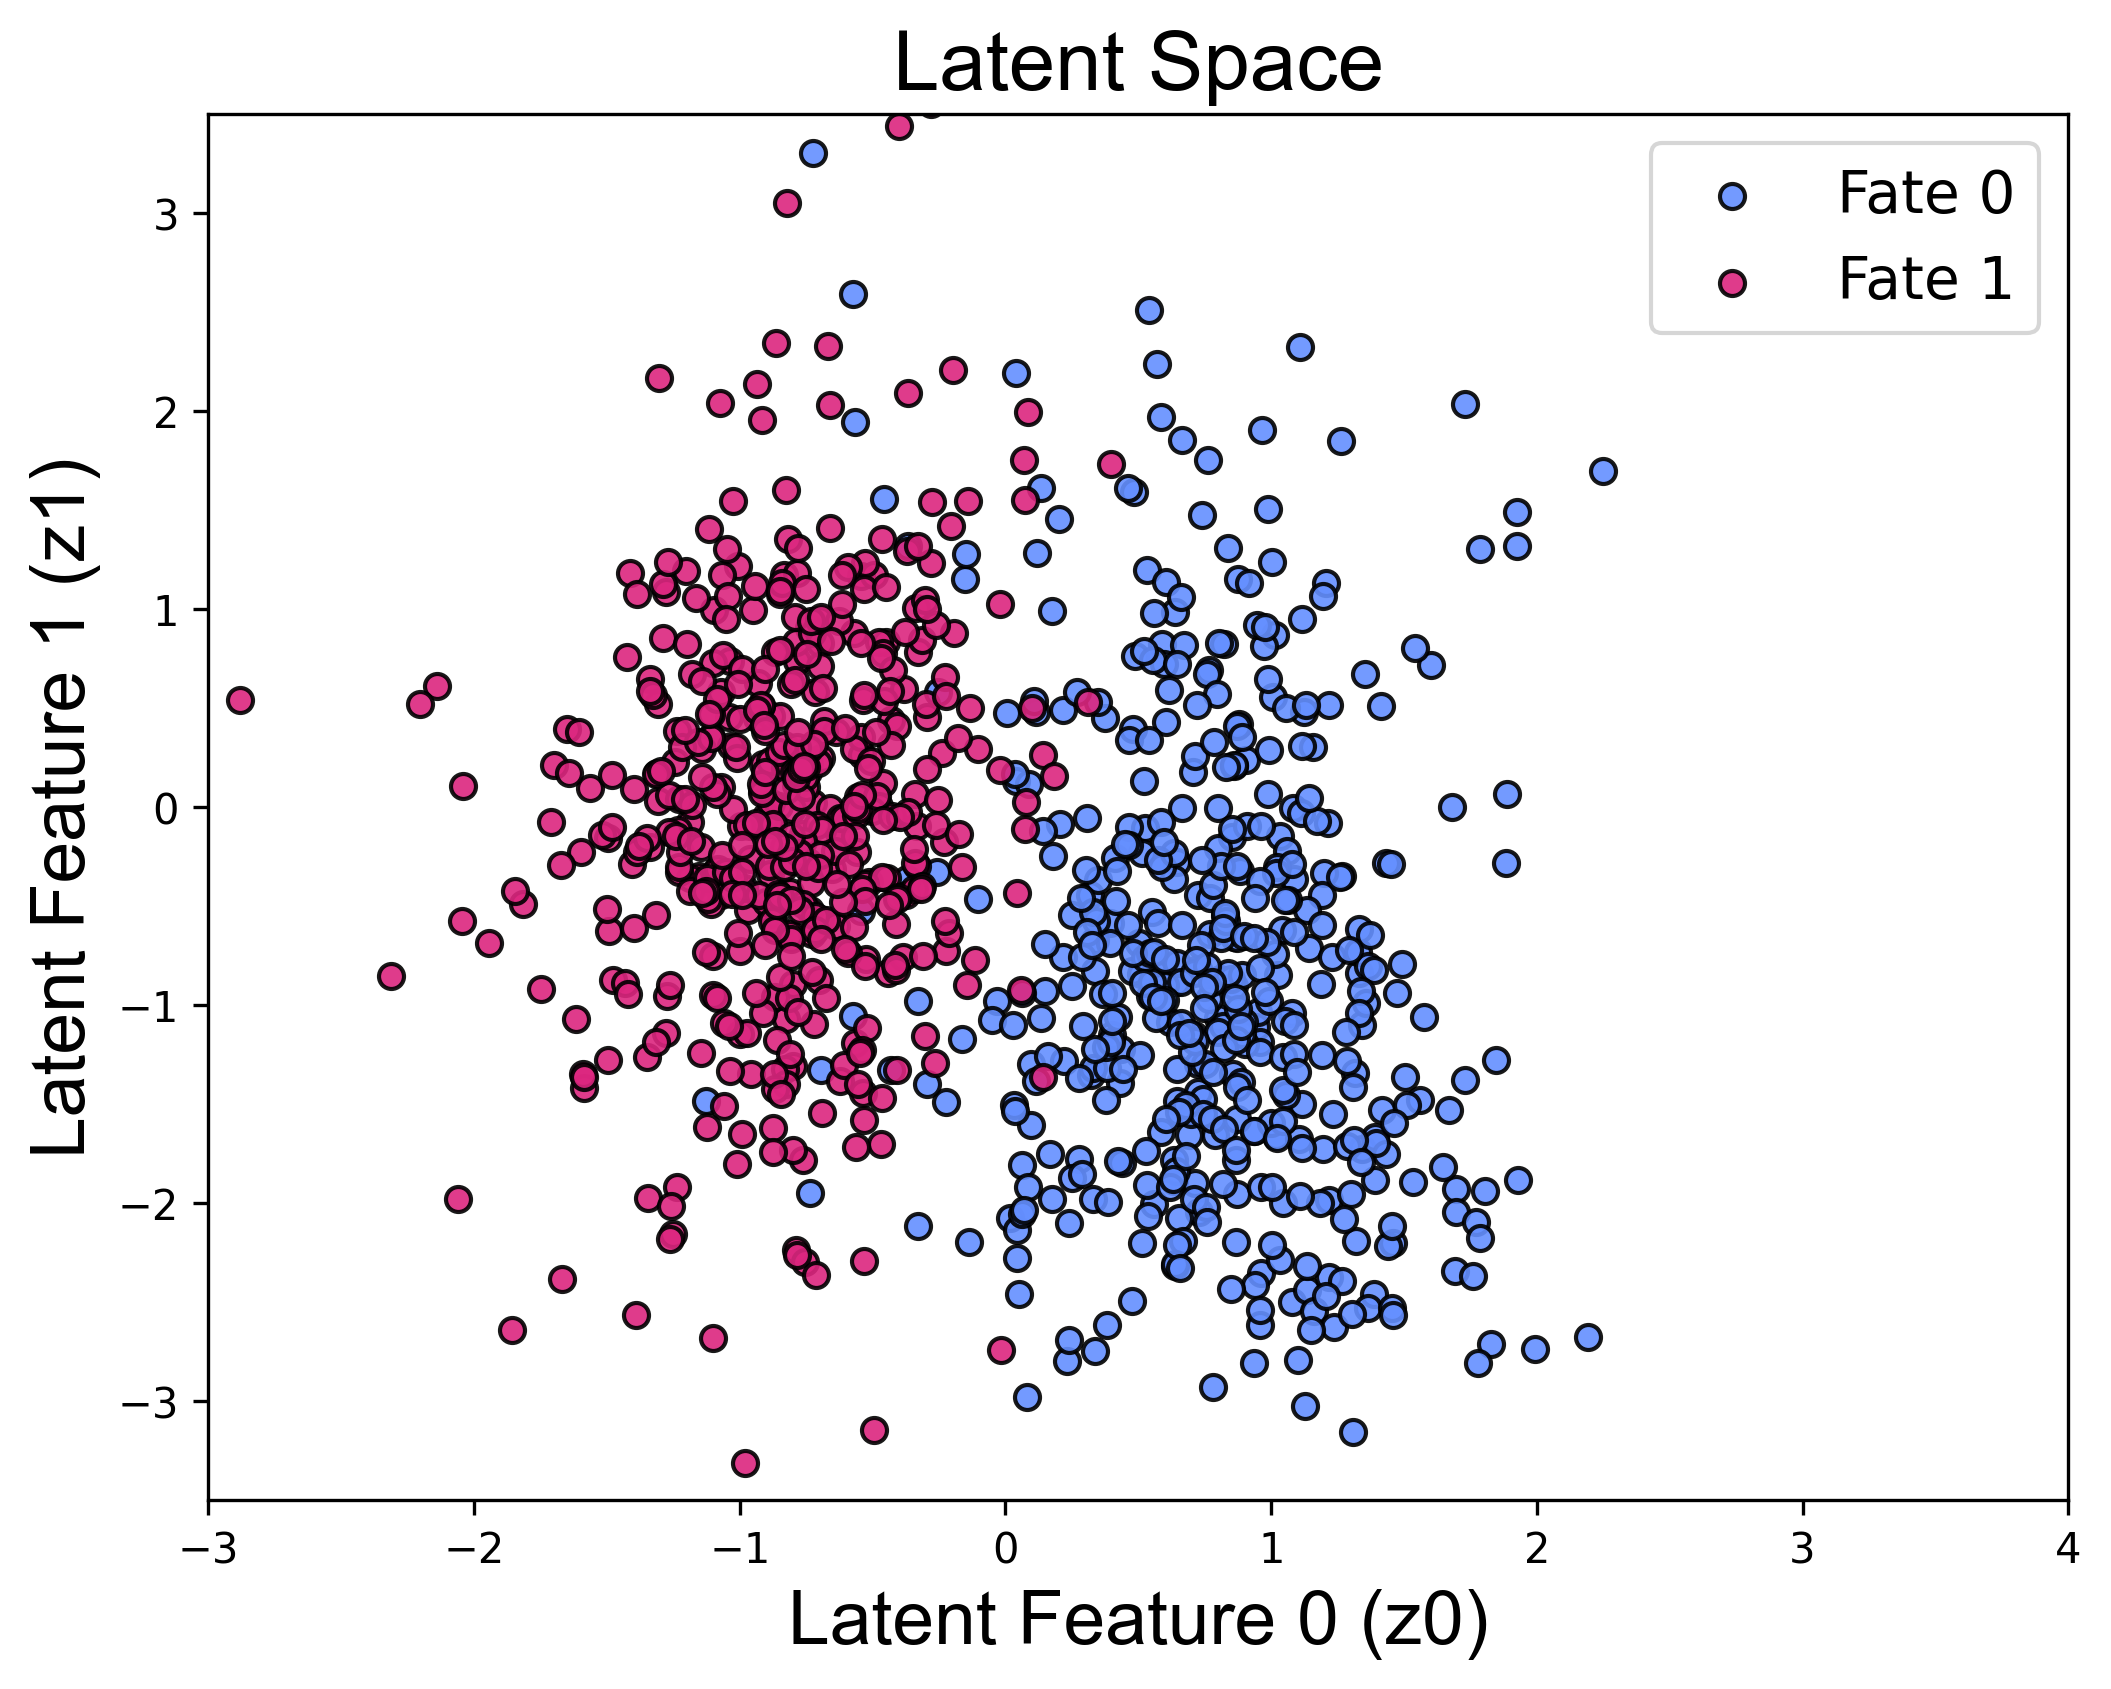

In [ ]:
# Predict the latent representations
latent_2d = encoder.predict(x_train) 

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.9, edgecolors='k') #
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.9, edgecolors='k') 

plt.xlim(-3, 4)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")
plt.legend(fontsize=14)
#plt.grid(True, linestyle="--", linewidth=0.5)

# Save as high-quality SVG and PDF
#plt.savefig("ls_split05.eps", format="eps", bbox_inches="tight")

plt.show()

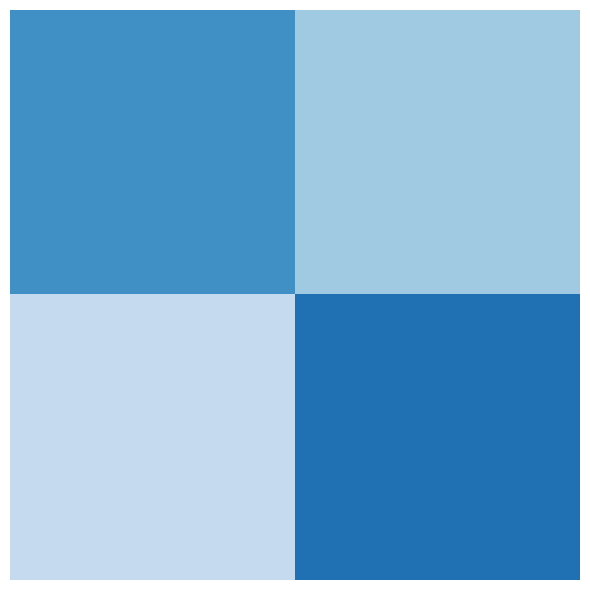

In [ ]:
#### LAMBDA CONTRASTIVE LOSS = 4

conf_matrix_cellfate_split05 = np.load("/Users/inescunha/Documents/GitHub/CellFate/results/data_labelling_study/split_0.5/confusion_matrices_cellfate.npy")[4]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_cellfate_split05, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
#plt.savefig("confusion_matrix_split05.eps", dpi=300, pad_inches=0)
plt.show()

In [19]:
# Test latent space

augmented_x_test_for_visuals, augmented_y_test_for_visuals = augment_dataset(x_test, y_test, augmentations)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


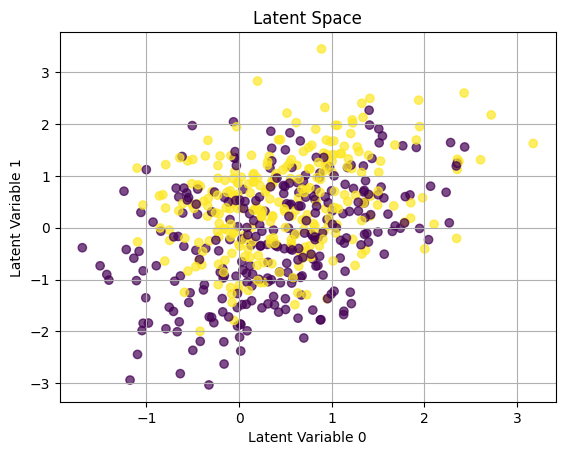

In [21]:
feat_0 = 0
feat_1 = 1
scatter = plt.scatter(encoder.predict(augmented_x_test_for_visuals[:,:,:])[:, feat_0], encoder.predict(augmented_x_test_for_visuals[:,:,:])[:, feat_1], c=augmented_y_test_for_visuals, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


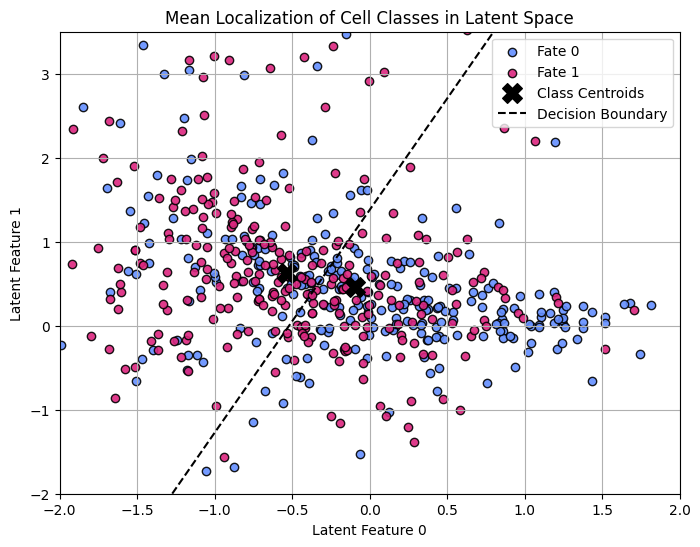

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the latent representations
latent_2d = encoder.predict(augmented_x_test_for_visuals)  # Shape (1380, 2)

# Compute mean localization (centroids) for each class
centroid_0 = latent_2d[augmented_y_test_for_visuals == 0].mean(axis=0)  # Mean of class 0
centroid_1 = latent_2d[augmented_y_test_for_visuals == 1].mean(axis=0)  # Mean of class 1
centroids = np.array([centroid_0, centroid_1])

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot for each class separately
plt.scatter(latent_2d[augmented_y_test_for_visuals == 0][:, 0], latent_2d[augmented_y_test_for_visuals == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.9, edgecolors='k')
plt.scatter(latent_2d[augmented_y_test_for_visuals == 1][:, 0], latent_2d[augmented_y_test_for_visuals == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.9, edgecolors='k')

# Plot centroids as black crosses
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Class Centroids")

# Decision boundary: Find midpoint of centroids and plot the separating line
x_vals = np.linspace(latent_2d[:, 0].min(), latent_2d[:, 0].max(), 100)
slope = -(centroid_1[0] - centroid_0[0]) / (centroid_1[1] - centroid_0[1])
intercept = (centroid_0[1] + centroid_1[1]) / 2 - slope * (centroid_0[0] + centroid_1[0]) / 2
plt.plot(x_vals, slope * x_vals + intercept, 'k--', label="Decision Boundary")

# Set axis limits
plt.xlim(-2, 2)
plt.ylim(-2, 3.5)

plt.xlabel("Latent Feature 0")
plt.ylabel("Latent Feature 1")
plt.title("Mean Localization of Cell Classes in Latent Space")
plt.legend()
plt.grid(True)
plt.show()
